In [1]:
import torch
import numpy as np
import pickle
from lpne.models import DcsfaNmf
from lpne.plotting import circle_plot
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
#from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as image
import os, sys
import seaborn as sns
import pandas as pd

umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

flx_data_path = "/work/mk423/Anxiety/final_FLX_{}.pkl"
epm_data_path = "/work/mk423/Anxiety/EPM_{}_dict_May_17.pkl"
oft_data_path = "/work/mk423/Anxiety/OFT_{}_dict_old_features_hand_picked.pkl"

anx_info_dict = "/work/mk423/Anxiety/Anx_Info_Dict.pkl"

saved_model_path = "/hpc/home/mk423/Anxiety/FullDataWork/Models/"
saved_model_name = "Final_mt_Model_500_epochs.pt"

projection_save_path = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
plots_path = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"

feature_list = ["X_psd","X_coh","X_gc"]
old_feature_list = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]
feature_weights = [10,1,1]

RANDOM_STATE = 42

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
with open(flx_data_path.format("train"),"rb") as f:
    train_dict = pickle.load(f)
    
with open(flx_data_path.format("val"),"rb") as f:
    val_dict = pickle.load(f)
    
with open(flx_data_path.format("test"),"rb") as f:
    test_dict = pickle.load(f)
    
flx_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_train = train_dict['y_flx']
flx_y_mouse_train = train_dict['y_mouse']
flx_y_hab_train = train_dict['y_hab']
flx_y_time_train = train_dict['y_time']

flx_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_val = val_dict['y_flx']
flx_y_mouse_val = val_dict['y_mouse']
flx_y_hab_val = val_dict['y_hab']
flx_y_time_val = val_dict['y_time']

flx_X_test = np.hstack([test_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_test = test_dict['y_flx']
flx_y_mouse_test = test_dict['y_mouse']
flx_y_hab_test = test_dict['y_hab']
flx_y_time_test = test_dict['y_time']
flx_y_expDate_test = test_dict['y_expDate']

#Stack Validation and Training Data from timepoints after 30 minutes
flx_X = np.vstack([flx_X_train[flx_y_hab_train==1],flx_X_val[flx_y_hab_val==1]])
flx_y = np.hstack([flx_y_train[flx_y_hab_train==1],flx_y_val[flx_y_hab_val==1]])
flx_y_mouse = np.hstack([flx_y_mouse_train[flx_y_hab_train==1], flx_y_mouse_val[flx_y_hab_val==1]])

In [3]:
with open(oft_data_path.format("train"),'rb') as f:
    train_dict = pickle.load(f)

with open(oft_data_path.format("validation"),'rb') as f:
    val_dict = pickle.load(f)
    
with open(oft_data_path.format("test"),'rb') as f:
    test_dict = pickle.load(f)
    

running_idx = 0
feature_groups = []
for idx,feature in enumerate(old_feature_list):
    f_begin = running_idx
    f_end = f_begin + train_dict[feature].shape[1] 
    if idx == 0:
        f_end = f_end -1
    feature_groups.append((f_begin,f_end))

    running_idx = f_end

NUM_FREQS = 56
NUM_FEATURES = np.hstack([train_dict[feature] for feature in old_feature_list]).shape[1] // NUM_FREQS
scale_vector = np.array([np.arange(1,NUM_FREQS+1) for feature in range(NUM_FEATURES)]).flatten()

#Train Arrays
oft_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_train = train_dict['y_Homecage'].astype(bool)
oft_y_task_train = ~oft_y_hc_train
oft_y_ROI_train = train_dict['y_ROI']
oft_y_vel_train = train_dict['y_vel']
oft_y_mouse_train = train_dict['y_mouse']
oft_y_time_train = train_dict['y_time']

#Validation Arrays
oft_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_val = val_dict['y_Homecage'].astype(bool)
oft_y_task_val = ~oft_y_hc_val
oft_y_ROI_val = val_dict['y_ROI']
oft_y_vel_val = val_dict['y_vel']
oft_y_mouse_val = val_dict['y_mouse']
oft_y_time_val = val_dict['y_time']

#Test Arrays
oft_X_test = np.hstack([test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_test = test_dict['y_Homecage'].astype(bool)
oft_y_task_test = ~oft_y_hc_test
oft_y_ROI_test = test_dict['y_ROI']
oft_y_vel_test = test_dict['y_vel']
oft_y_mouse_test = test_dict['y_mouse']
oft_y_time_test = test_dict['y_time']
oft_y_expDate_test = test_dict['y_expDate']

oft_X = np.vstack([oft_X_train,oft_X_val])
oft_y_task = np.hstack([oft_y_task_train,oft_y_task_val])
oft_y_mouse = np.hstack([oft_y_mouse_train,oft_y_mouse_val])

In [4]:
with open(epm_data_path.format("train"),"rb") as f:
    epm_train_dict = pickle.load(f)

with open(epm_data_path.format("val"),"rb") as f:
    epm_validation_dict = pickle.load(f)
    
with open(epm_data_path.format("test"),"rb") as f:
    epm_test_dict = pickle.load(f)

#Load the data
NUM_FREQS = 56
NUM_FEATURES = (epm_train_dict["X_power_1_2"].shape[1] + \
                epm_train_dict["X_coh_1_2"].shape[1] + \
                epm_train_dict["X_gc_1_2"].shape[1]) // NUM_FREQS
SCALE_VECTOR = np.array([np.arange(1,57) for feature in range(NUM_FEATURES)]).flatten()

X_train = np.hstack([epm_train_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
X_train[X_train<0] = 0
y_train = (epm_train_dict['y_ROI']%2).astype(bool)
y_in_task_mask_train = ~epm_train_dict['y_Homecage'].astype(bool)
y_mouse_train = epm_train_dict['y_mouse']
y_time_train = epm_train_dict['y_time']
train_nan_mask = (epm_train_dict['y_ROI'] > 0)


X_train_task = X_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_train_task = y_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_mouse_train_task = y_mouse_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_time_train_task = y_time_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
X_val = np.hstack([epm_validation_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])


y_val = (epm_validation_dict['y_ROI']%2).astype(bool)
y_in_task_mask_val= ~epm_validation_dict['y_Homecage'].astype(bool)
y_mouse_val = epm_validation_dict['y_mouse']
y_time_val = epm_validation_dict['y_time']
val_nan_mask = (epm_validation_dict['y_ROI'] > 0)

X_val_task = X_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_val_task = y_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_mouse_val_task = y_mouse_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_time_val_task = y_time_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]

X_test = np.hstack([epm_test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
y_test = (epm_test_dict['y_ROI']%2).astype(bool)
y_in_task_mask_test= ~epm_test_dict['y_Homecage'].astype(bool)
y_mouse_test = epm_test_dict['y_mouse']
y_time_test = epm_test_dict['y_time']
test_nan_mask = (epm_test_dict['y_ROI'] > 0)
epm_y_expDate_test = epm_test_dict['y_expDate']

X_test_task = X_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_test_task = y_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_mouse_test_task = y_mouse_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_time_test_task = y_time_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]

epm_X = np.vstack([X_train,X_val])
epm_y_task = np.hstack([y_in_task_mask_train,y_in_task_mask_val])
epm_y_mouse = np.hstack([y_mouse_train,y_mouse_val])
epm_y_time = np.hstack([y_time_train,y_time_val])

In [10]:
for group in [flx_y_mouse,oft_y_mouse,epm_y_mouse]:
    print(np.unique(group).shape)

(13,)
(19,)
(26,)


In [11]:
for group in [flx_y_mouse_test,oft_y_mouse_test,y_mouse_test]:
    print(np.unique(group).shape)

(6,)
(9,)
(11,)


In [29]:
np.intersect1d(np.intersect1d(oft_y_mouse_test,y_mouse_test),flx_y_mouse_test)

array(['Mouse69061'], dtype='<U10')

In [32]:
np.intersect1d(np.intersect1d(flx_y_mouse,oft_y_mouse),epm_y_mouse)

array([], dtype='<U10')

In [5]:
mt_X_train = np.vstack([flx_X,oft_X,epm_X])
mt_y_train = np.hstack([flx_y,oft_y_task,epm_y_task]).reshape(-1,1)
mt_y_mouse_train = np.hstack([flx_y_mouse,oft_y_mouse,epm_y_mouse])

mt_X_test = np.vstack([flx_X_test[flx_y_hab_test==1],oft_X_test,X_test])
mt_y_test = np.hstack([flx_y_test[flx_y_hab_test==1],oft_y_task_test,y_in_task_mask_test]).reshape(-1,1)
mt_y_mouse_test = np.hstack([flx_y_mouse_test[flx_y_hab_test==1],oft_y_mouse_test,y_mouse_test])

intercept_mask = OneHotEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1)).todense()
sample_groups = OrdinalEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1))
nmf_groups = np.hstack(
    [
        np.ones(flx_X.shape[0])*0,
        np.ones(oft_X.shape[0]),
        np.ones(epm_X.shape[0])*2
    ]
)

In [7]:
np.unique(mt_y_mouse_train).shape

(41,)

In [8]:
np.unique(mt_y_mouse_test).shape

(17,)

In [9]:
TRAIN = False

if TRAIN:
    model = DcsfaNmf(
        n_components=30,
        n_sup_networks=3,
        sup_type="sc",
        n_intercepts=intercept_mask.shape[1],
        optim_name="SGD",
        recon_loss="MSE",
        feature_groups=feature_groups,
        fixed_corr=["positive","positive","positive"],
        save_folder=saved_model_path,
    )

    model.fit(mt_X_train,
              mt_y_train,
              intercept_mask=intercept_mask,
              y_sample_groups=sample_groups,
              batch_size=128,
              lr=1e-3,
              n_pre_epochs=500,
              n_epochs=500,
              nmf_max_iter=3000,
              nmf_groups=nmf_groups,
              bootstrap=True,
              pretrain=True,
              verbose=True,
              best_model_name=saved_model_name)

    #torch.save(model,saved_model_path + saved_model_name)
    
else:
    model = torch.load(saved_model_path + saved_model_name,map_location="cpu")
    model.device="cpu"

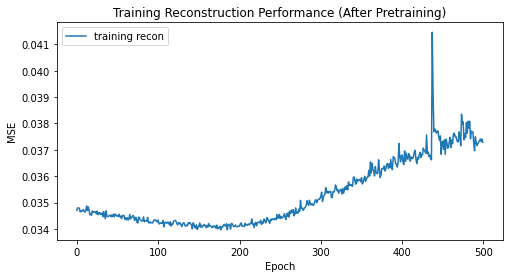

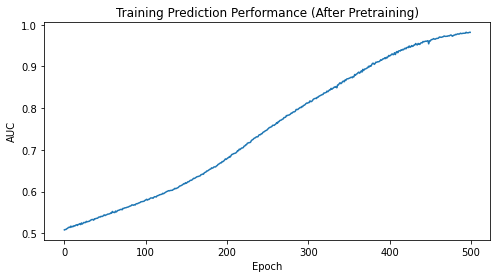

In [10]:
plt.figure(figsize=(8,4))
plt.plot(model.recon_hist,label="training recon")
#plt.plot(model.val_recon_hist,label="validation recon")
#plt.axvline(model.best_epoch,color="red",label="best epoch")
plt.title("Training Reconstruction Performance (After Pretraining)")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(model.pred_hist,label="training auc")
#plt.plot(model.val_pred_hist,label="validation auc")
#plt.axvline(model.best_epoch,color="red",label="best epoch")
plt.title("Training Prediction Performance (After Pretraining)")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

### Visualize the Networks

(1, 448) (1, 1568) (1, 3136)


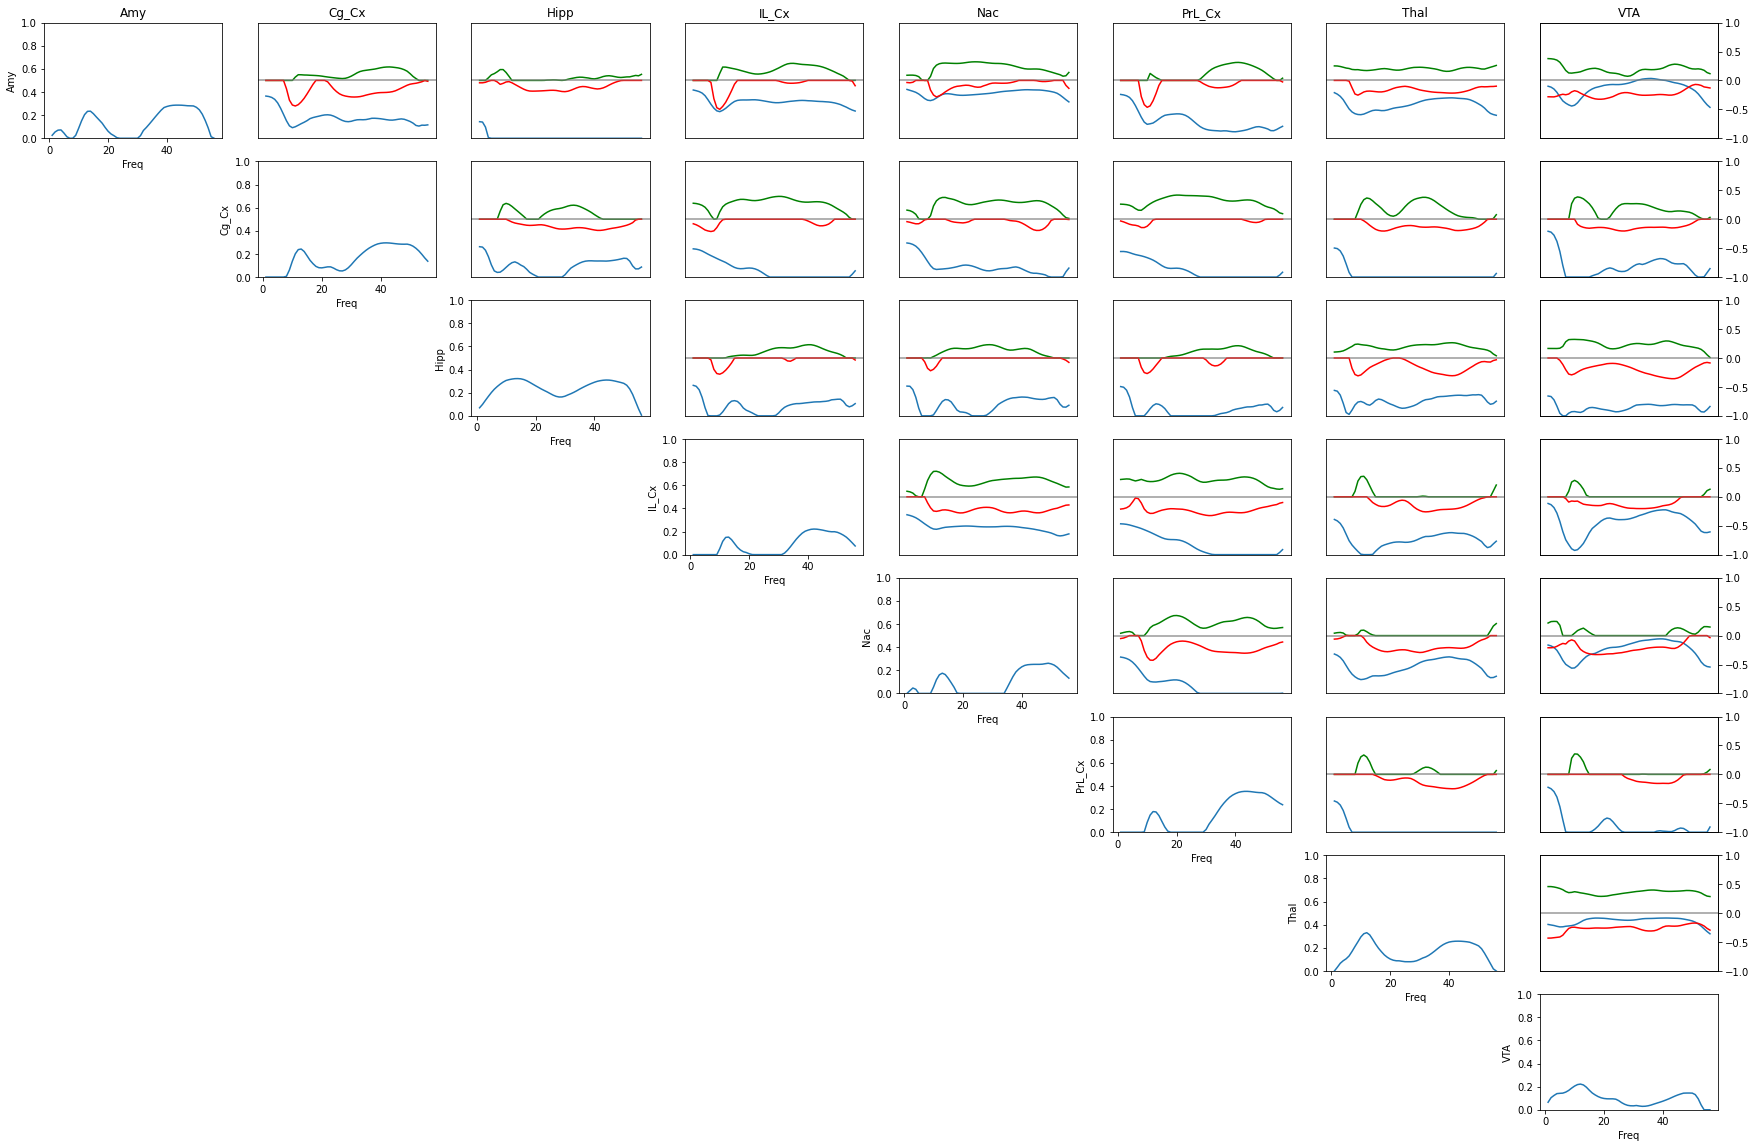

(1, 448) (1, 1568) (1, 3136)


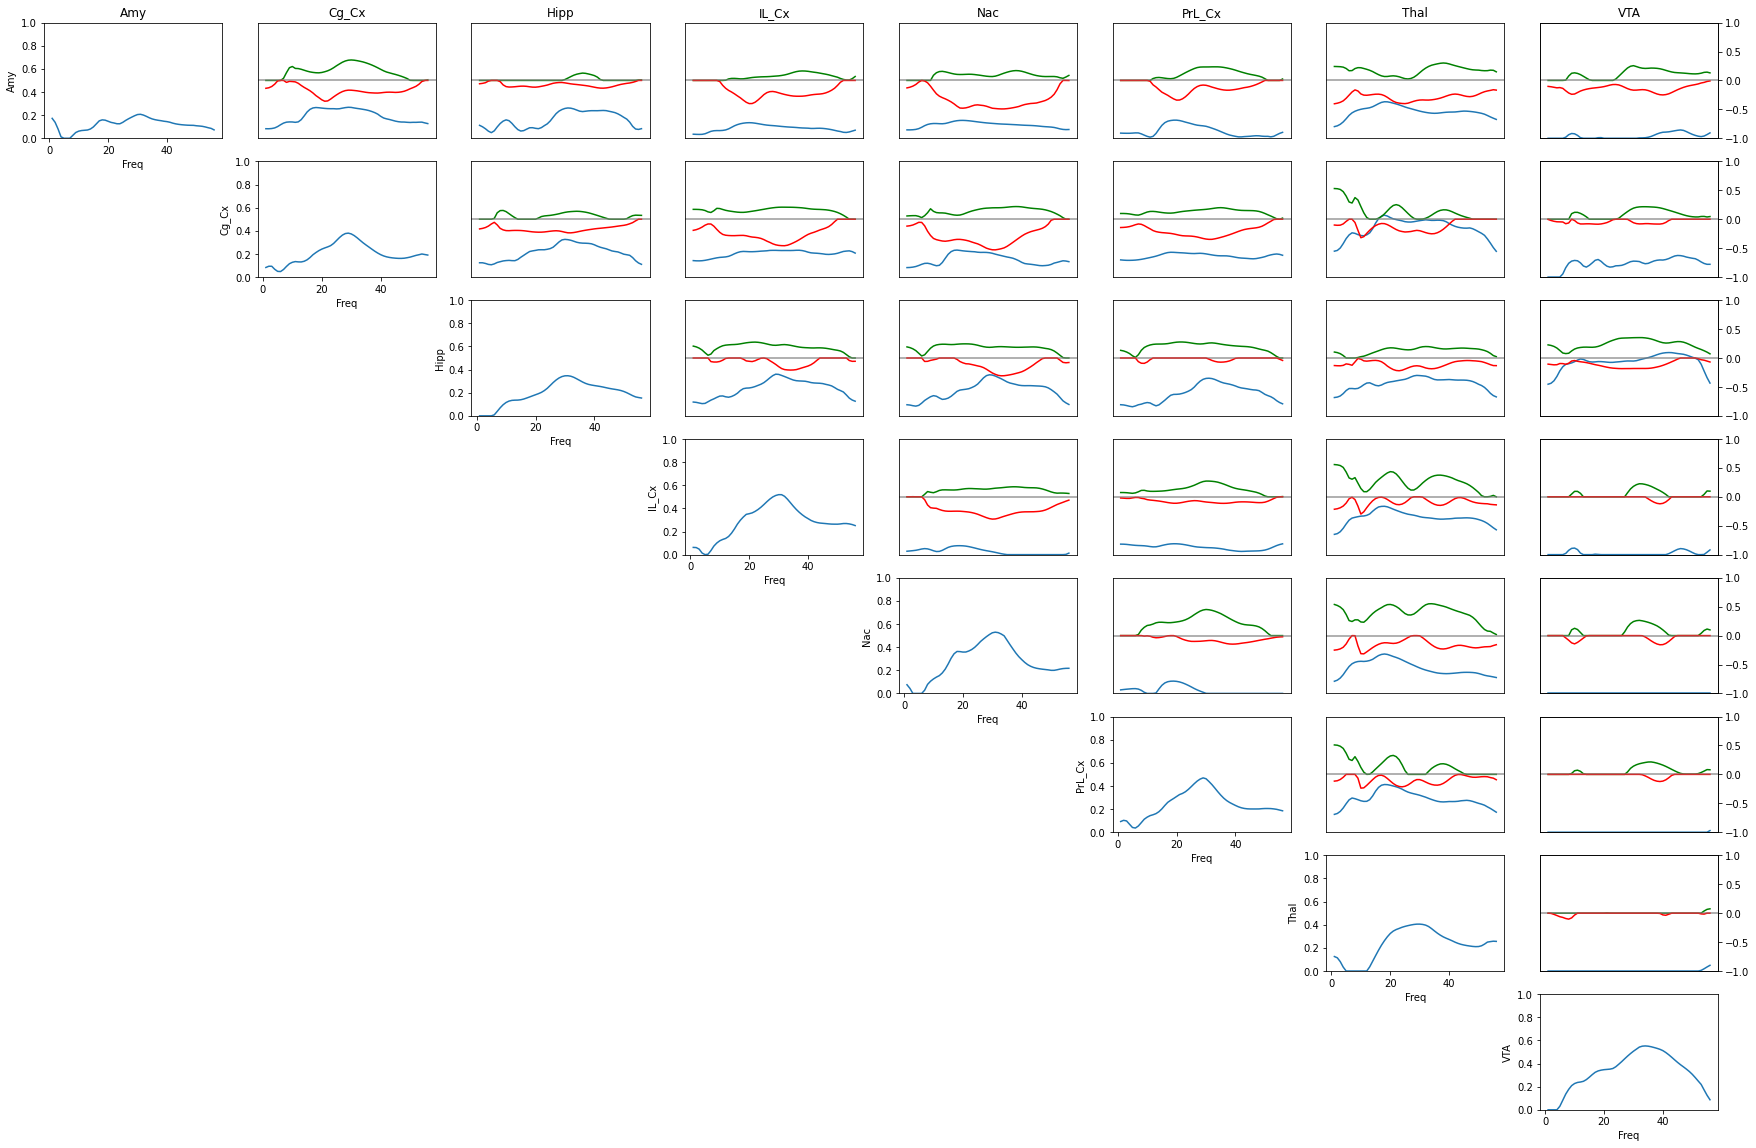

(1, 448) (1, 1568) (1, 3136)


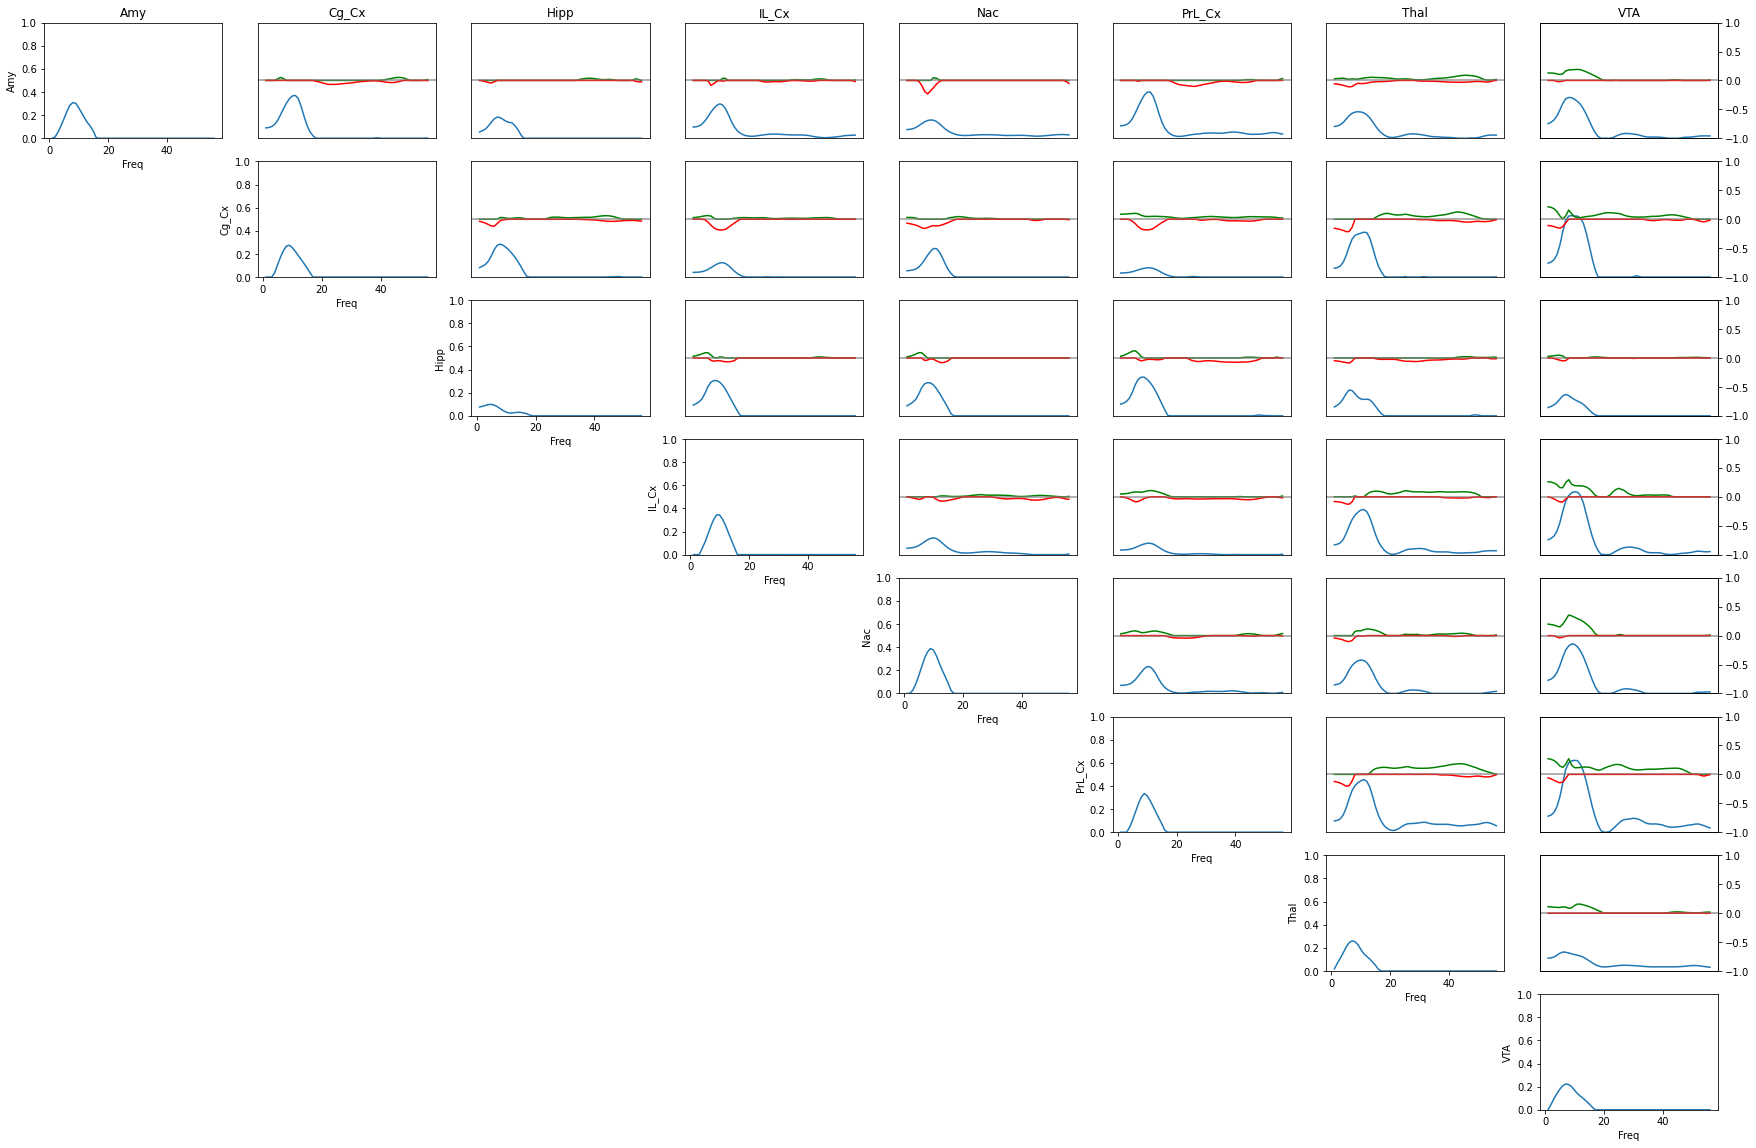

(1, 448) (1, 1568) (1, 3136)


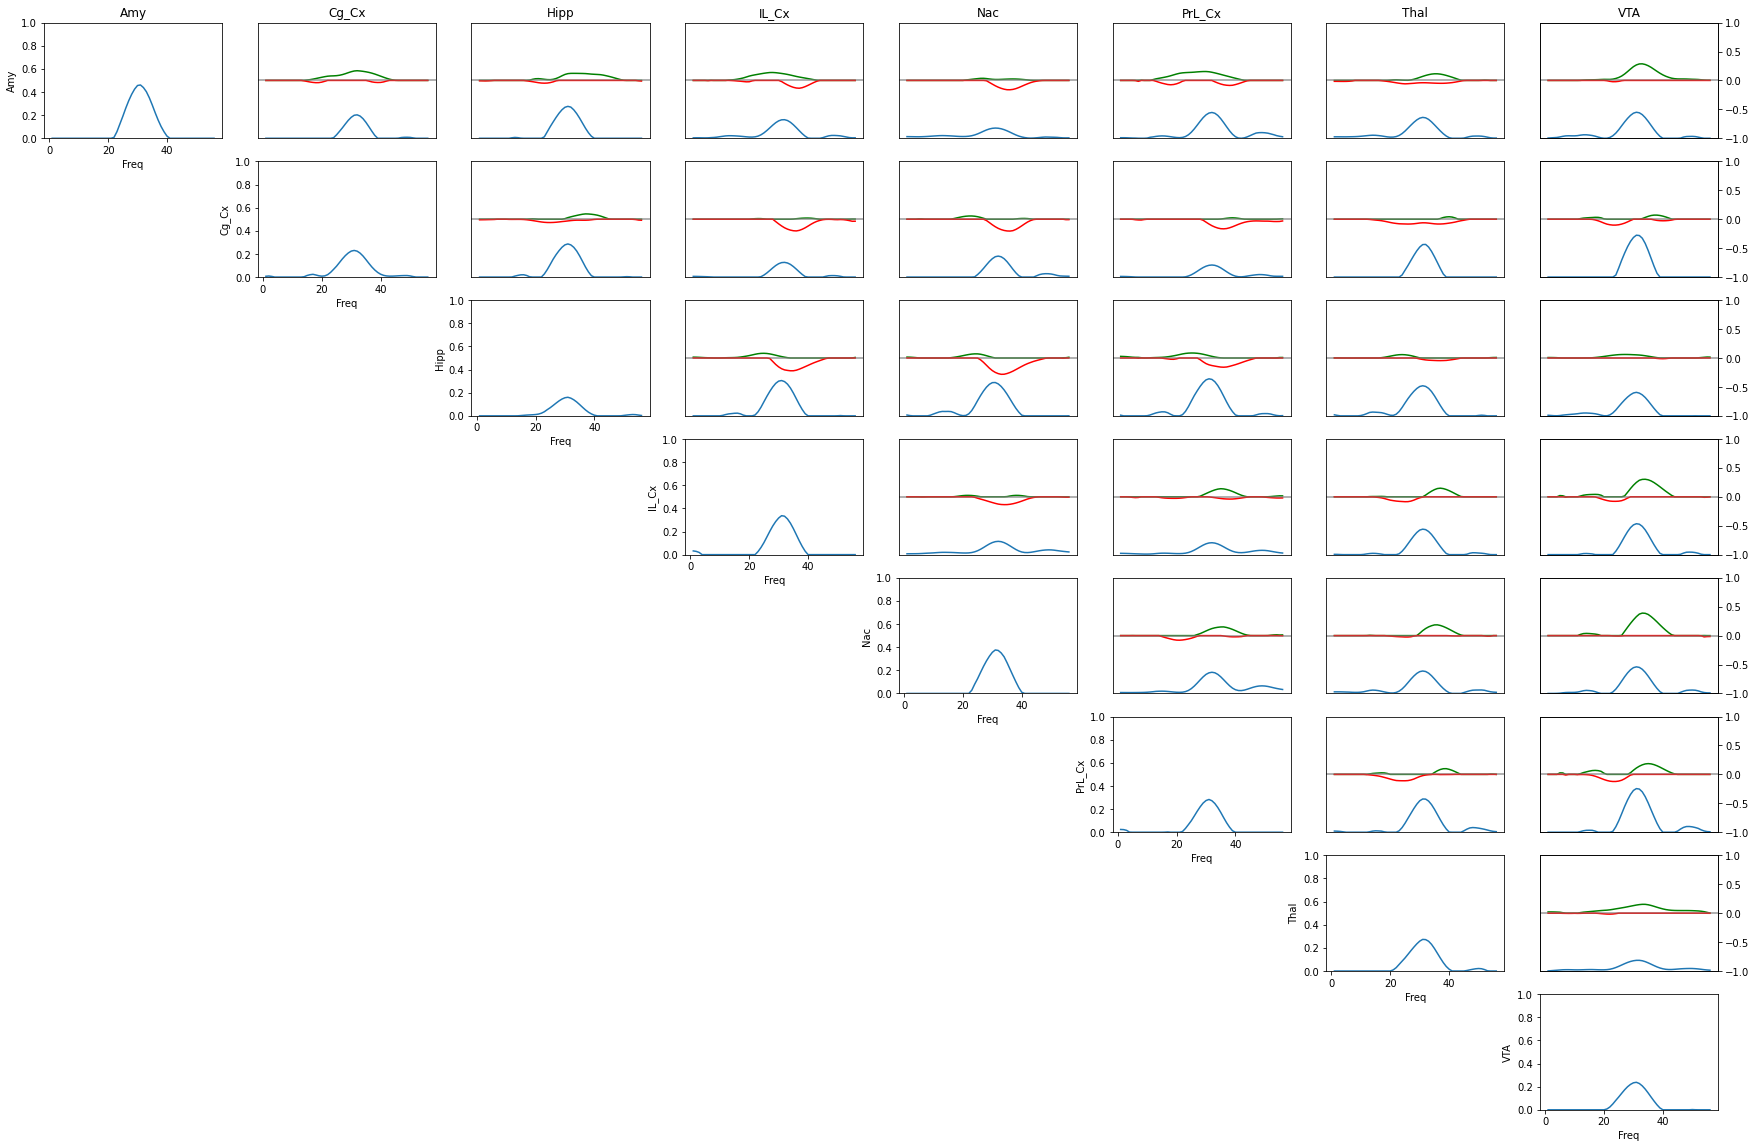

(1, 448) (1, 1568) (1, 3136)


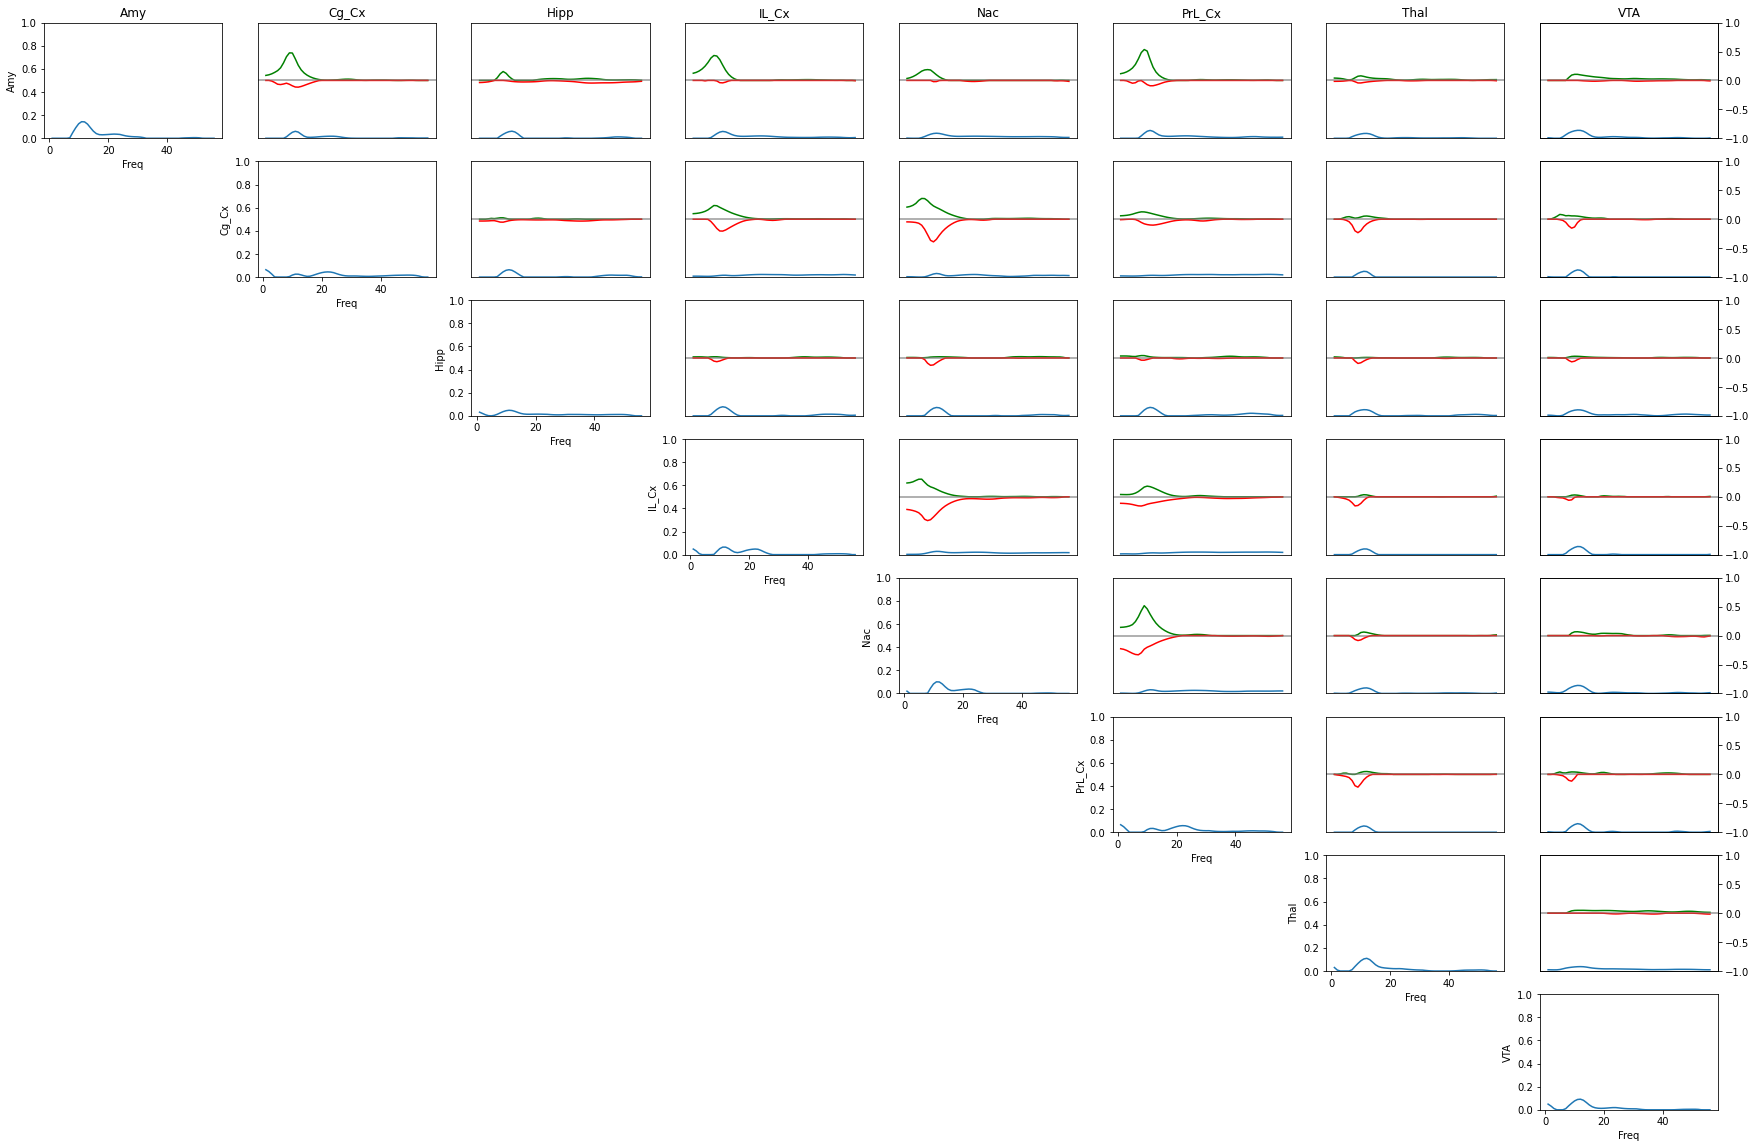

(1, 448) (1, 1568) (1, 3136)


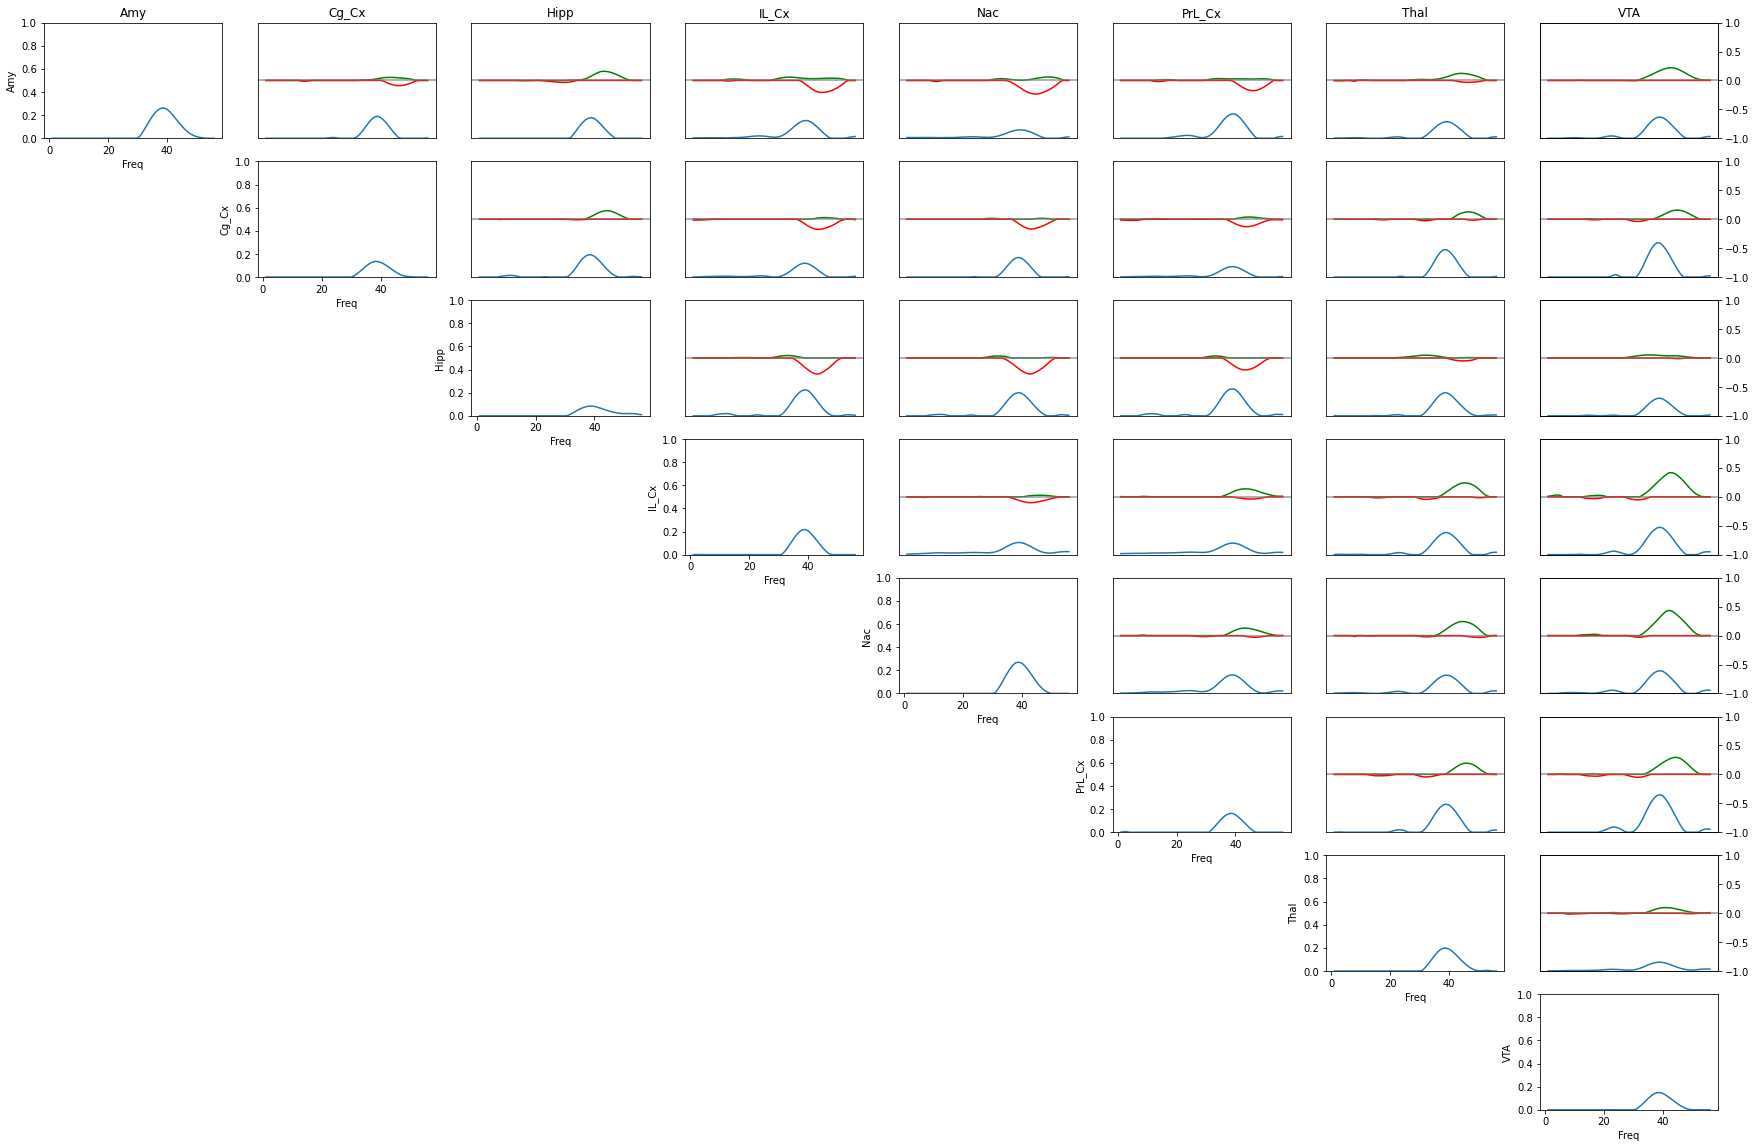

(1, 448) (1, 1568) (1, 3136)


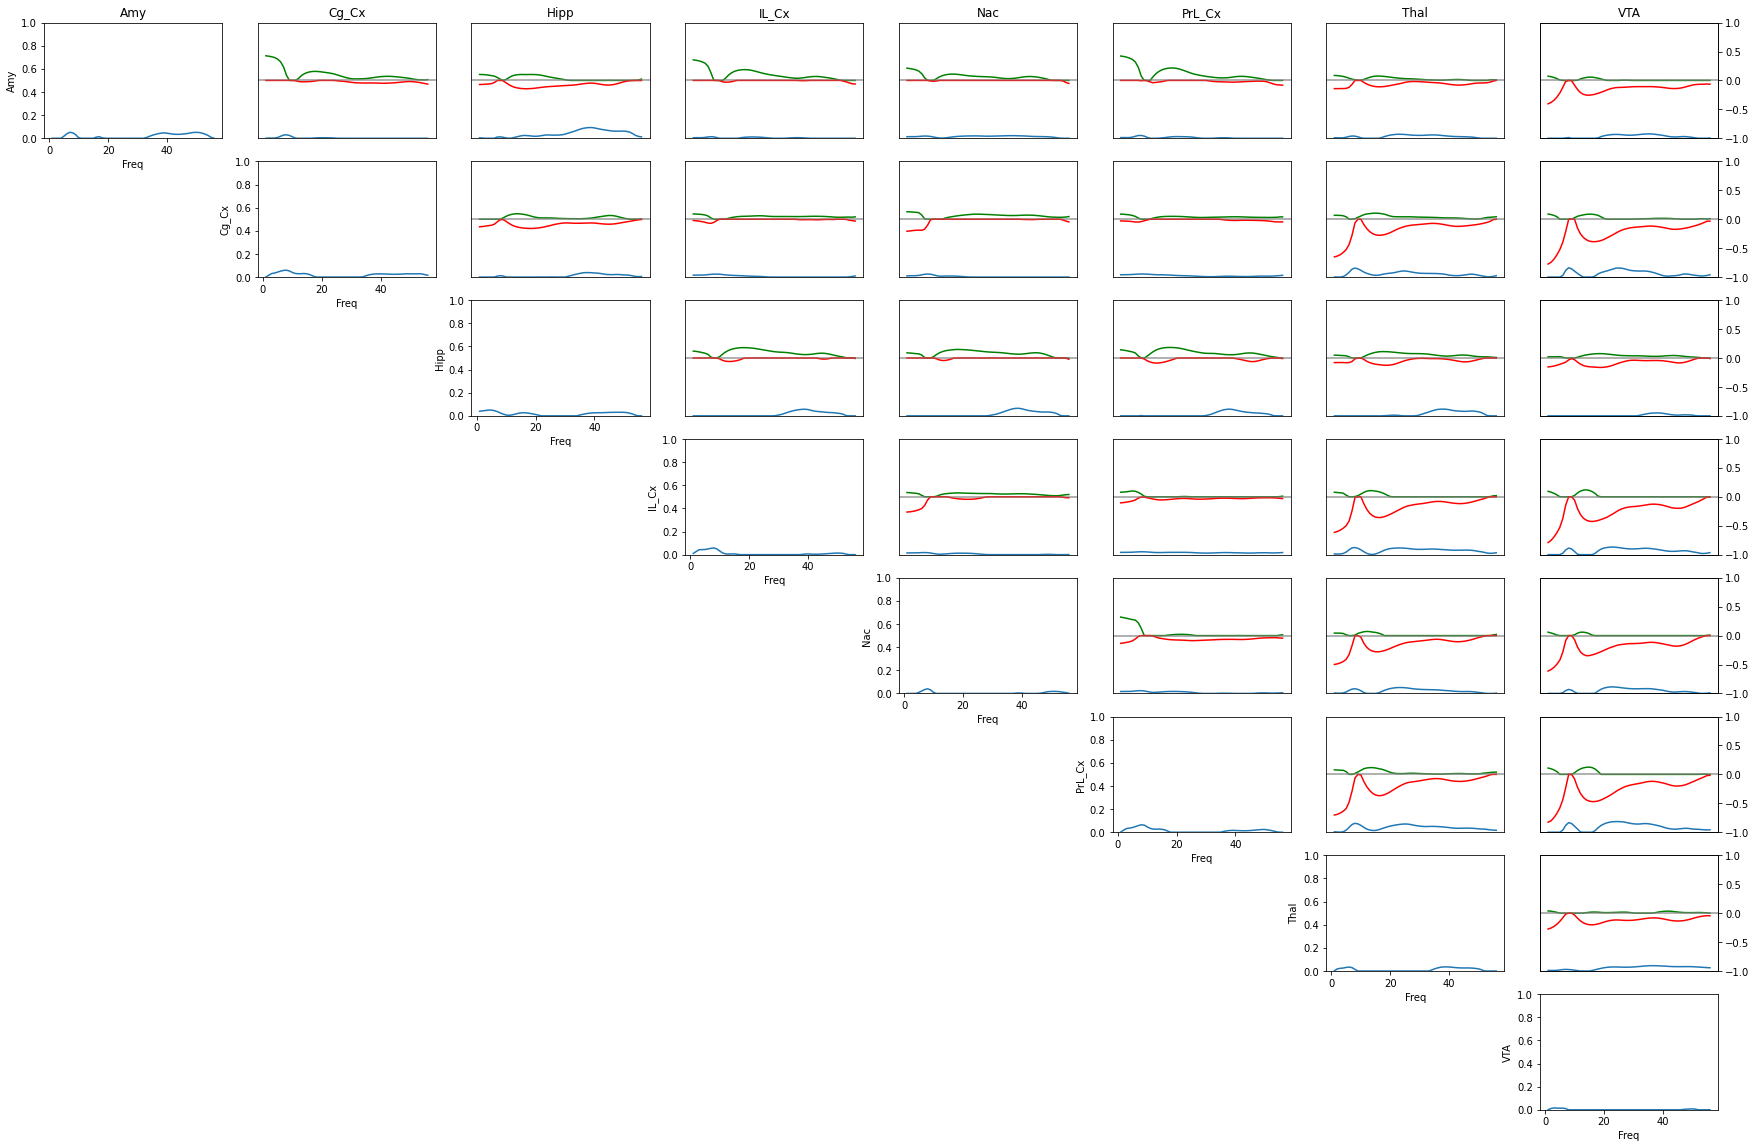

(1, 448) (1, 1568) (1, 3136)


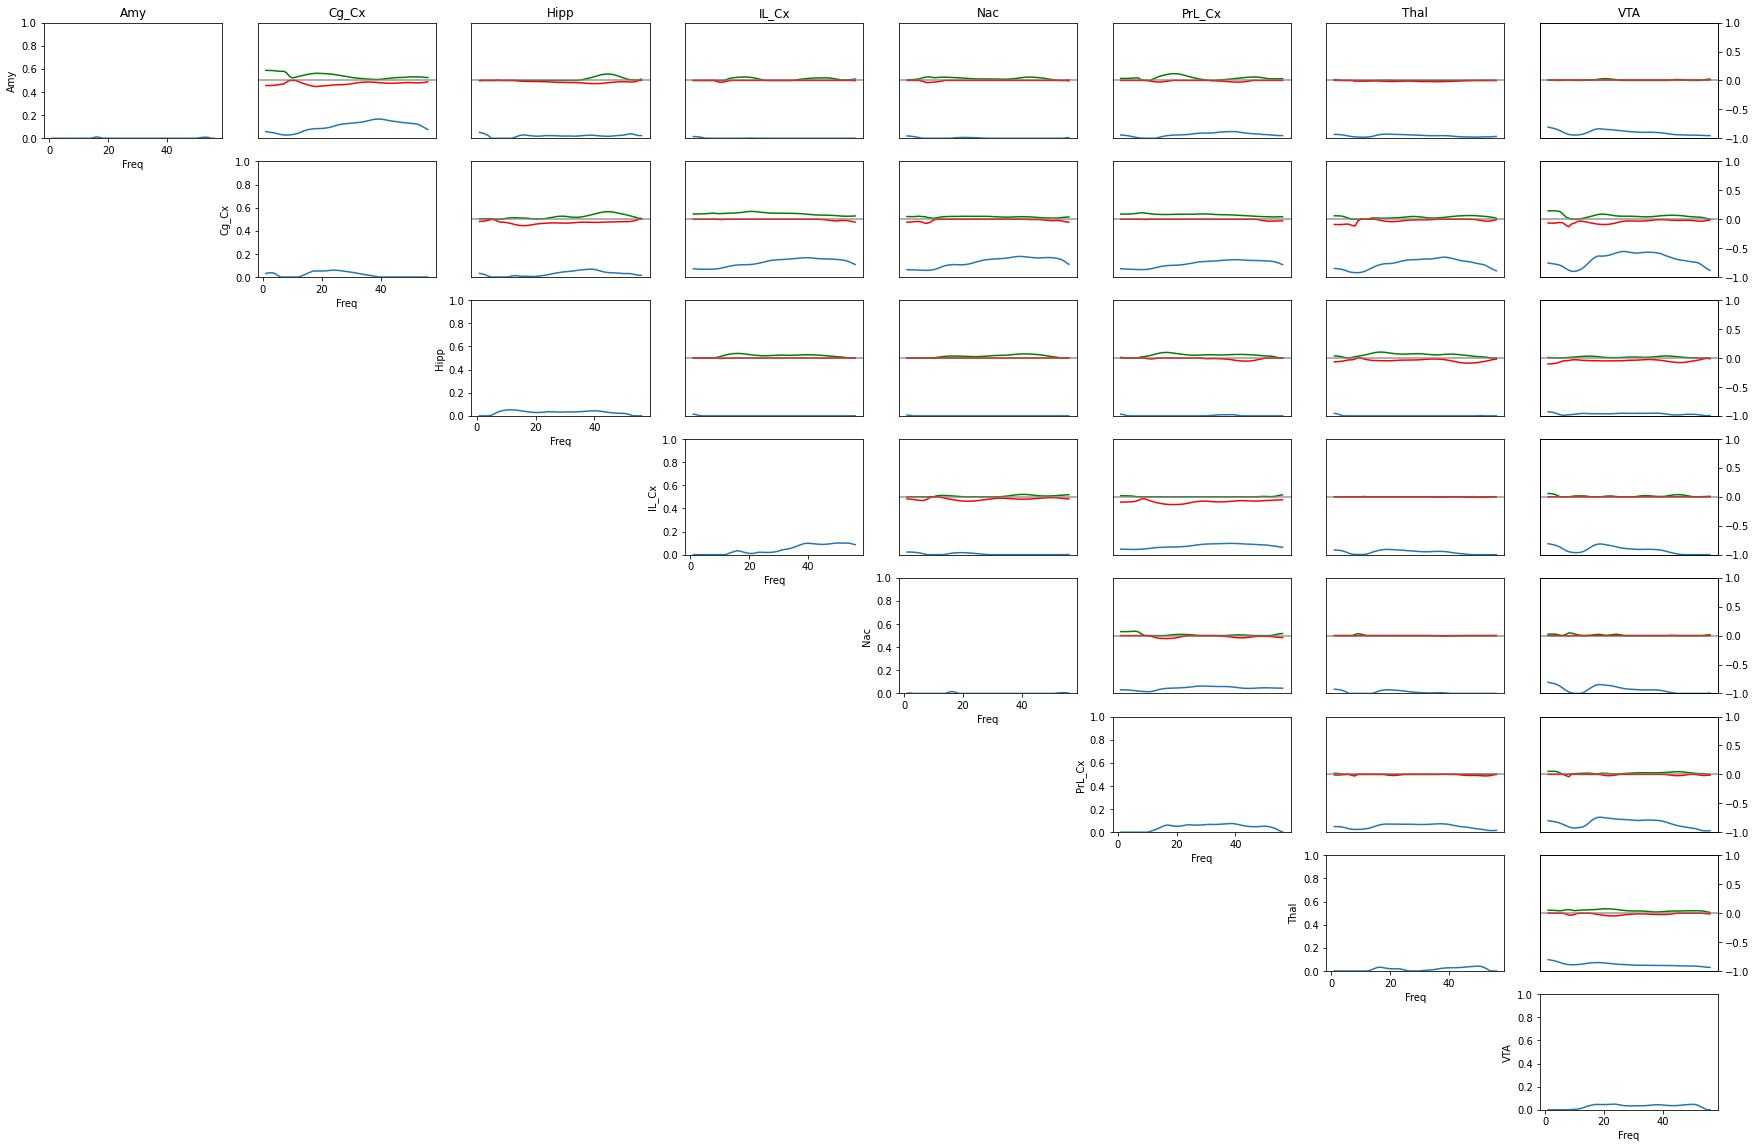

(1, 448) (1, 1568) (1, 3136)


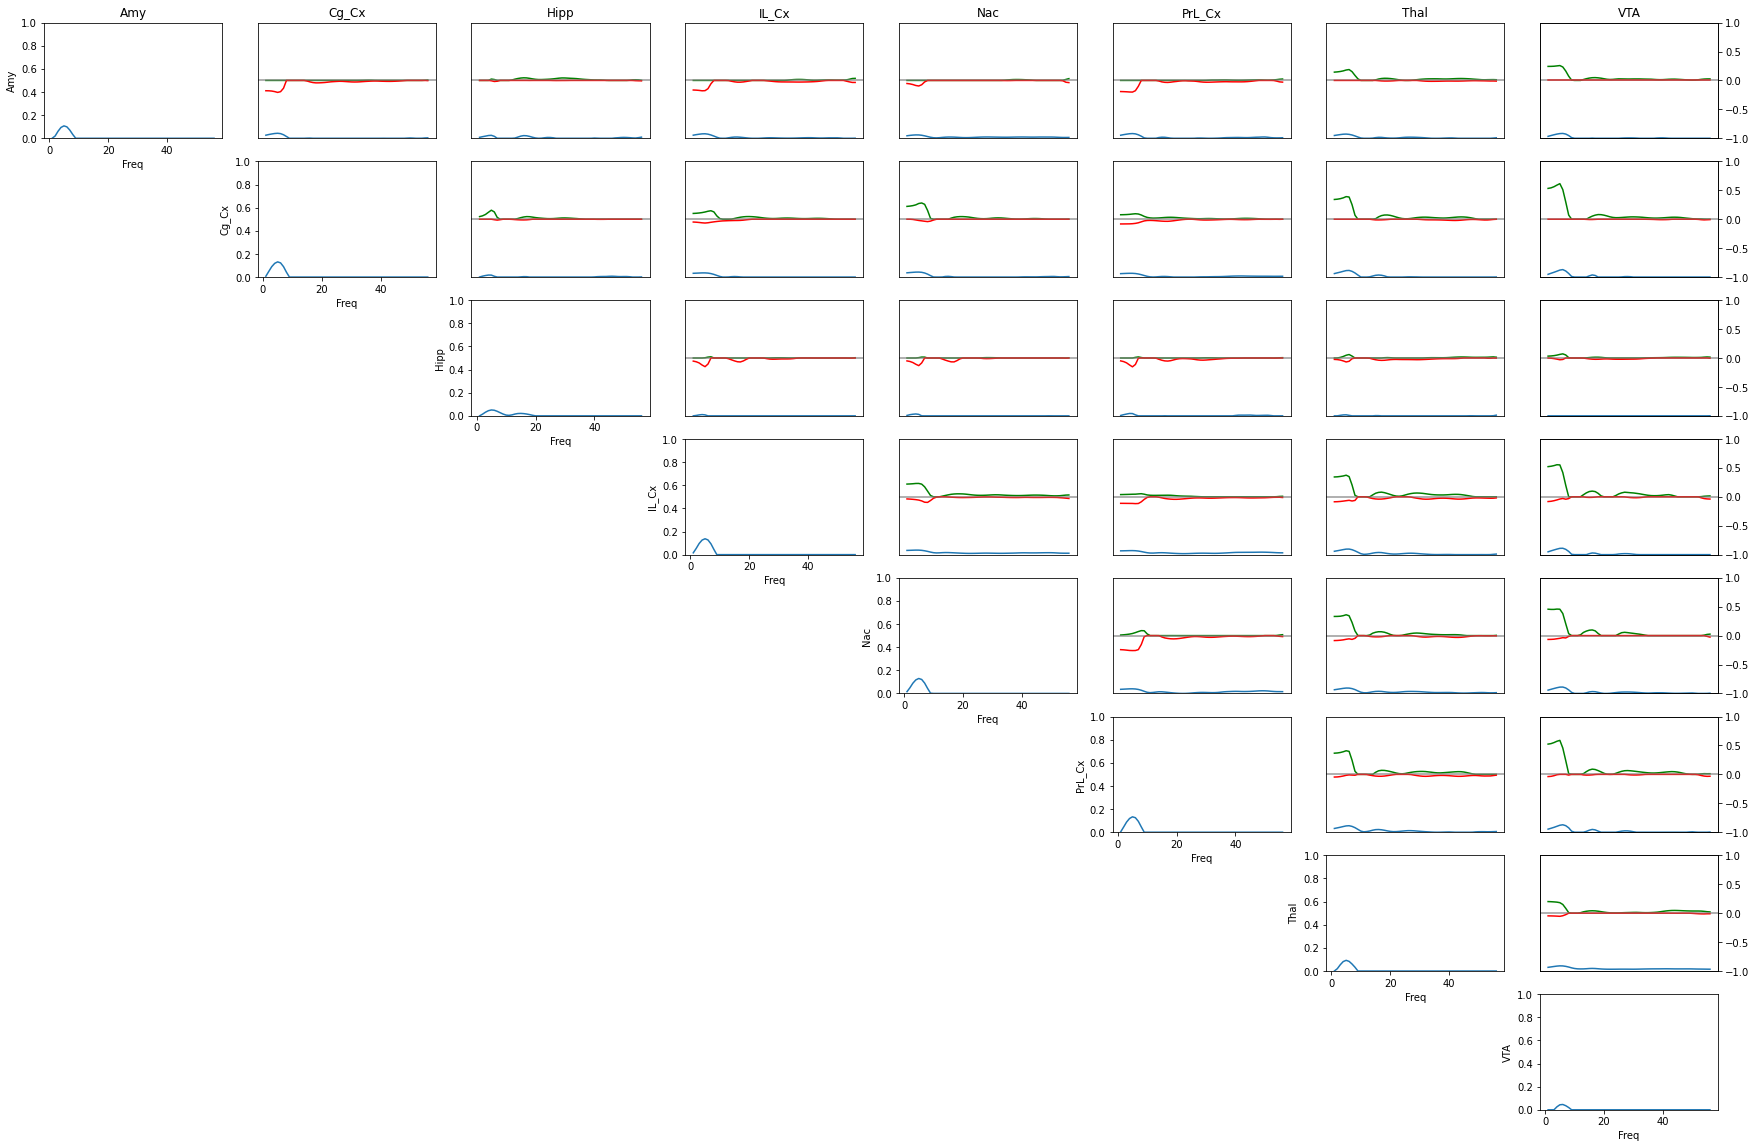

(1, 448) (1, 1568) (1, 3136)


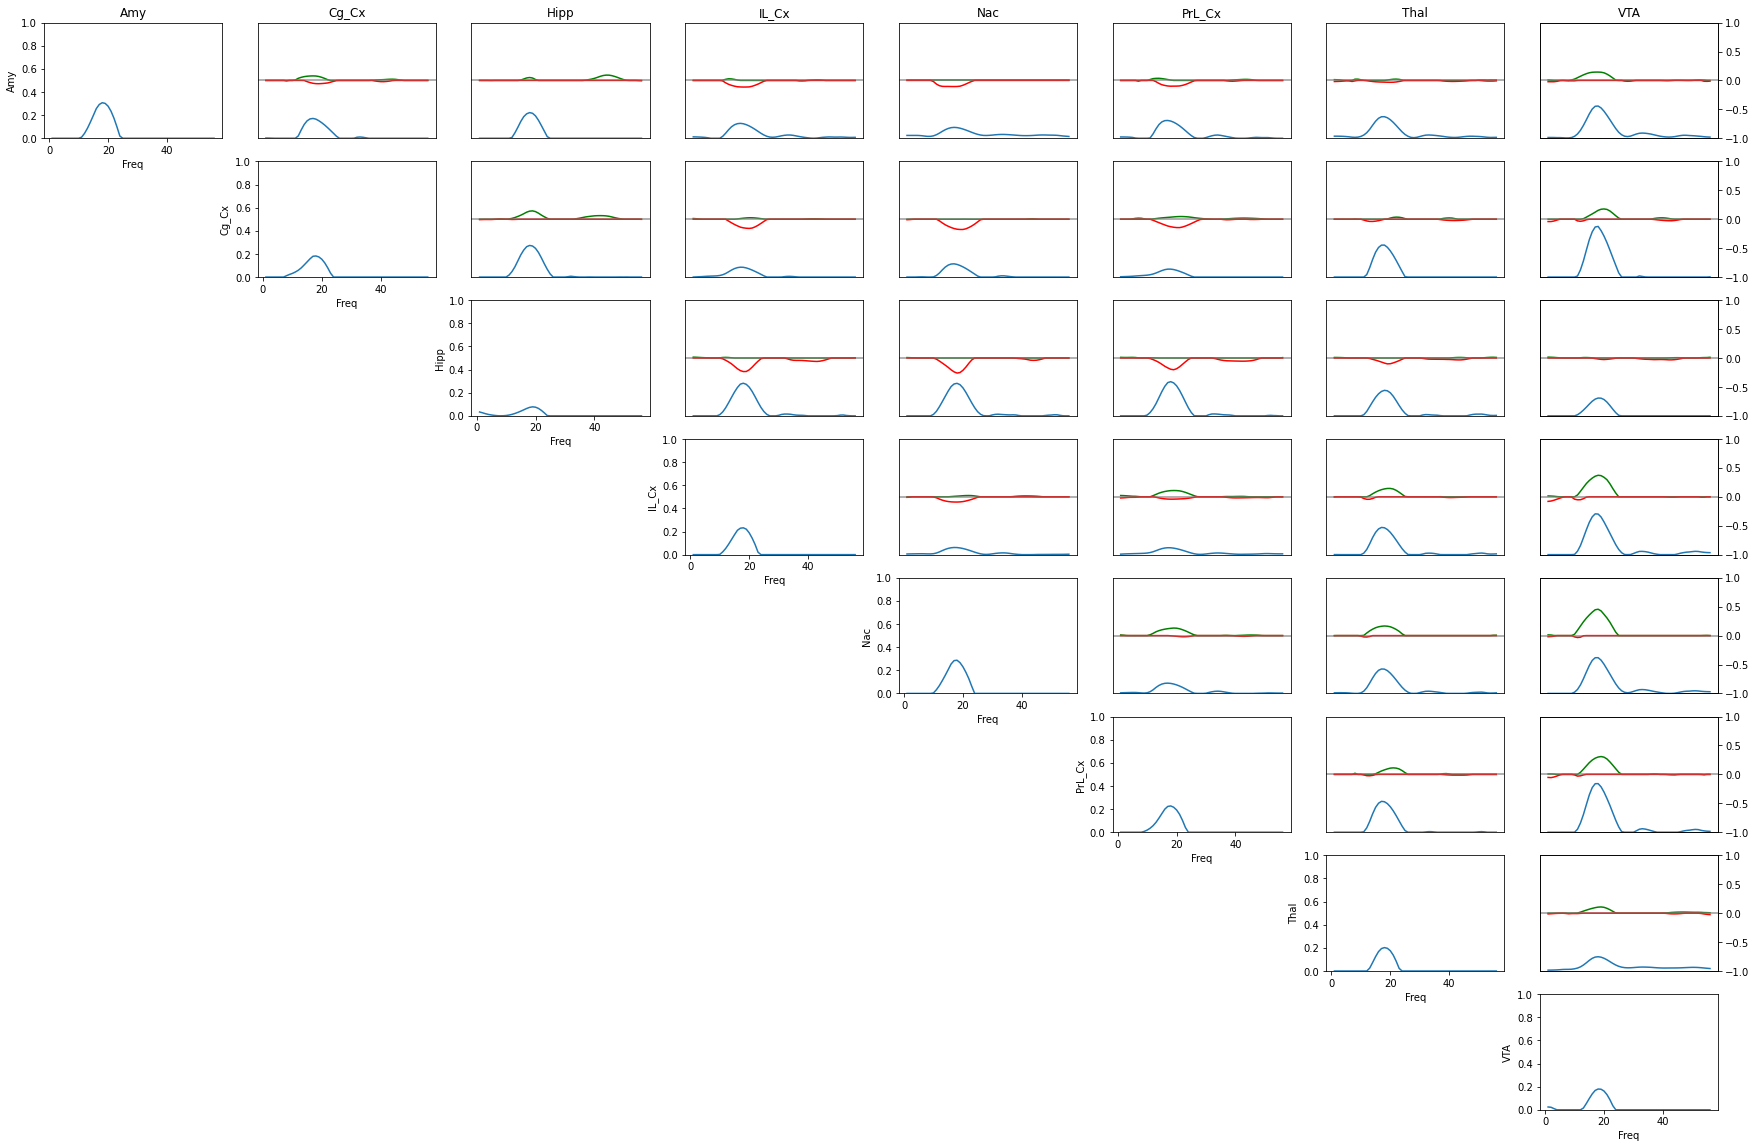

(1, 448) (1, 1568) (1, 3136)


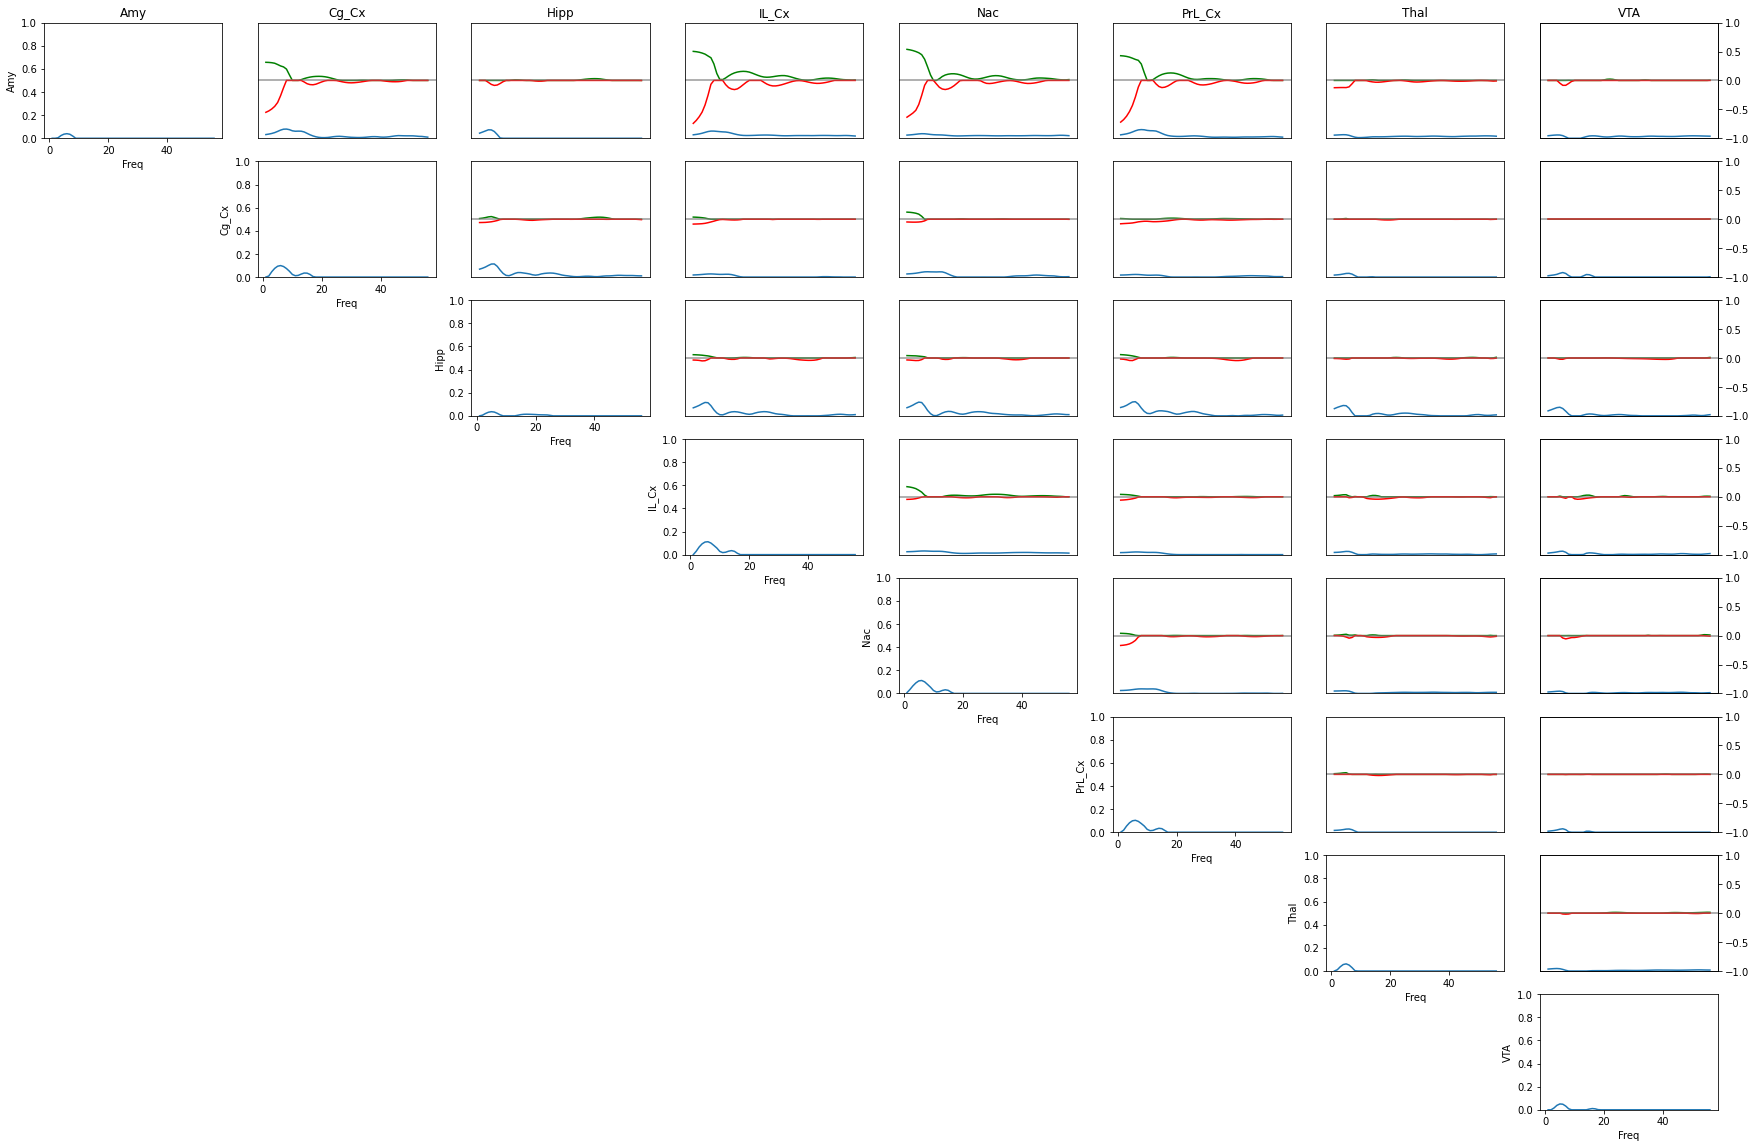

(1, 448) (1, 1568) (1, 3136)


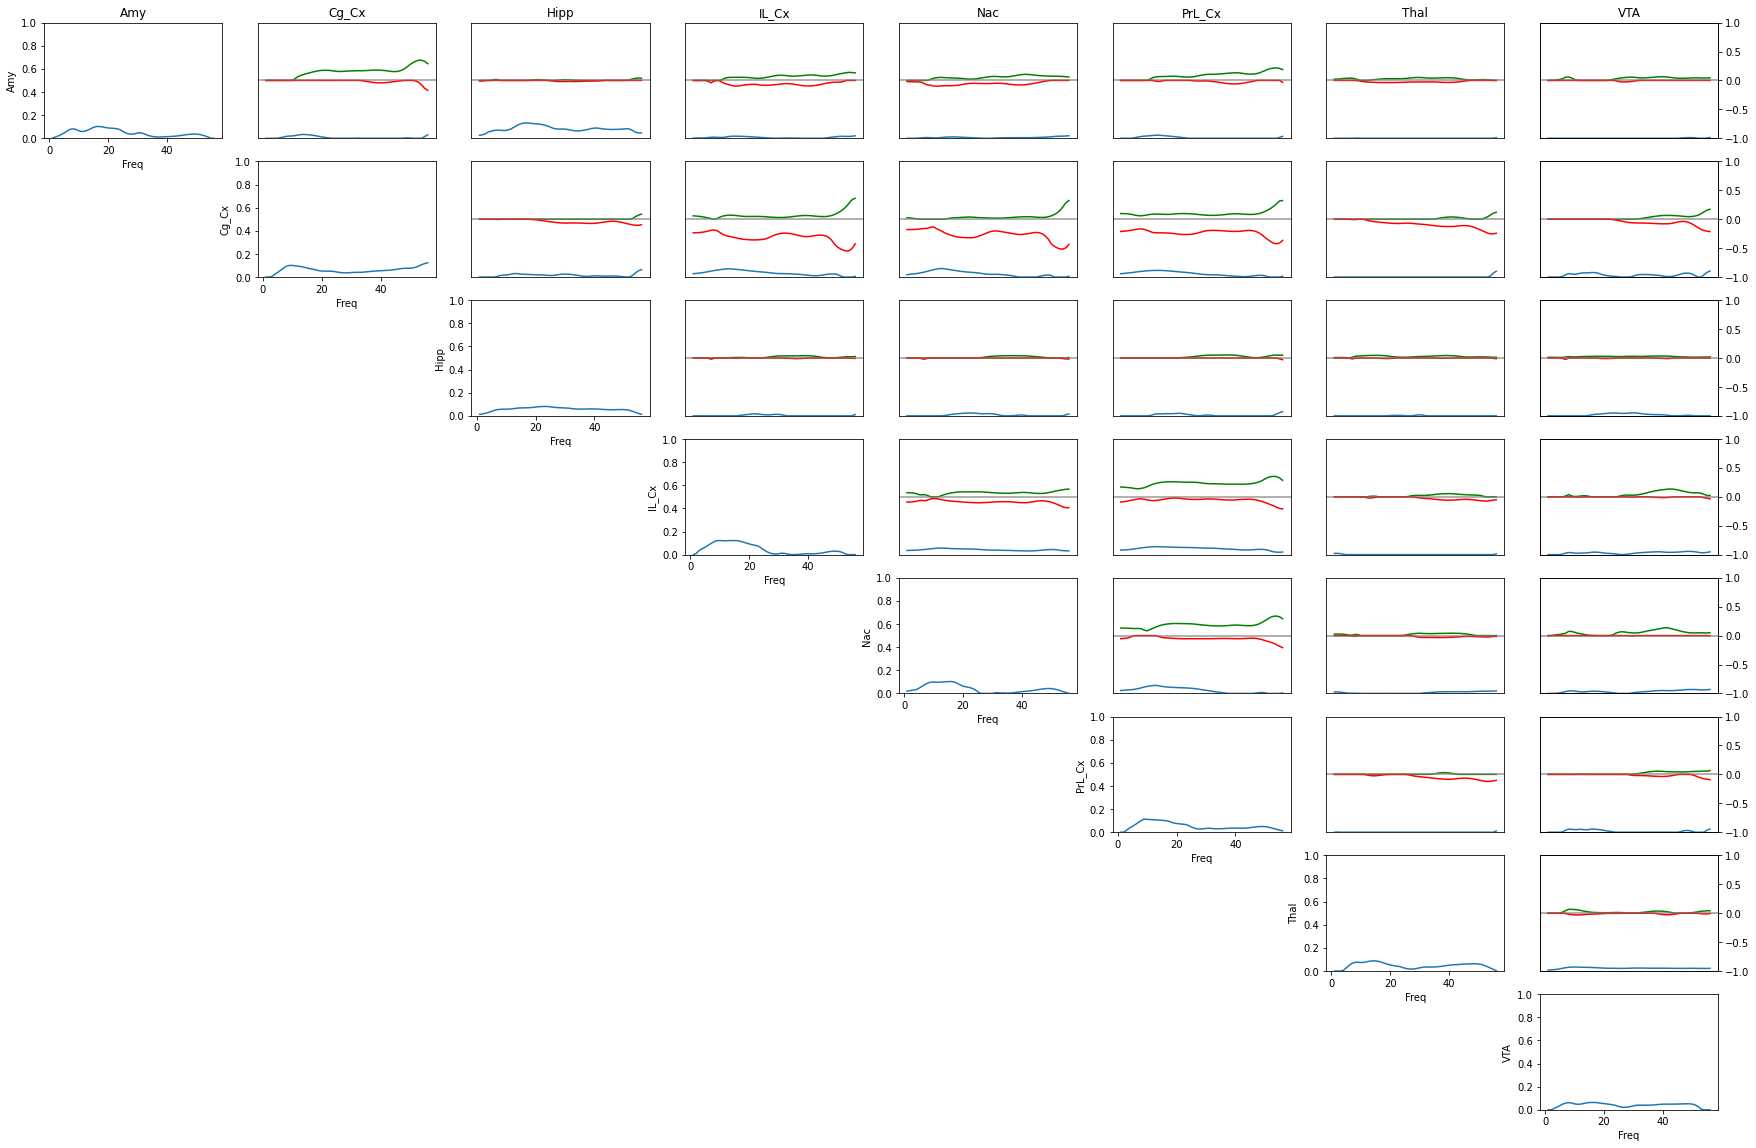

(1, 448) (1, 1568) (1, 3136)


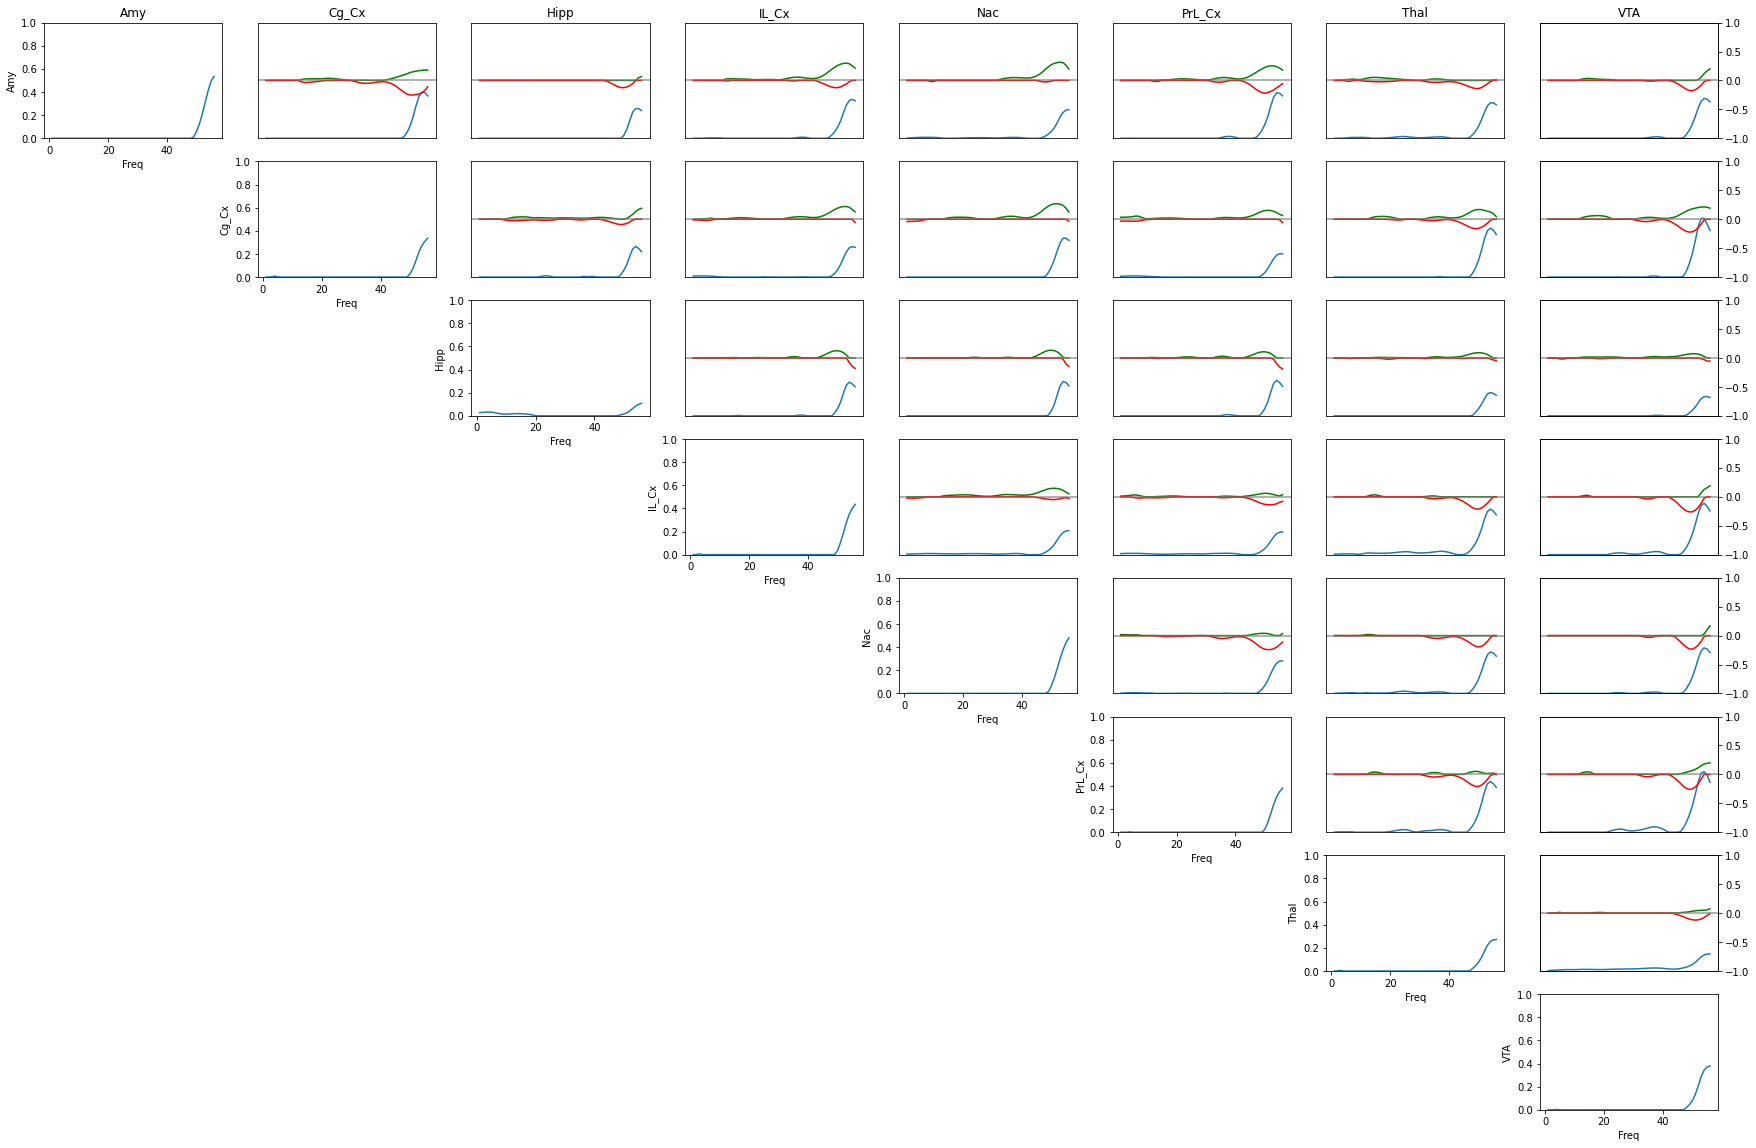

(1, 448) (1, 1568) (1, 3136)


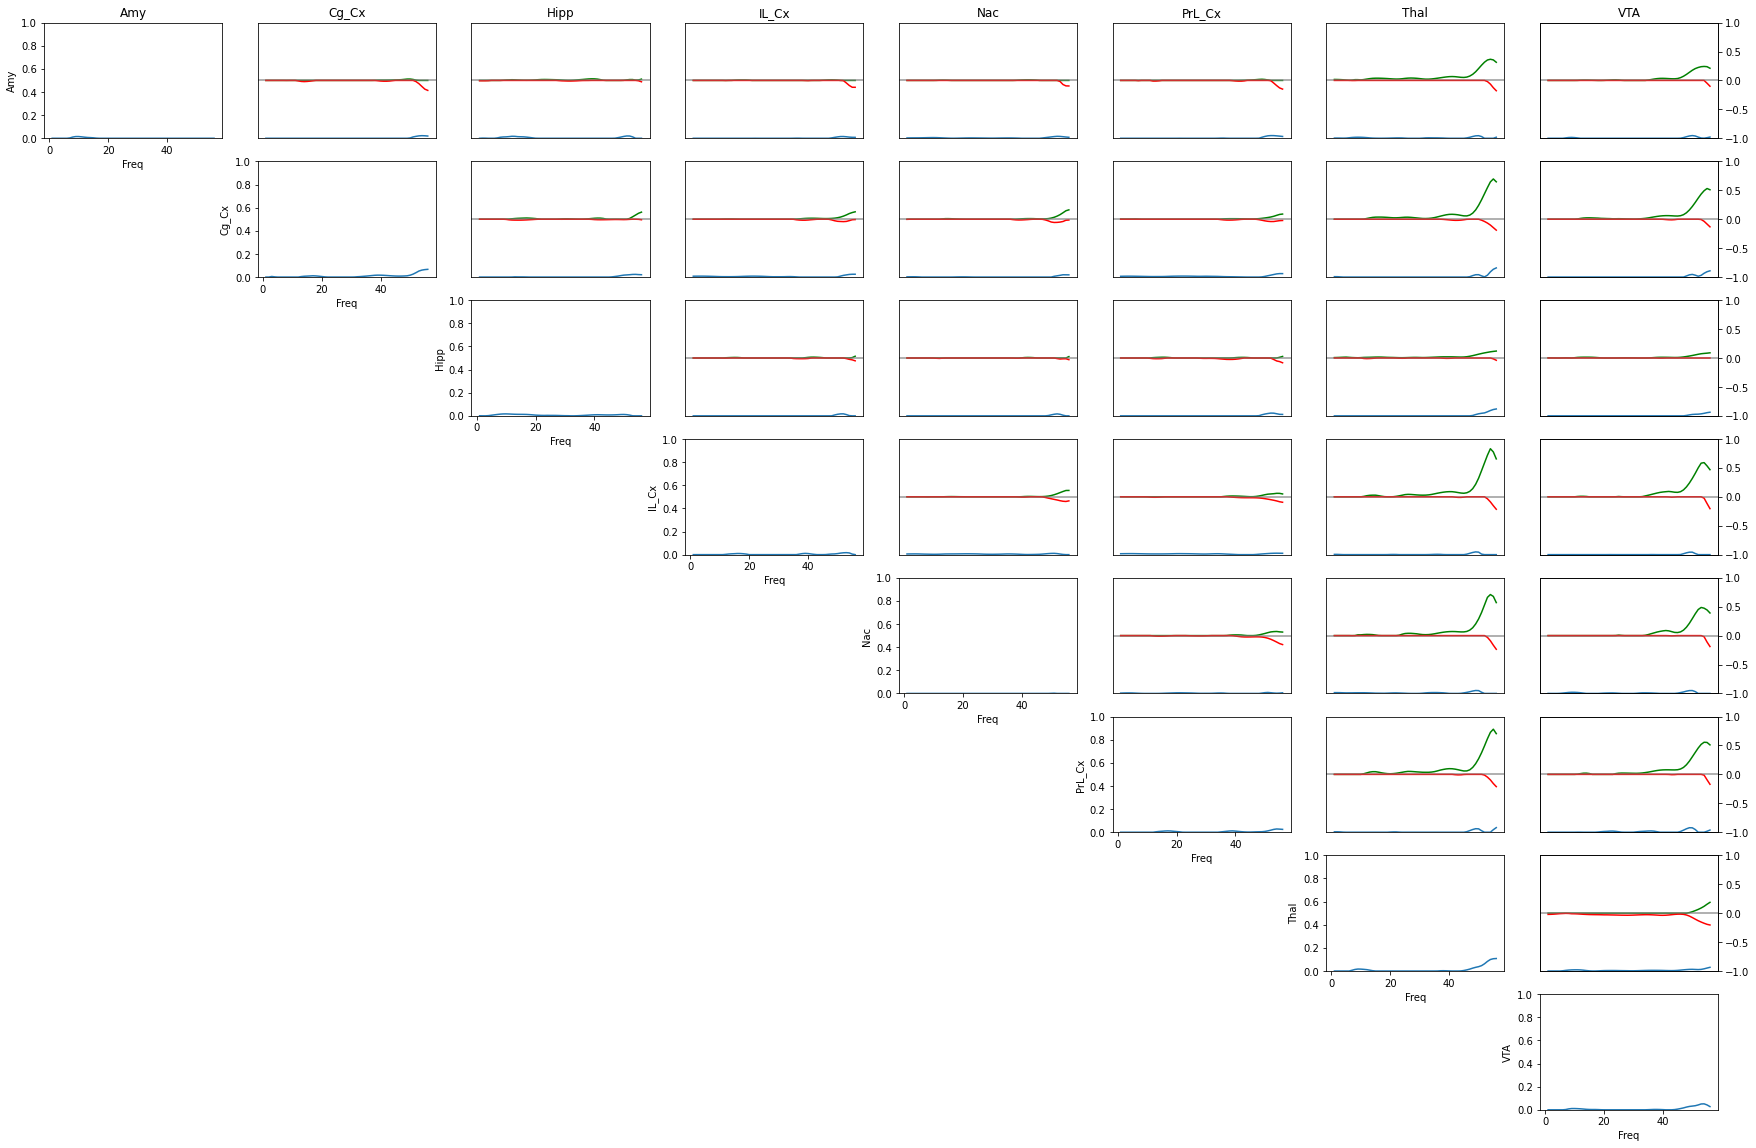

(1, 448) (1, 1568) (1, 3136)


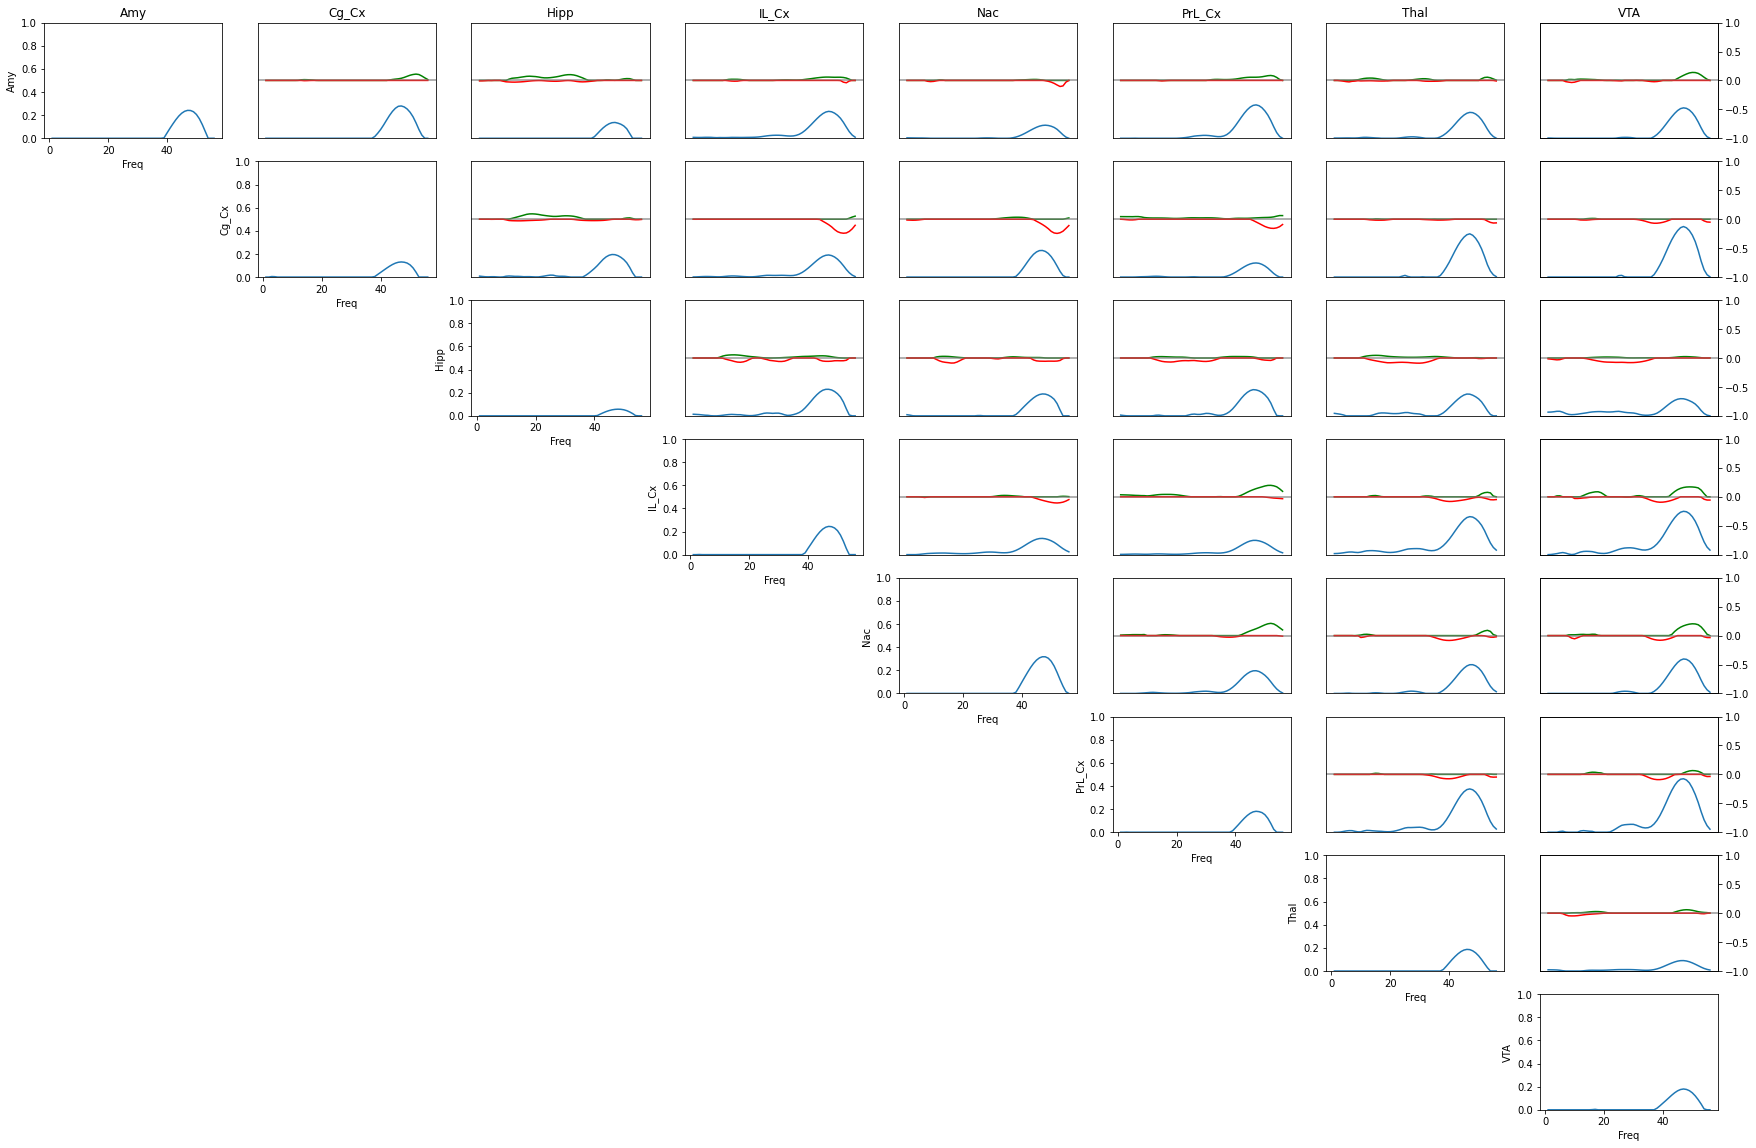

(1, 448) (1, 1568) (1, 3136)


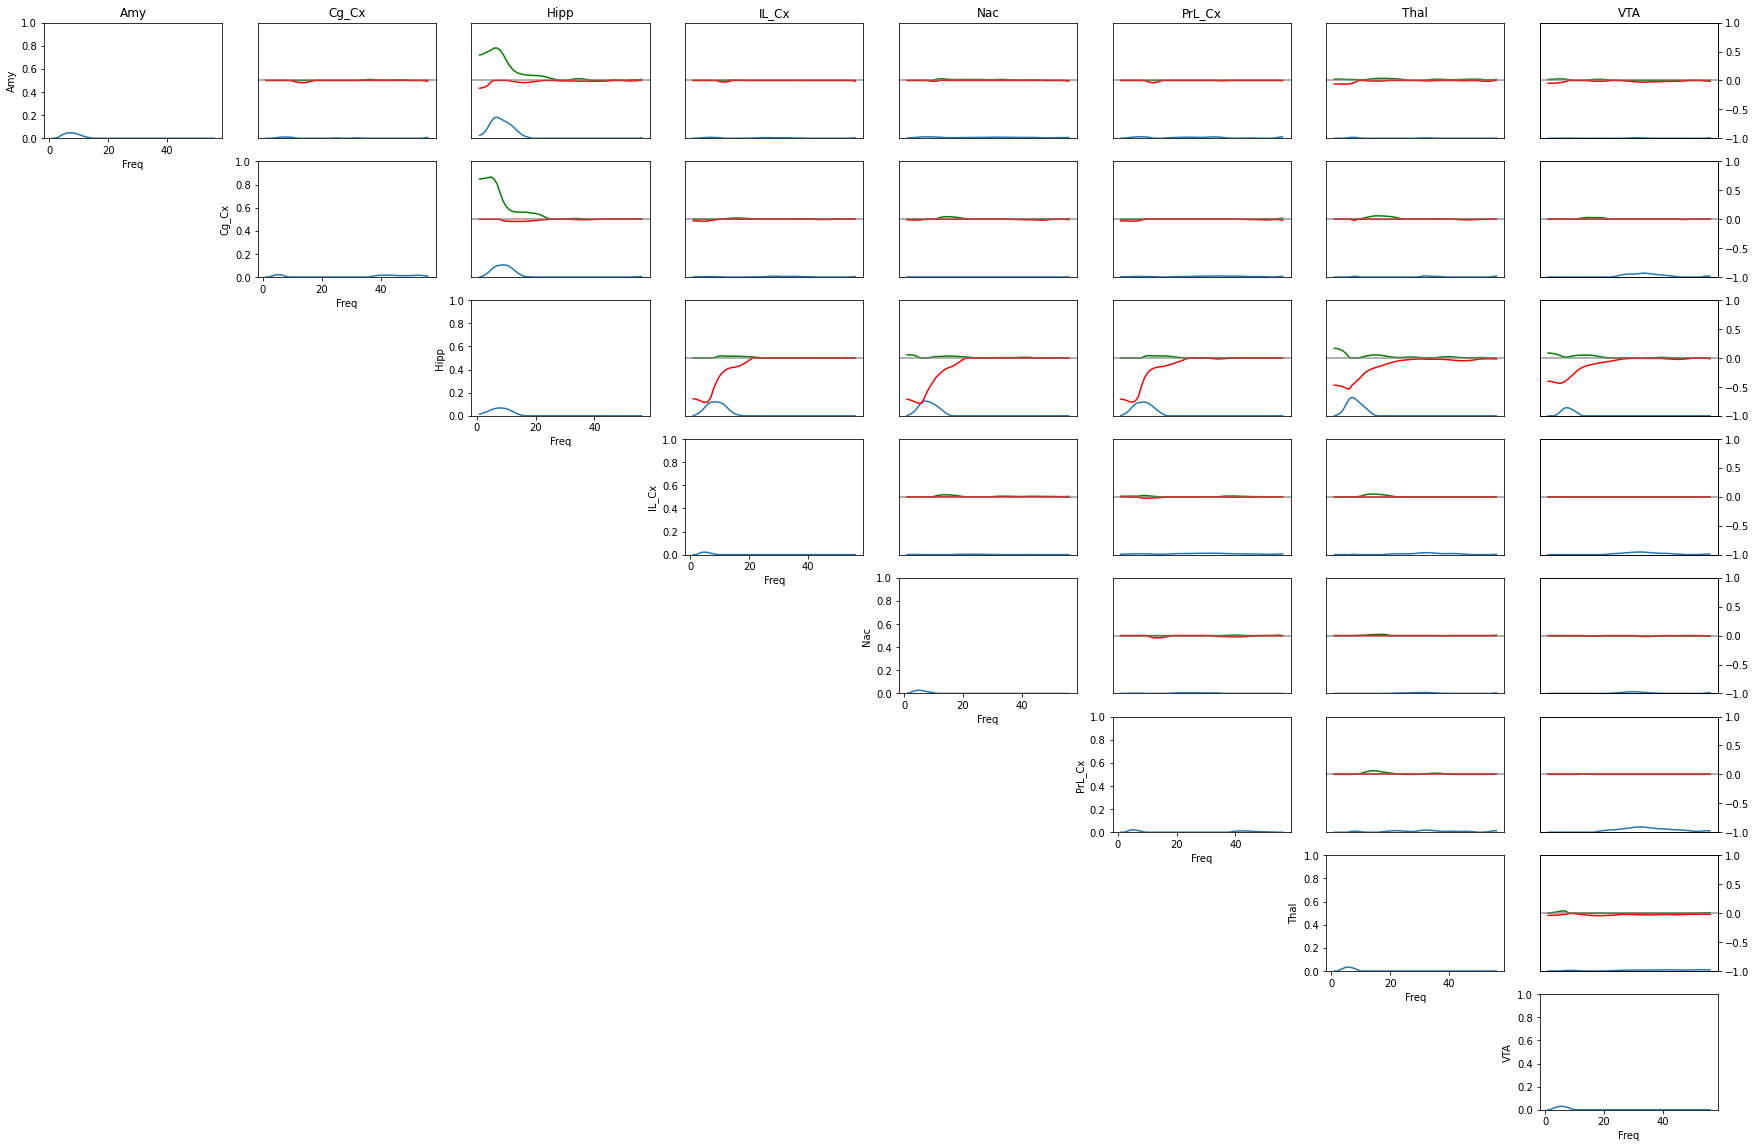

(1, 448) (1, 1568) (1, 3136)


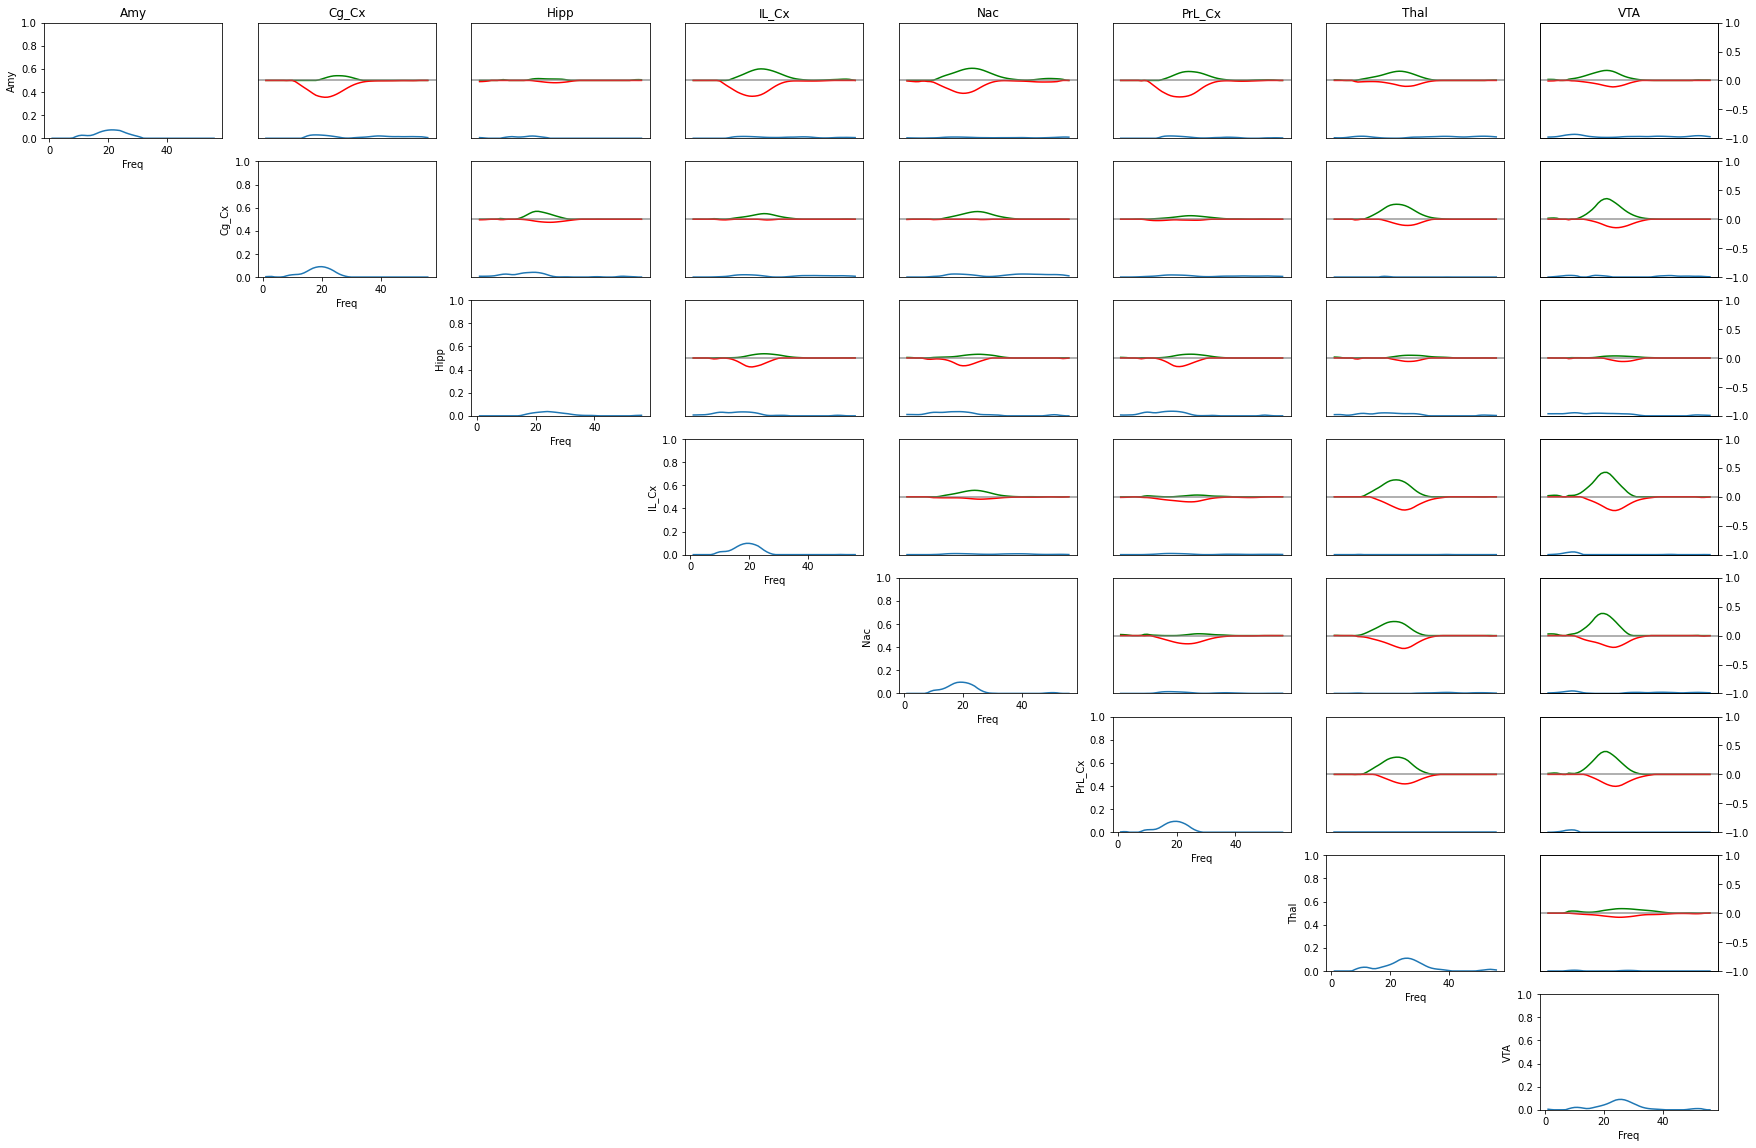

(1, 448) (1, 1568) (1, 3136)


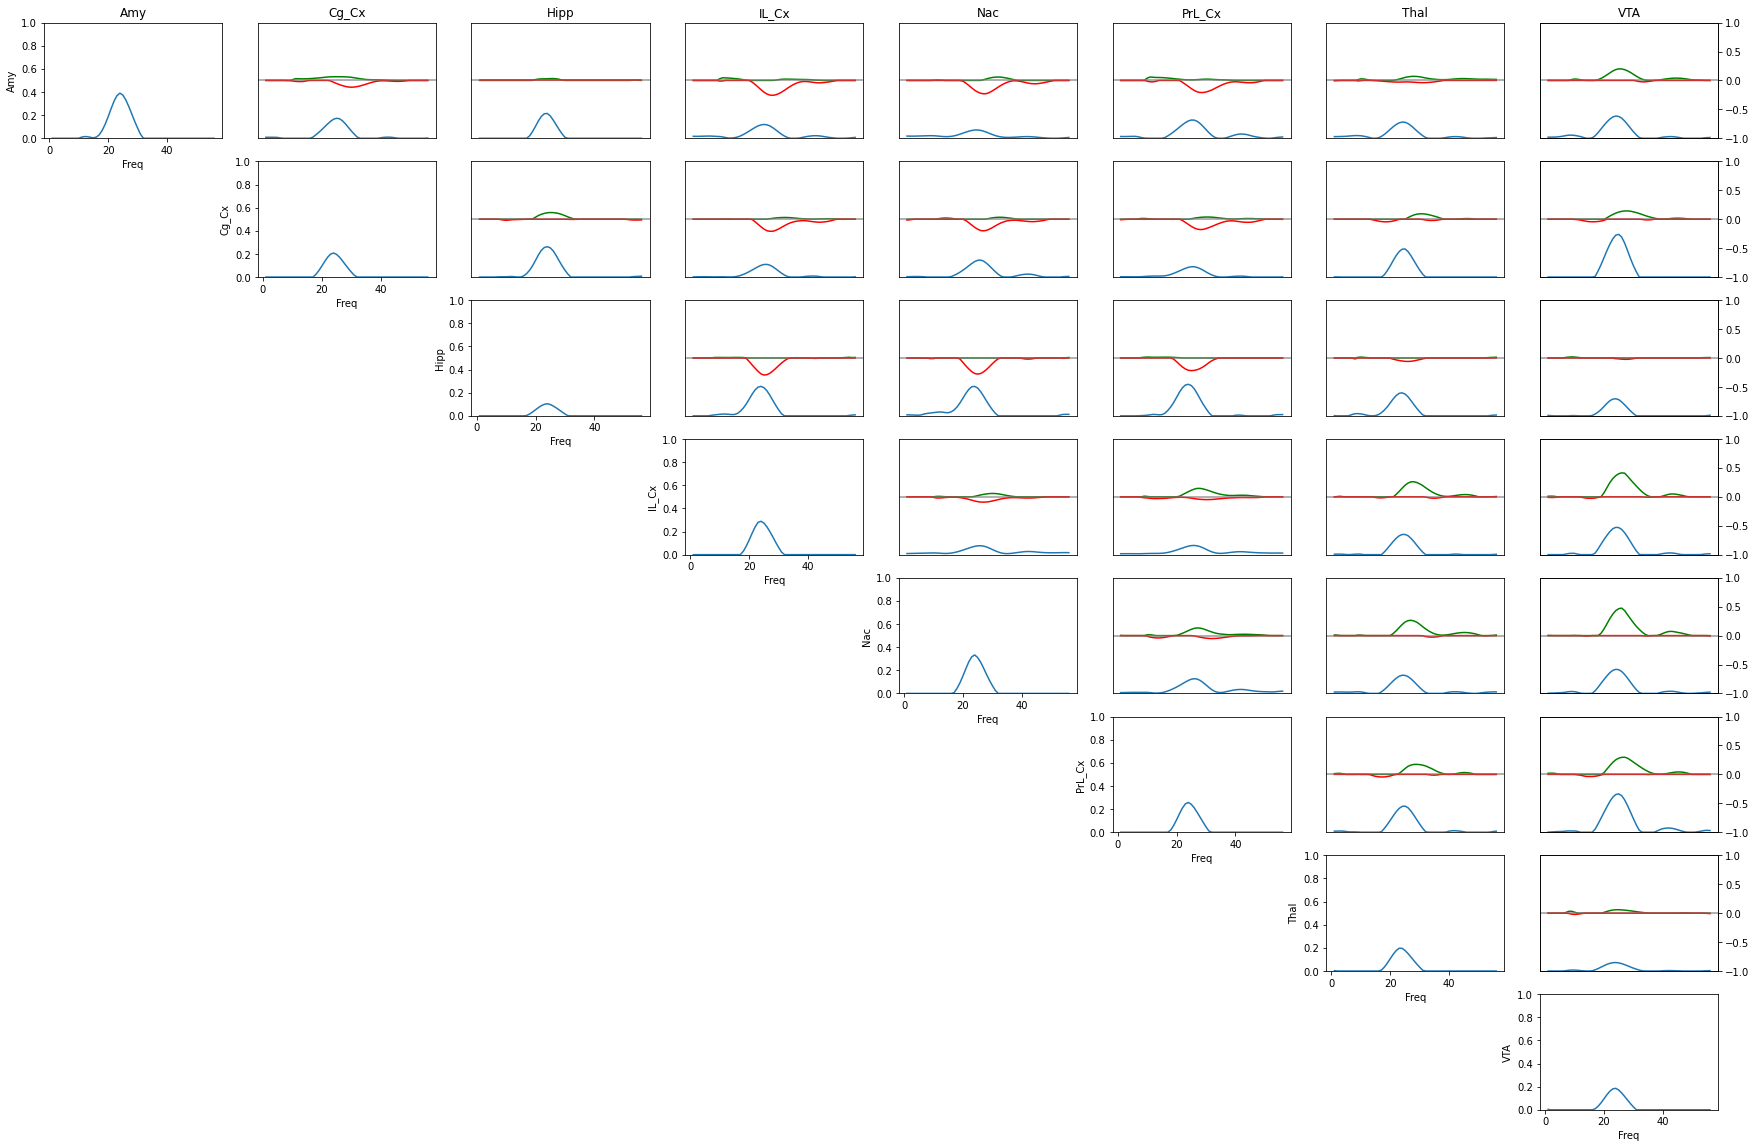

(1, 448) (1, 1568) (1, 3136)


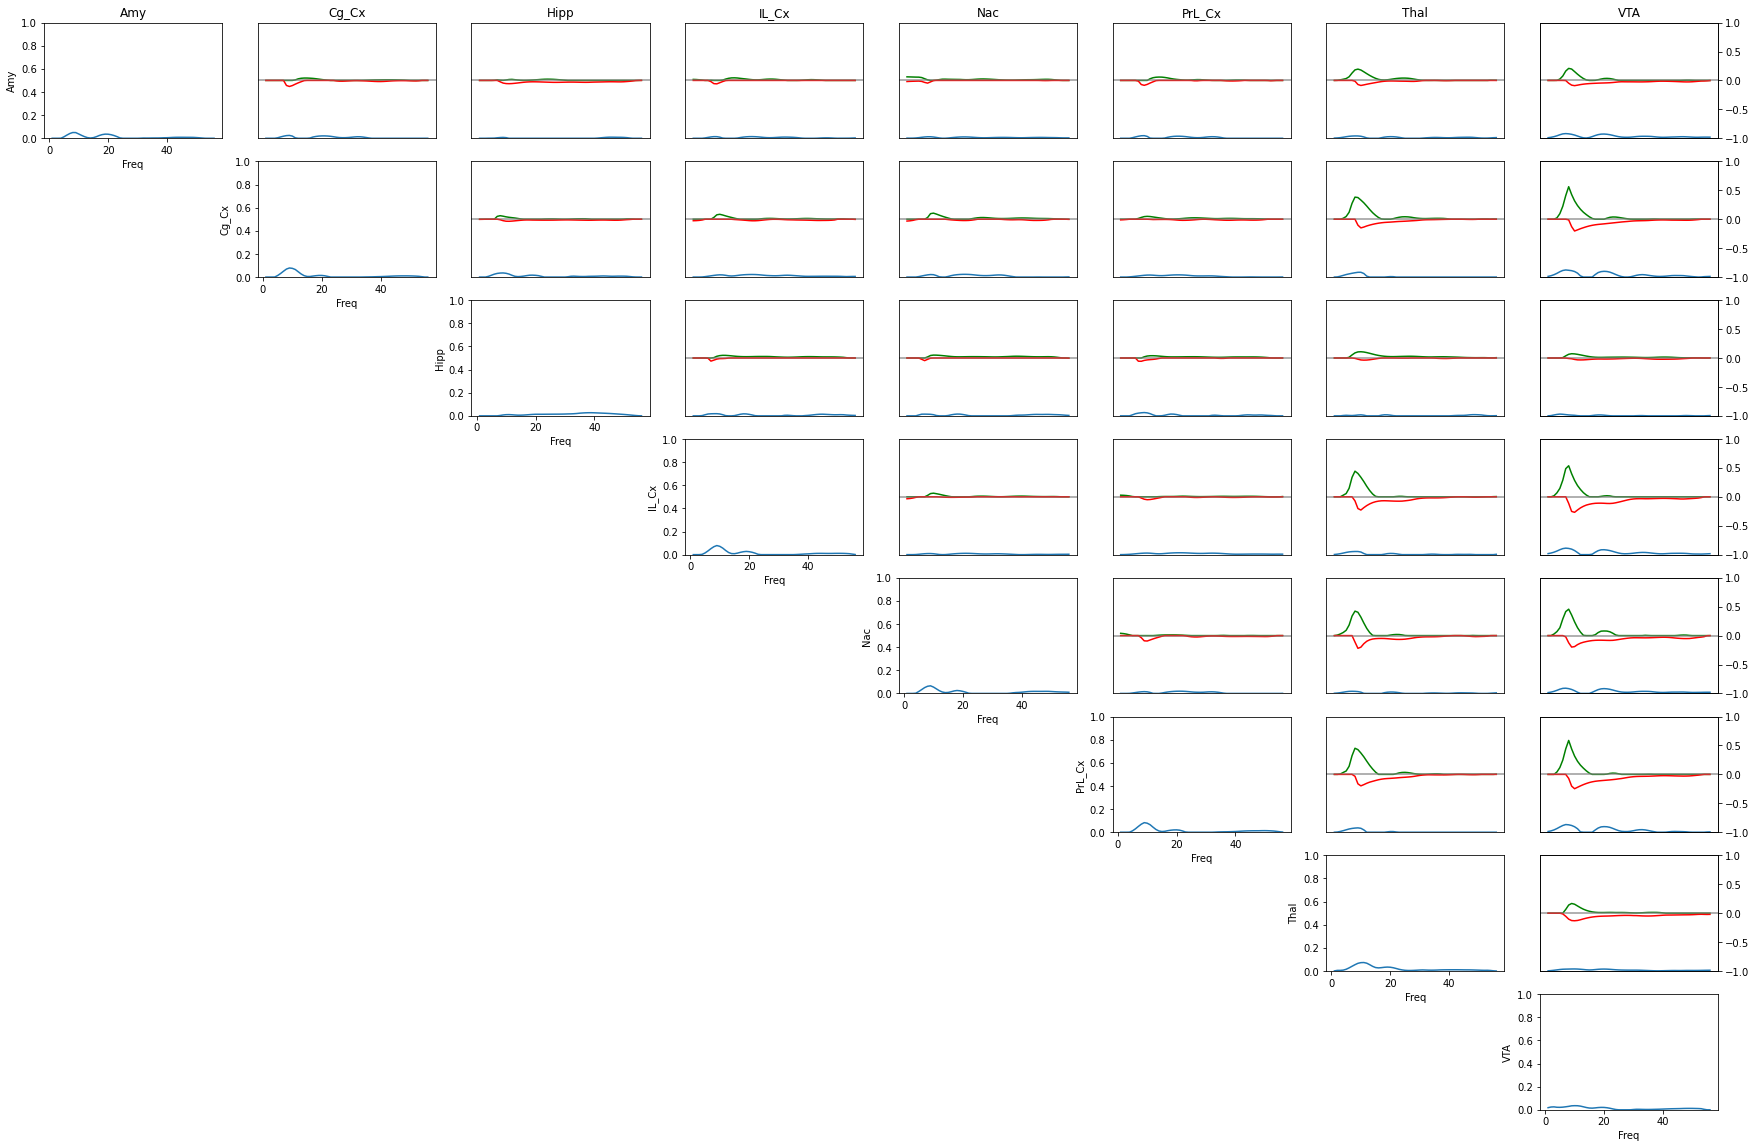

(1, 448) (1, 1568) (1, 3136)


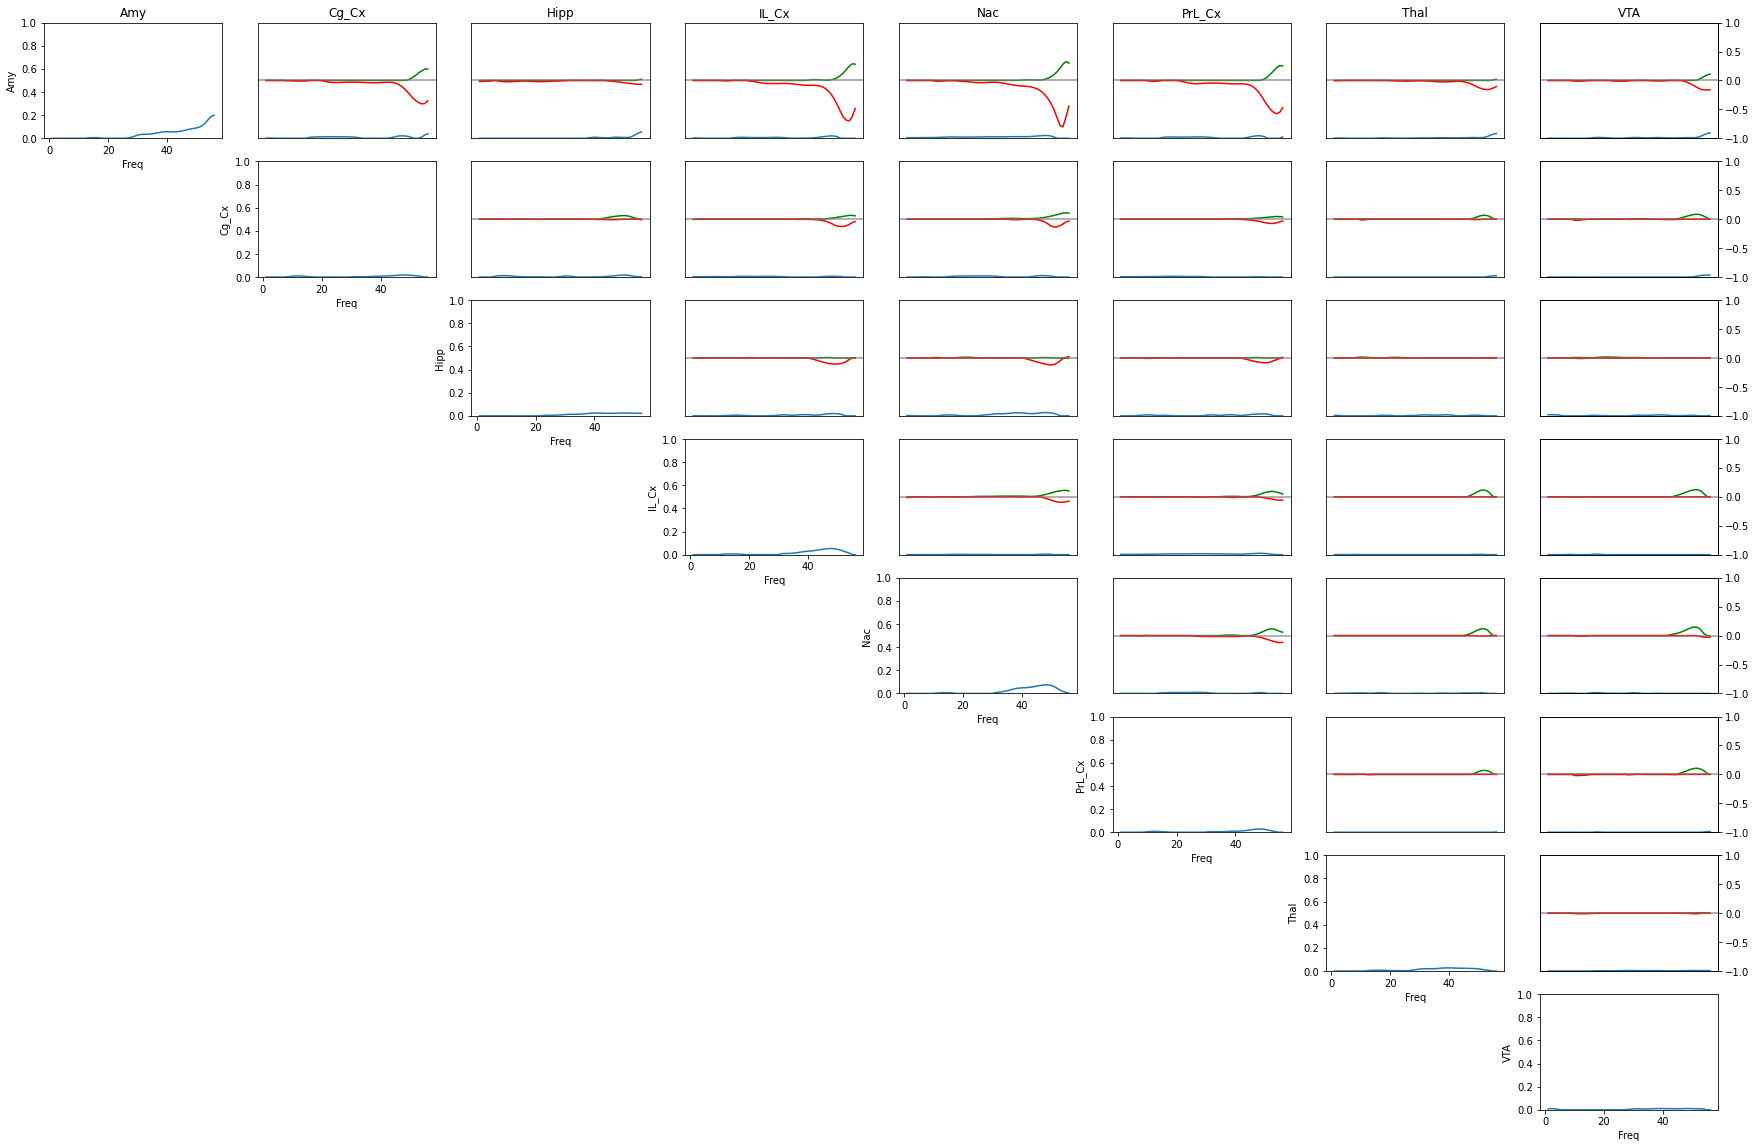

(1, 448) (1, 1568) (1, 3136)


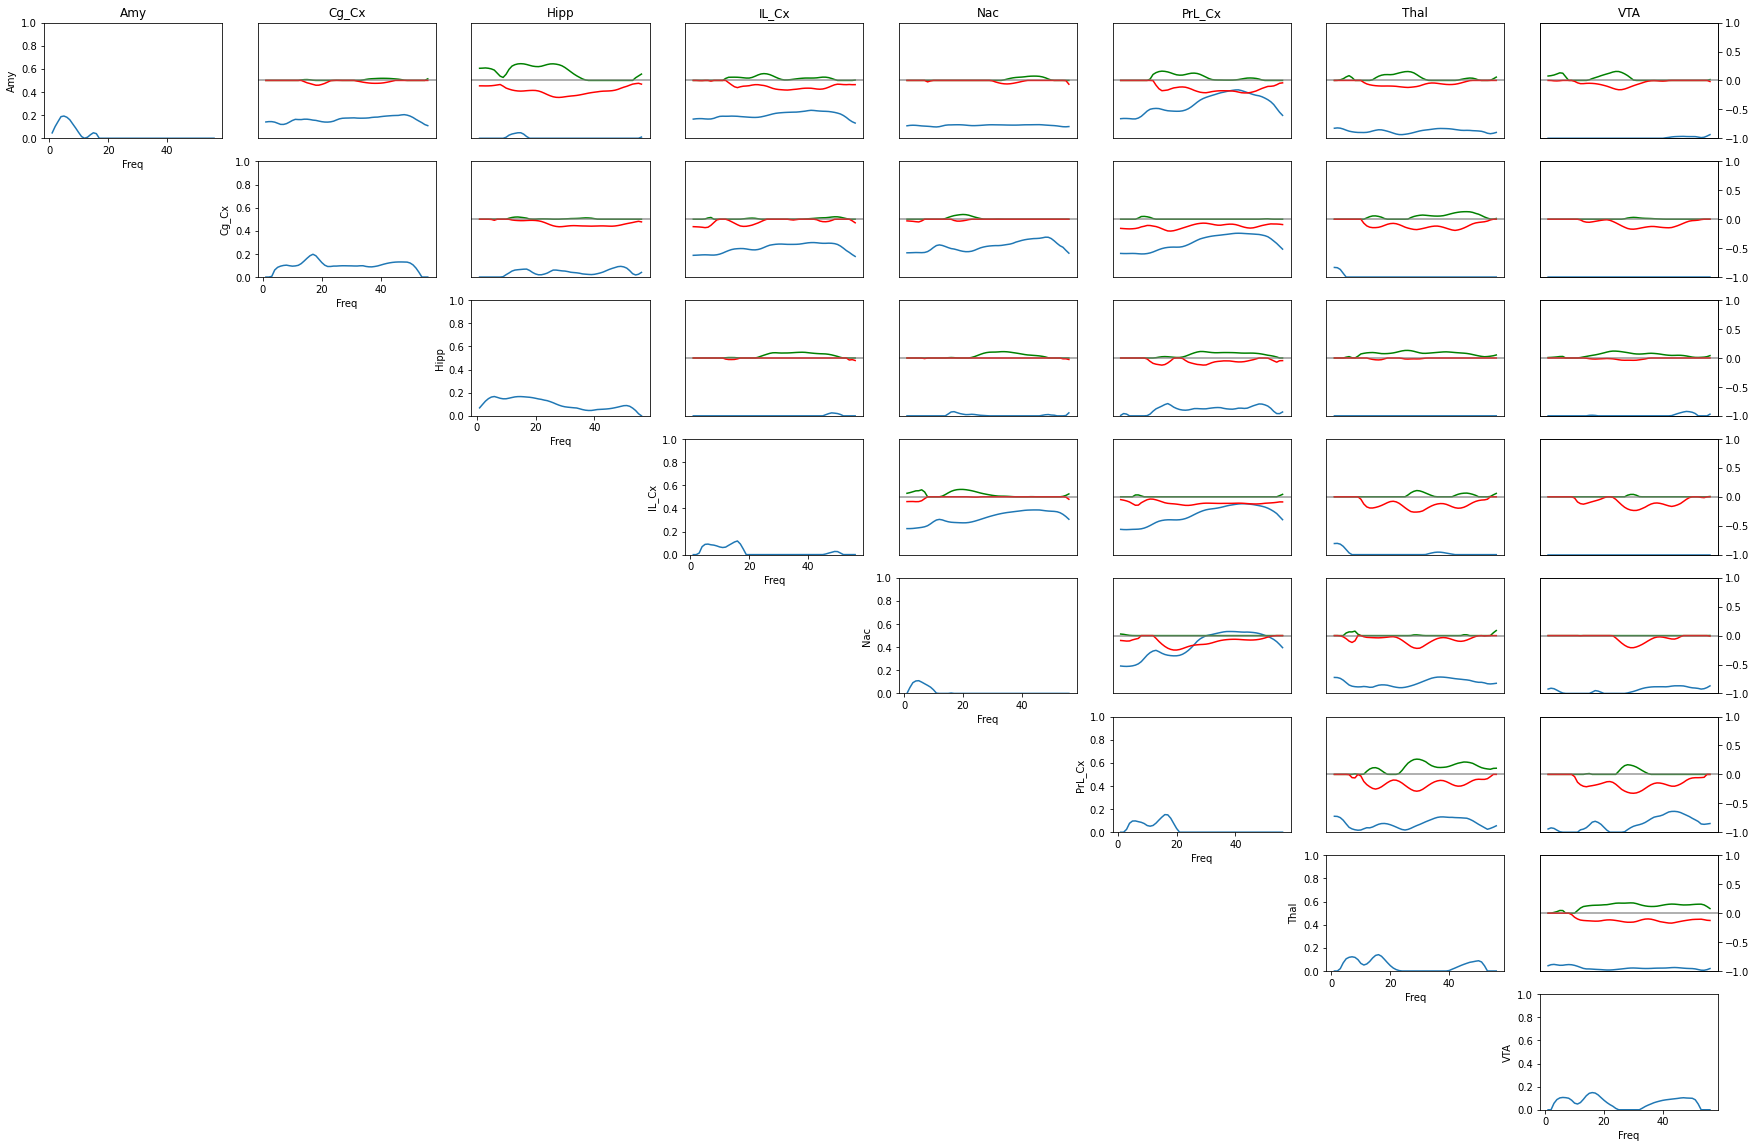

(1, 448) (1, 1568) (1, 3136)


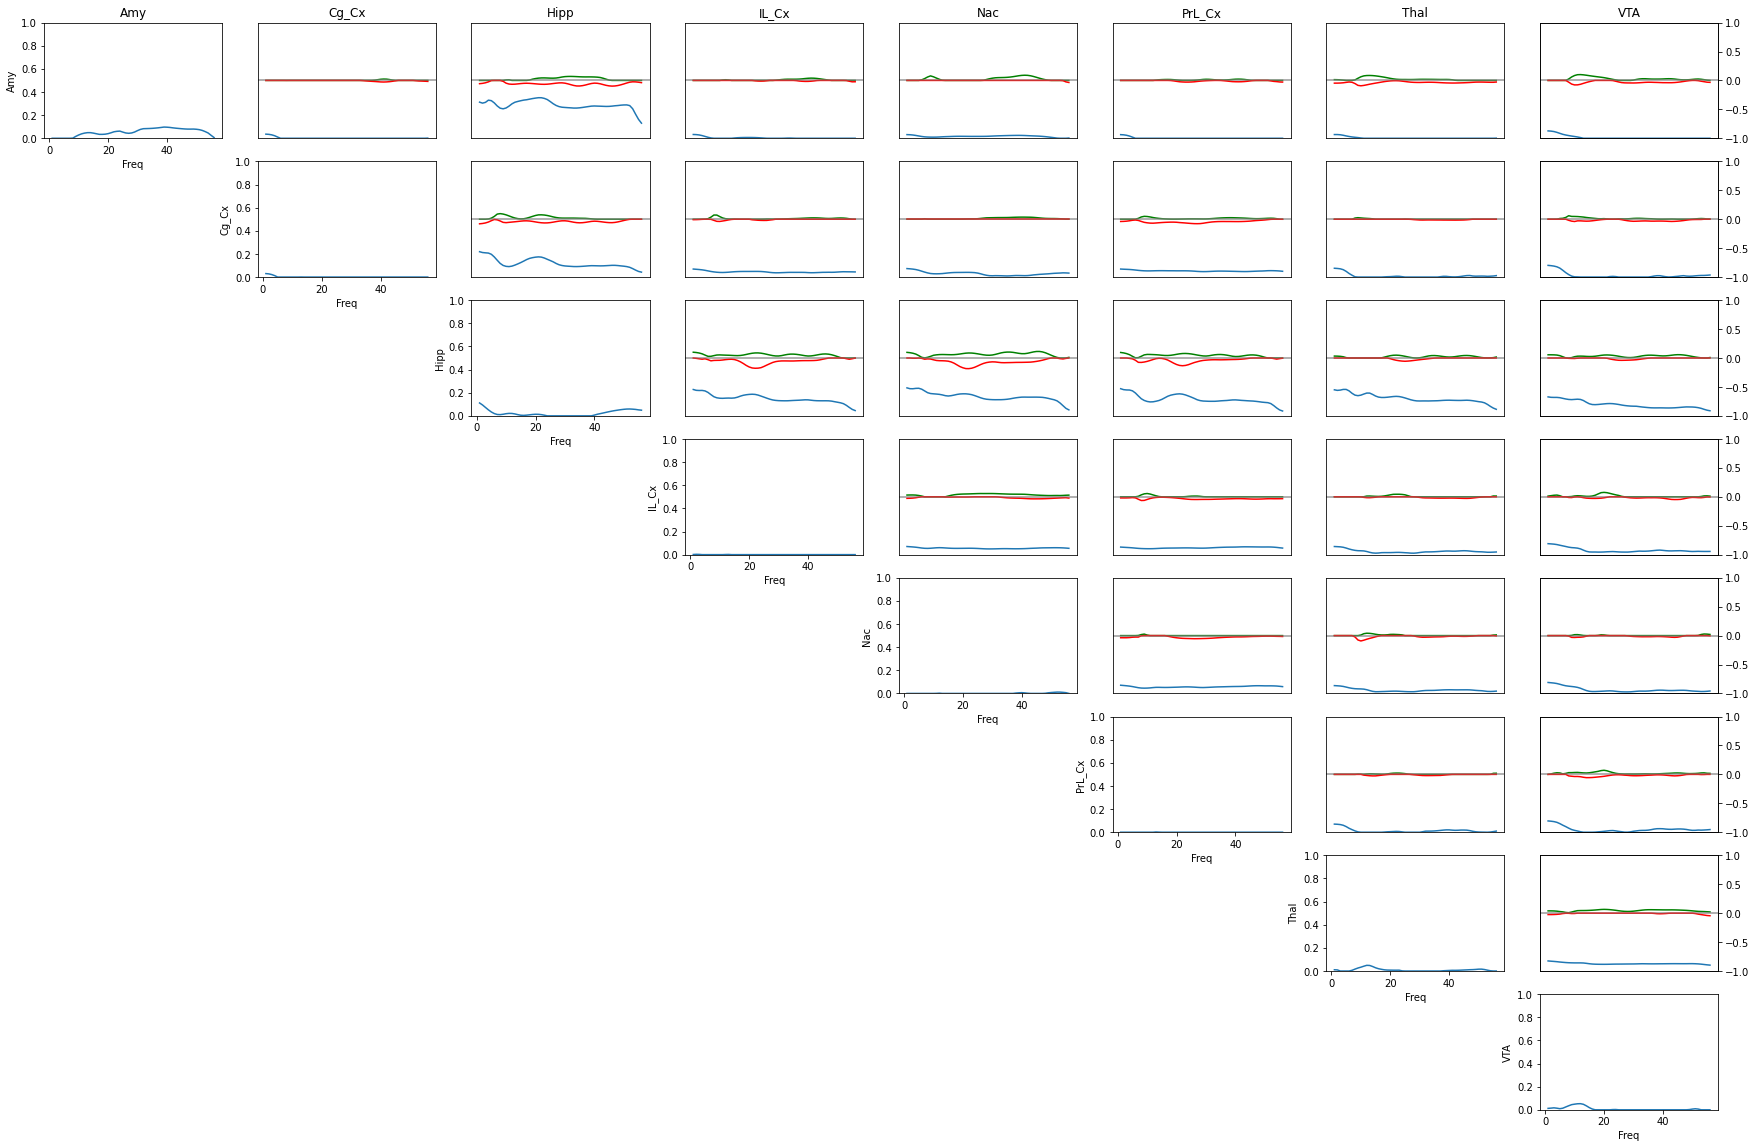

(1, 448) (1, 1568) (1, 3136)


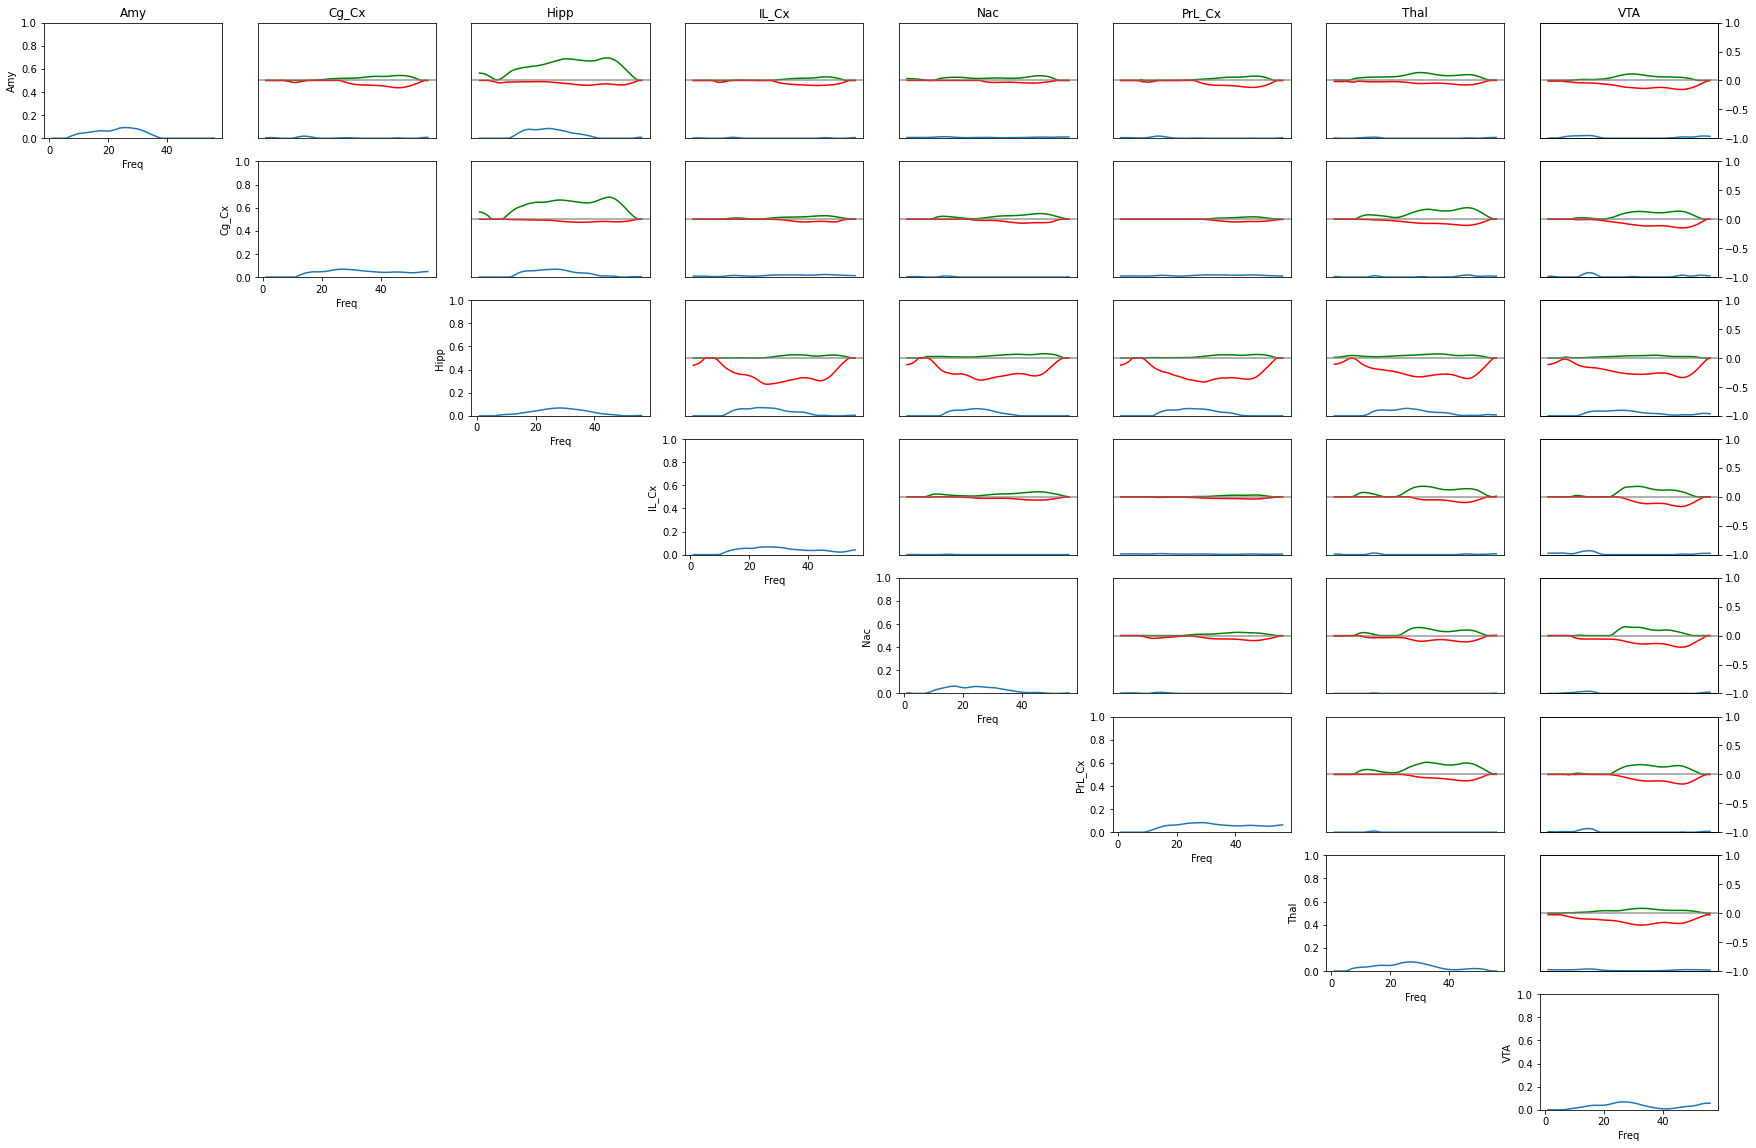

(1, 448) (1, 1568) (1, 3136)


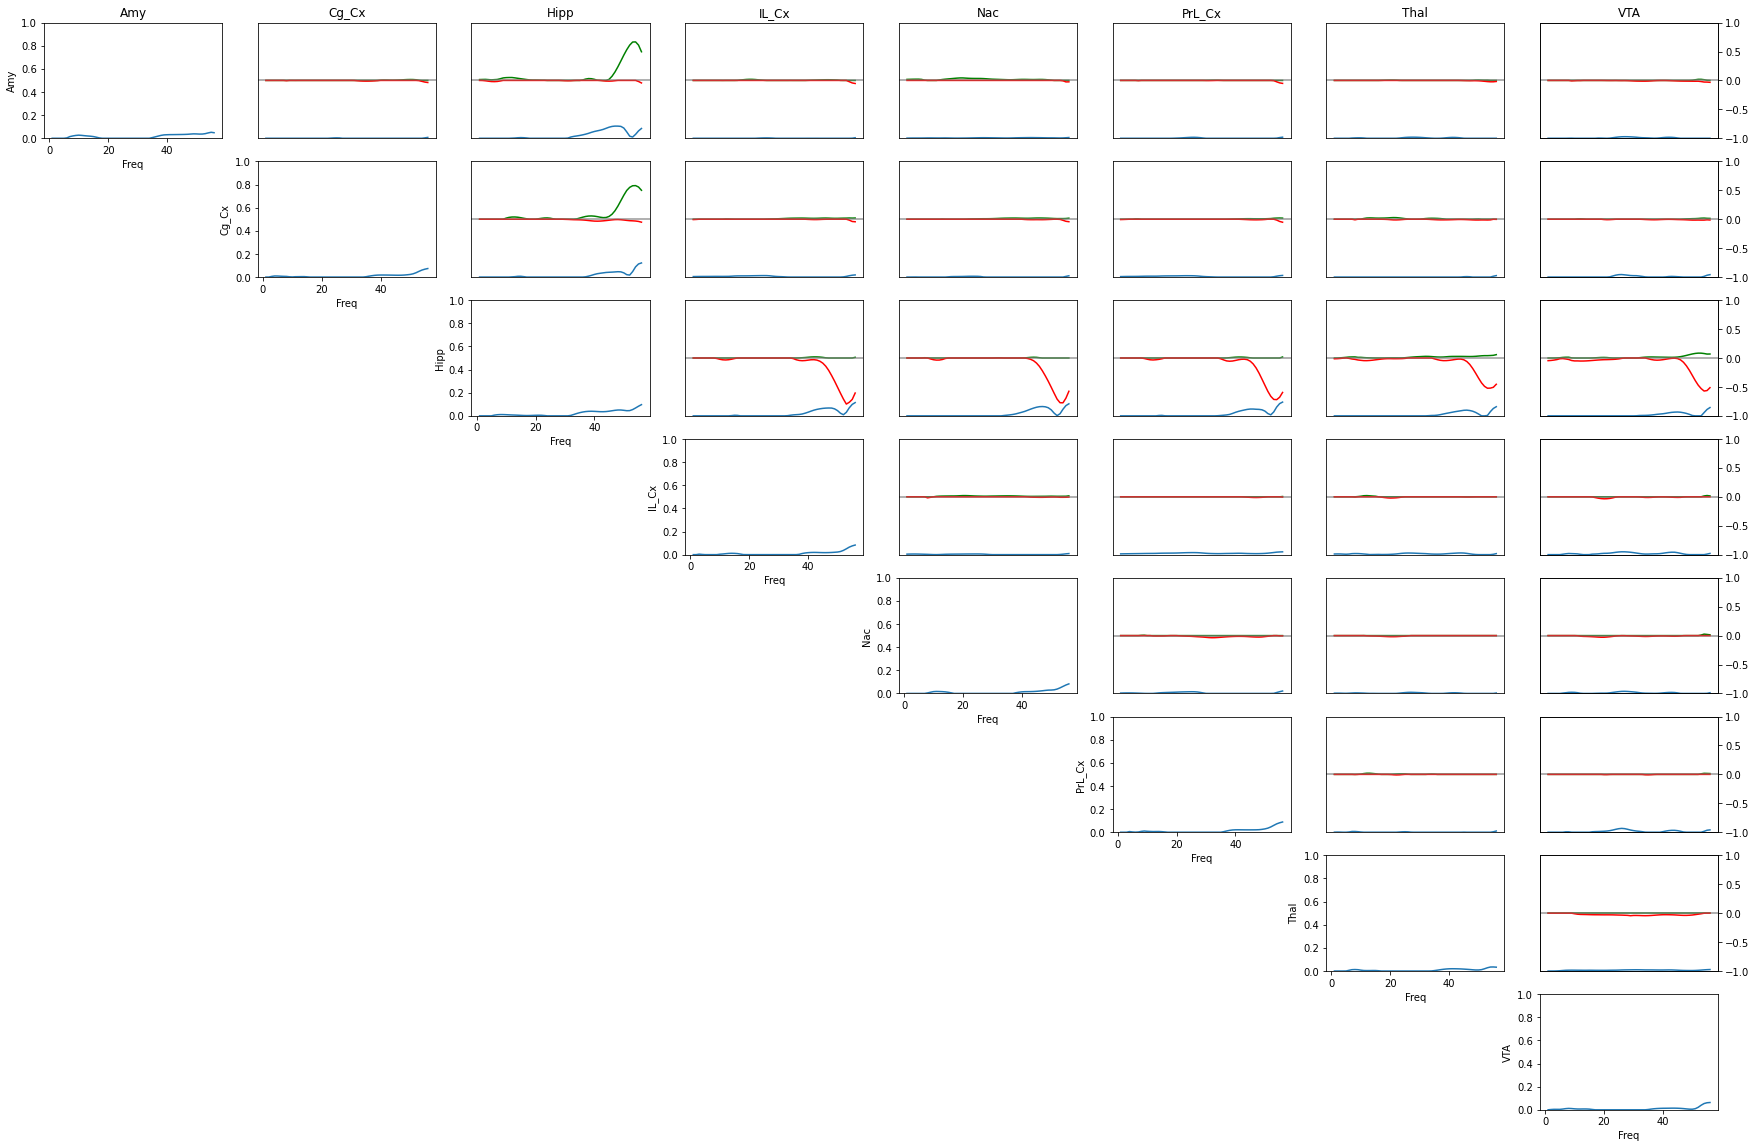

(1, 448) (1, 1568) (1, 3136)


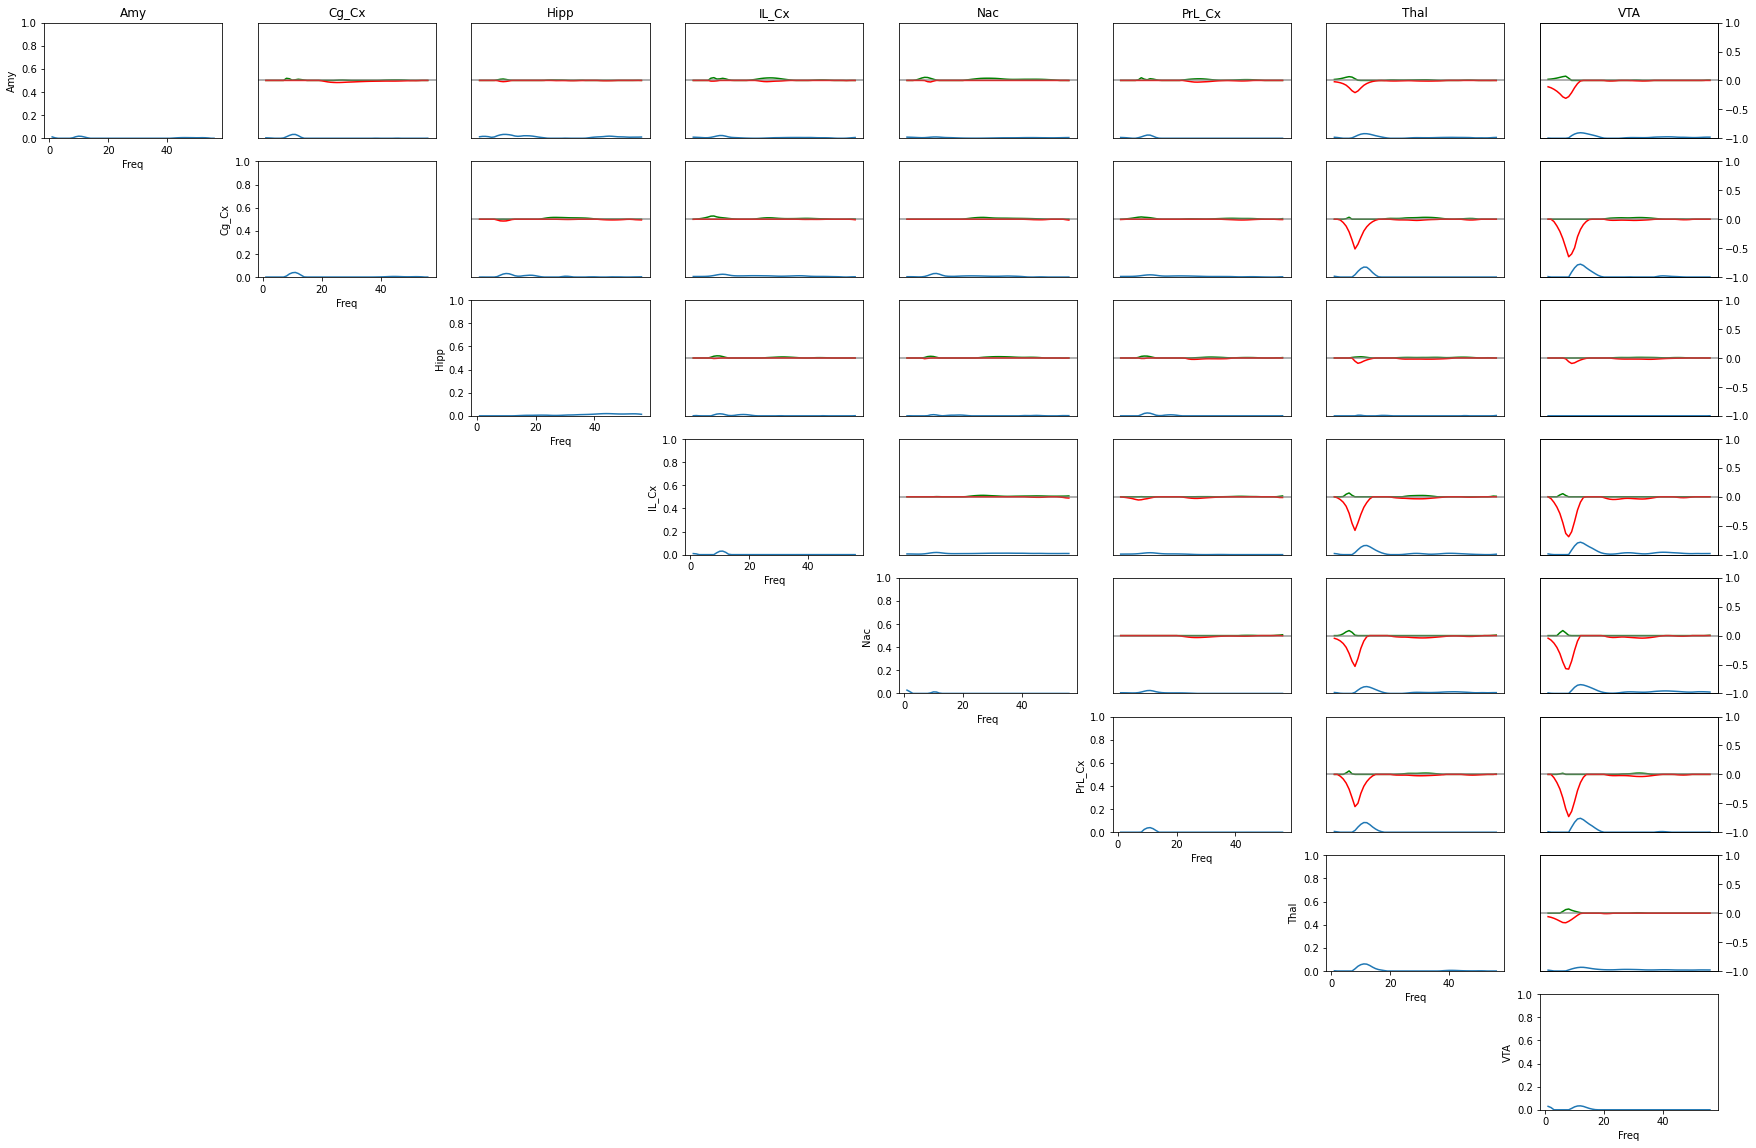

(1, 448) (1, 1568) (1, 3136)


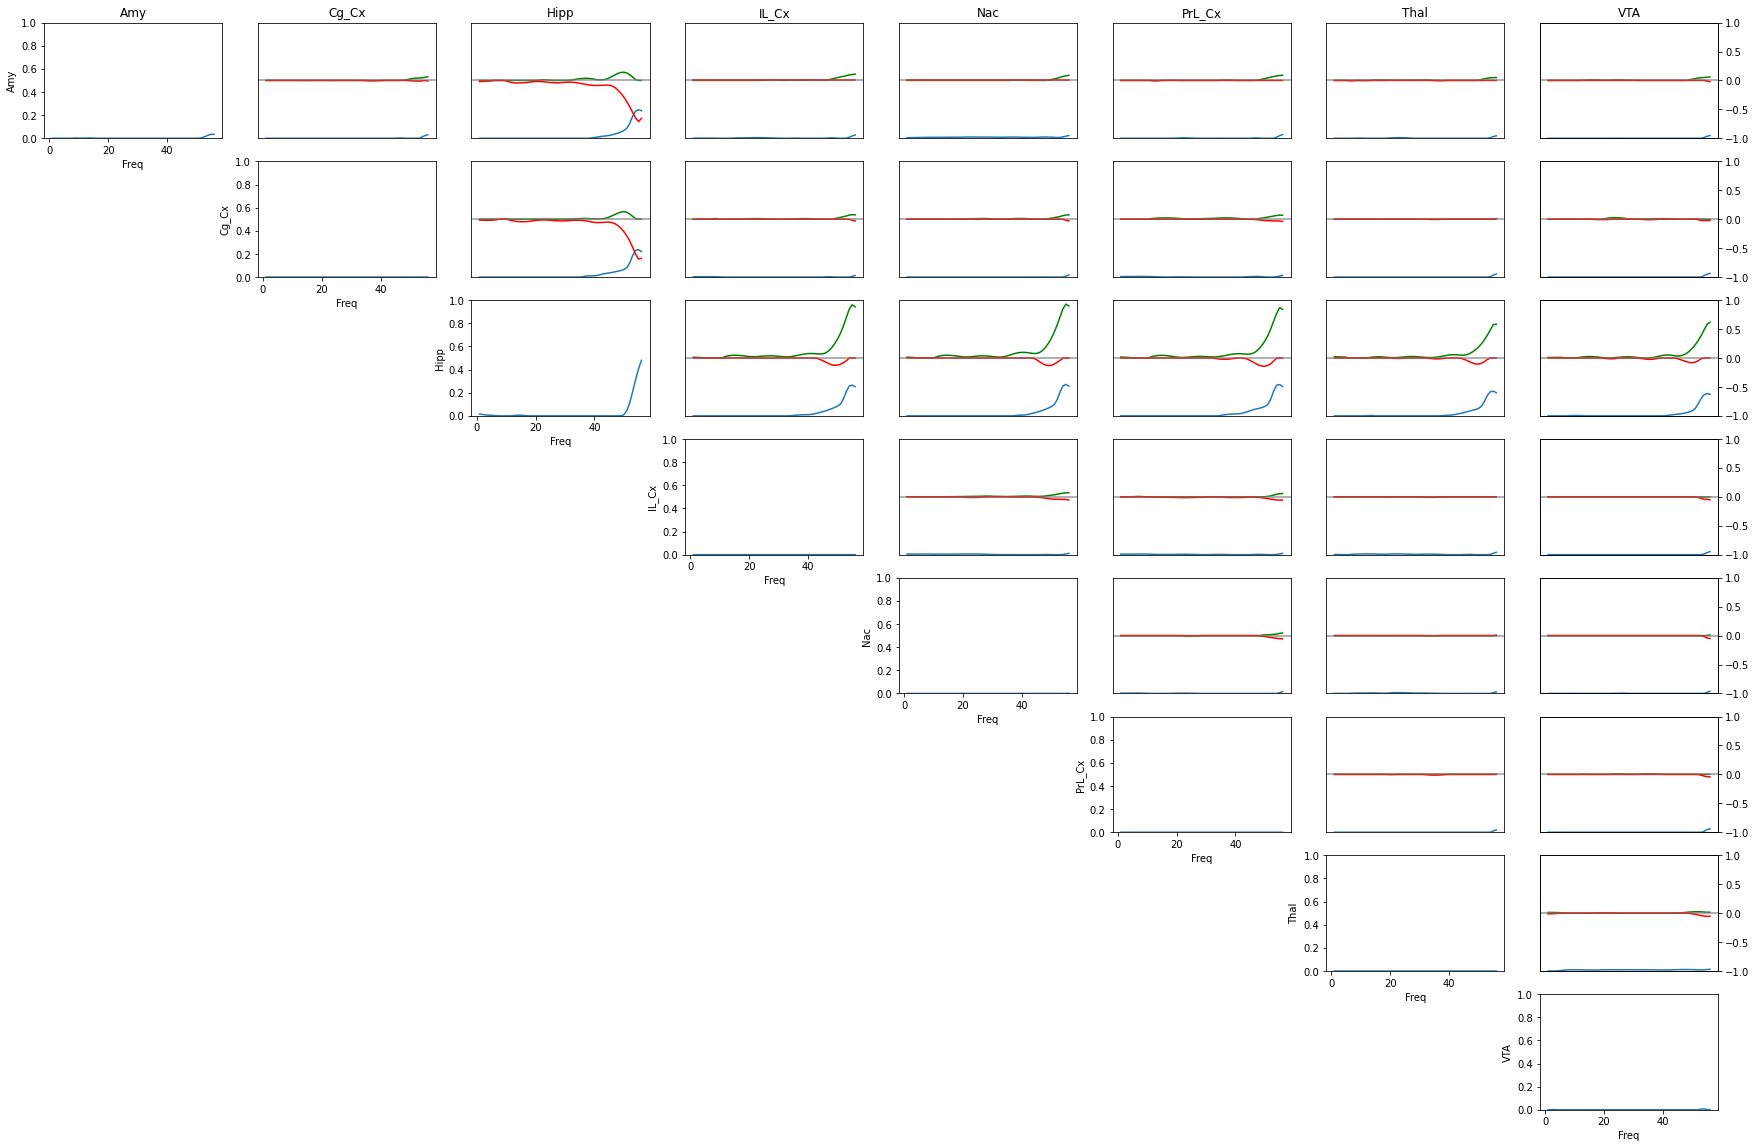

(1, 448) (1, 1568) (1, 3136)


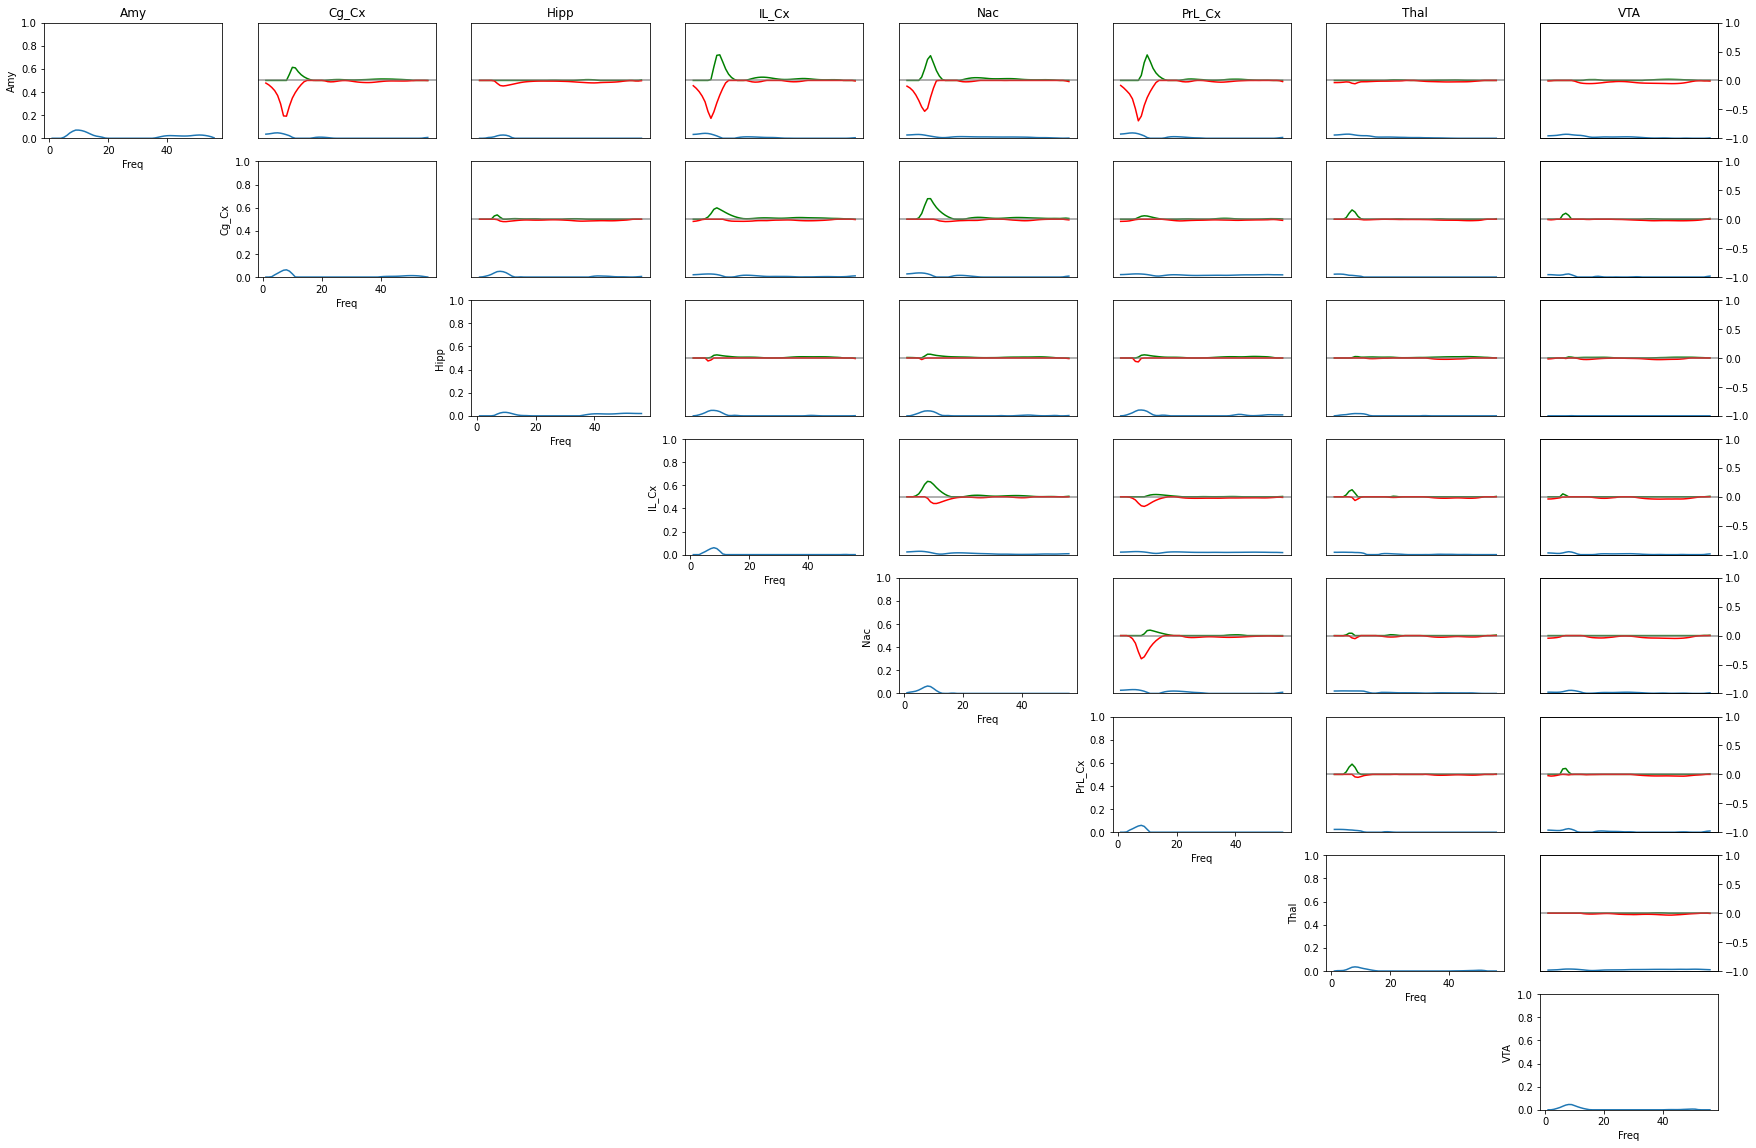

(1, 448) (1, 1568) (1, 3136)


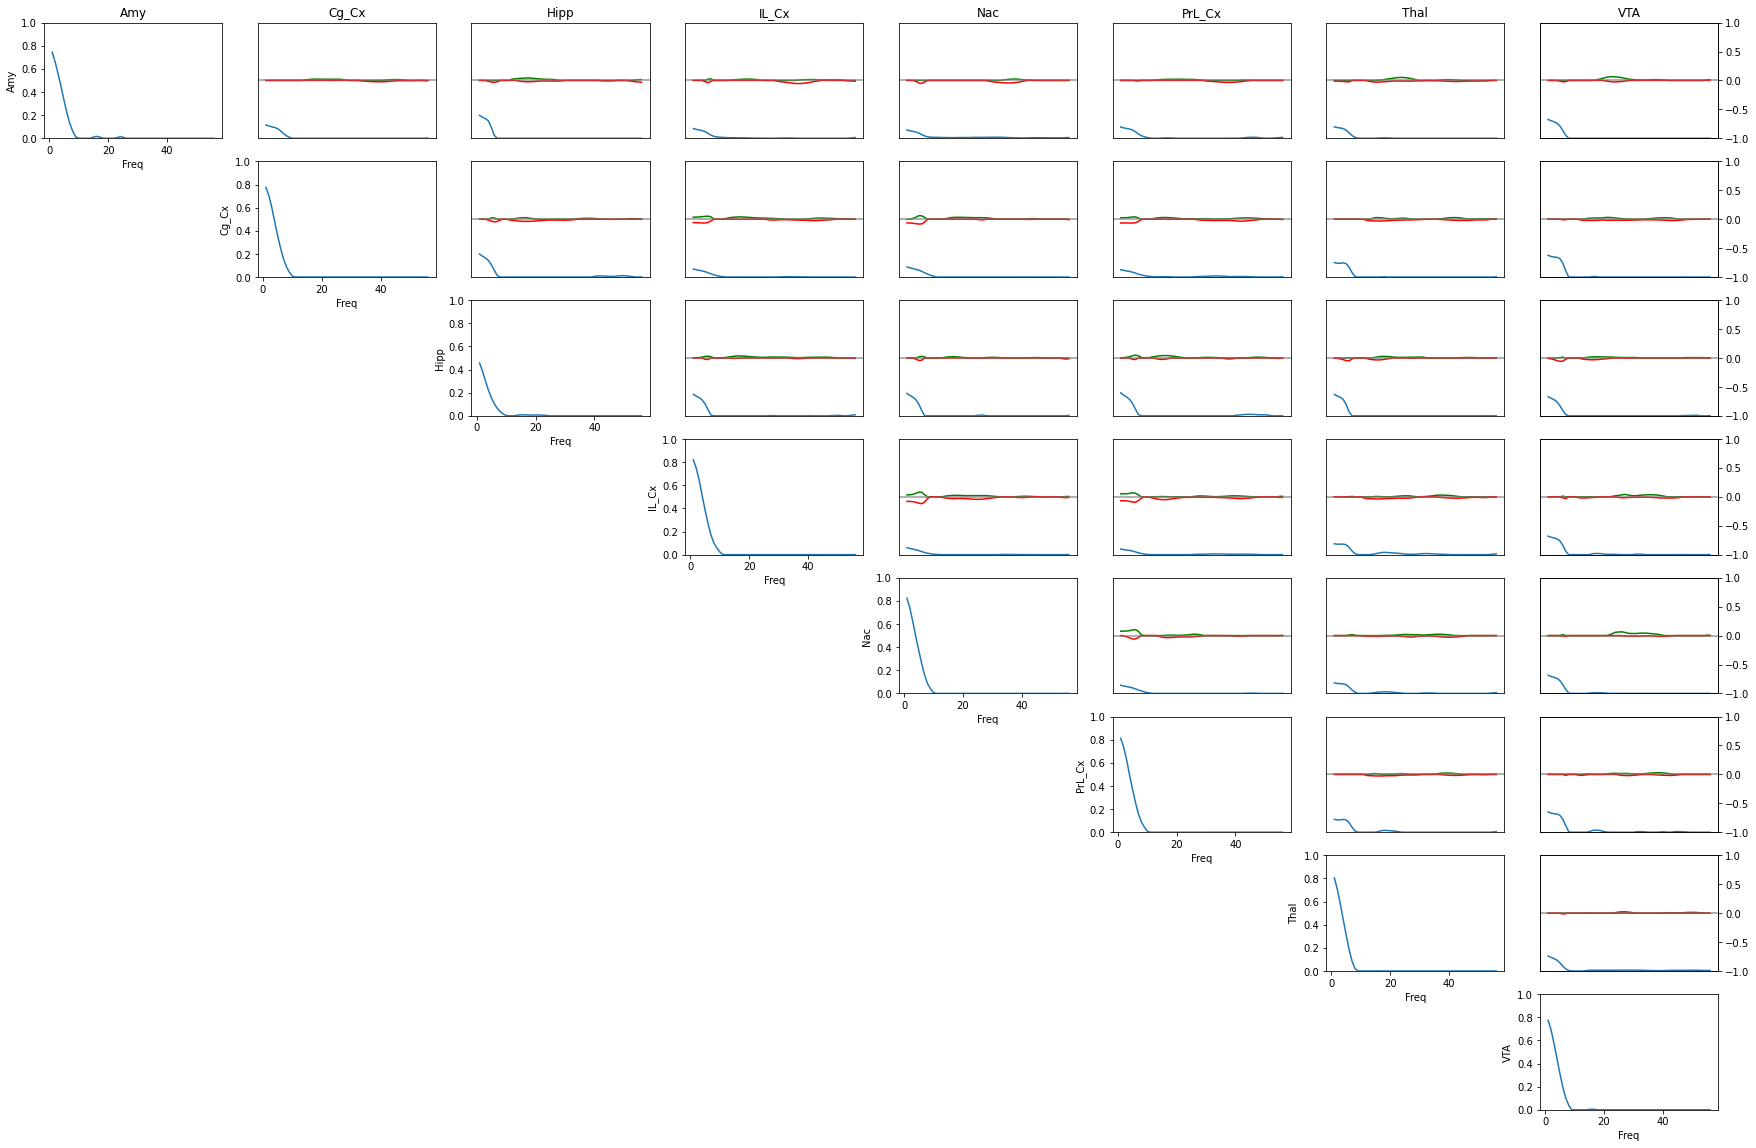

(1, 448) (1, 1568) (1, 3136)


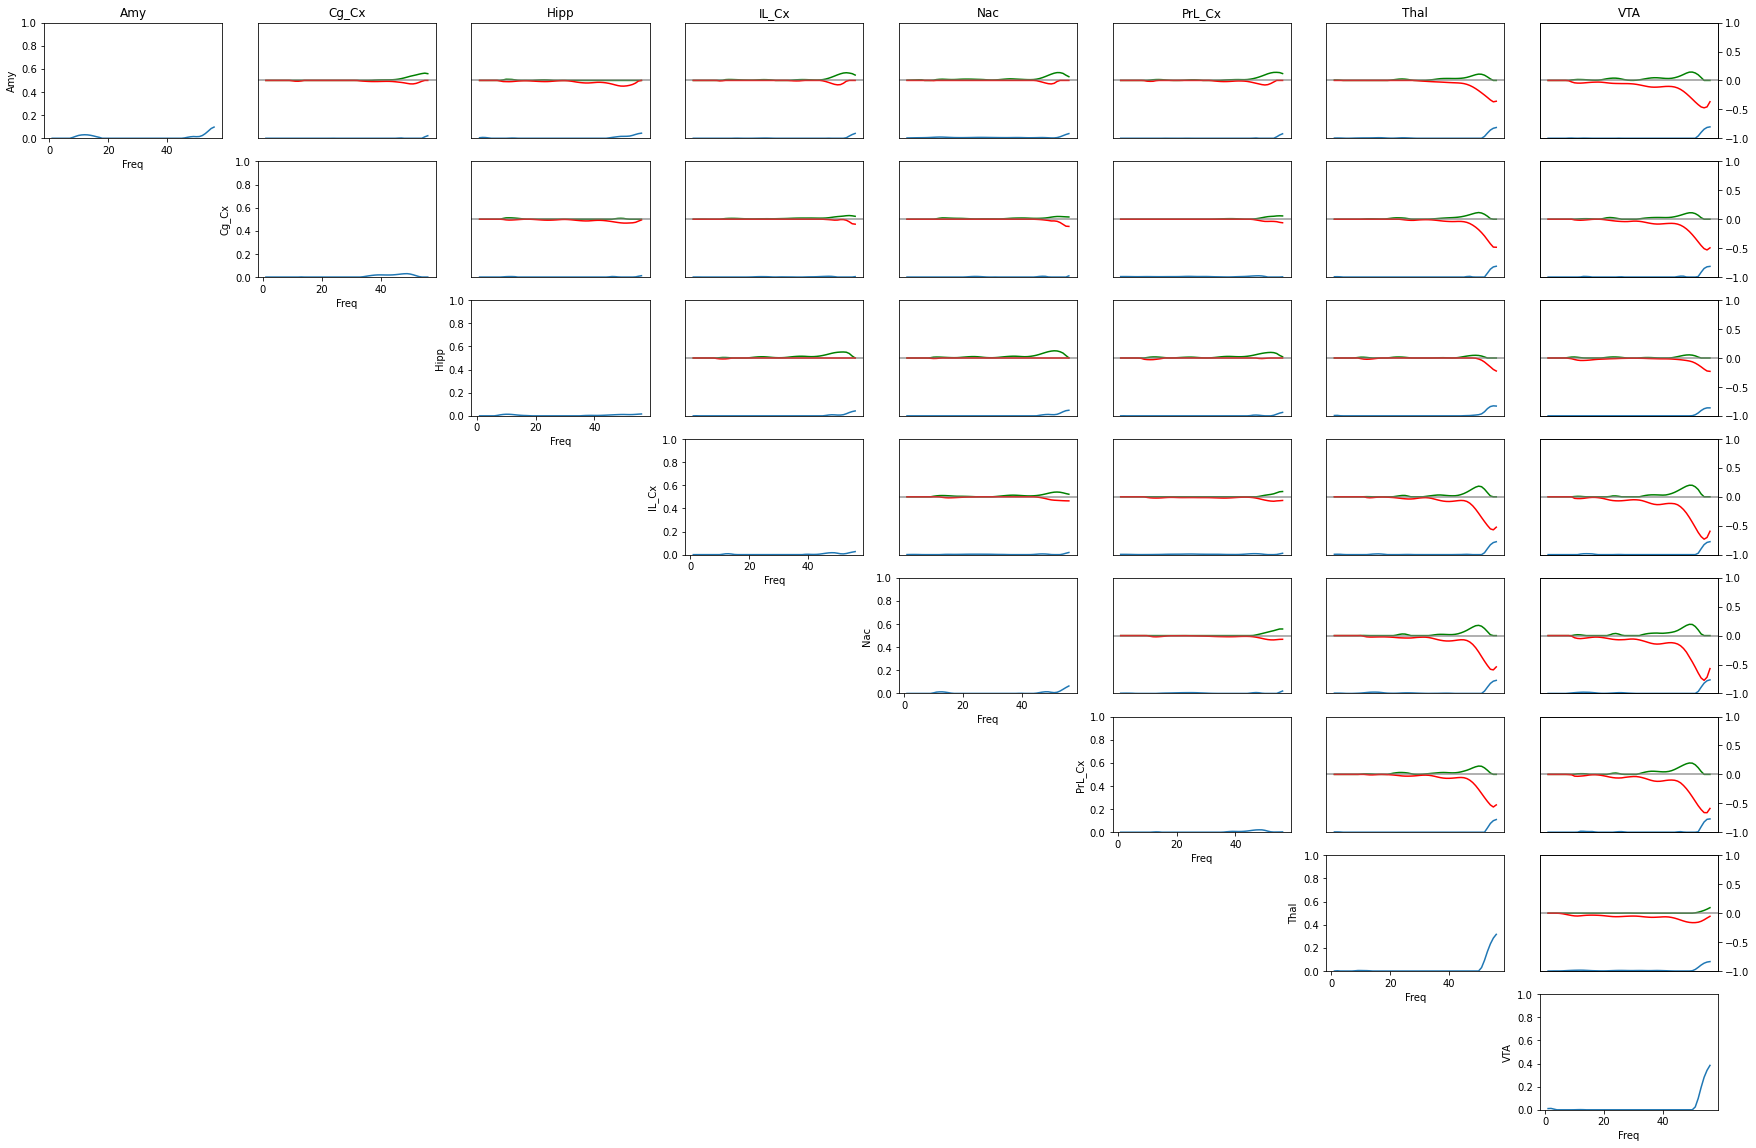

(1, 448) (1, 1568) (1, 3136)


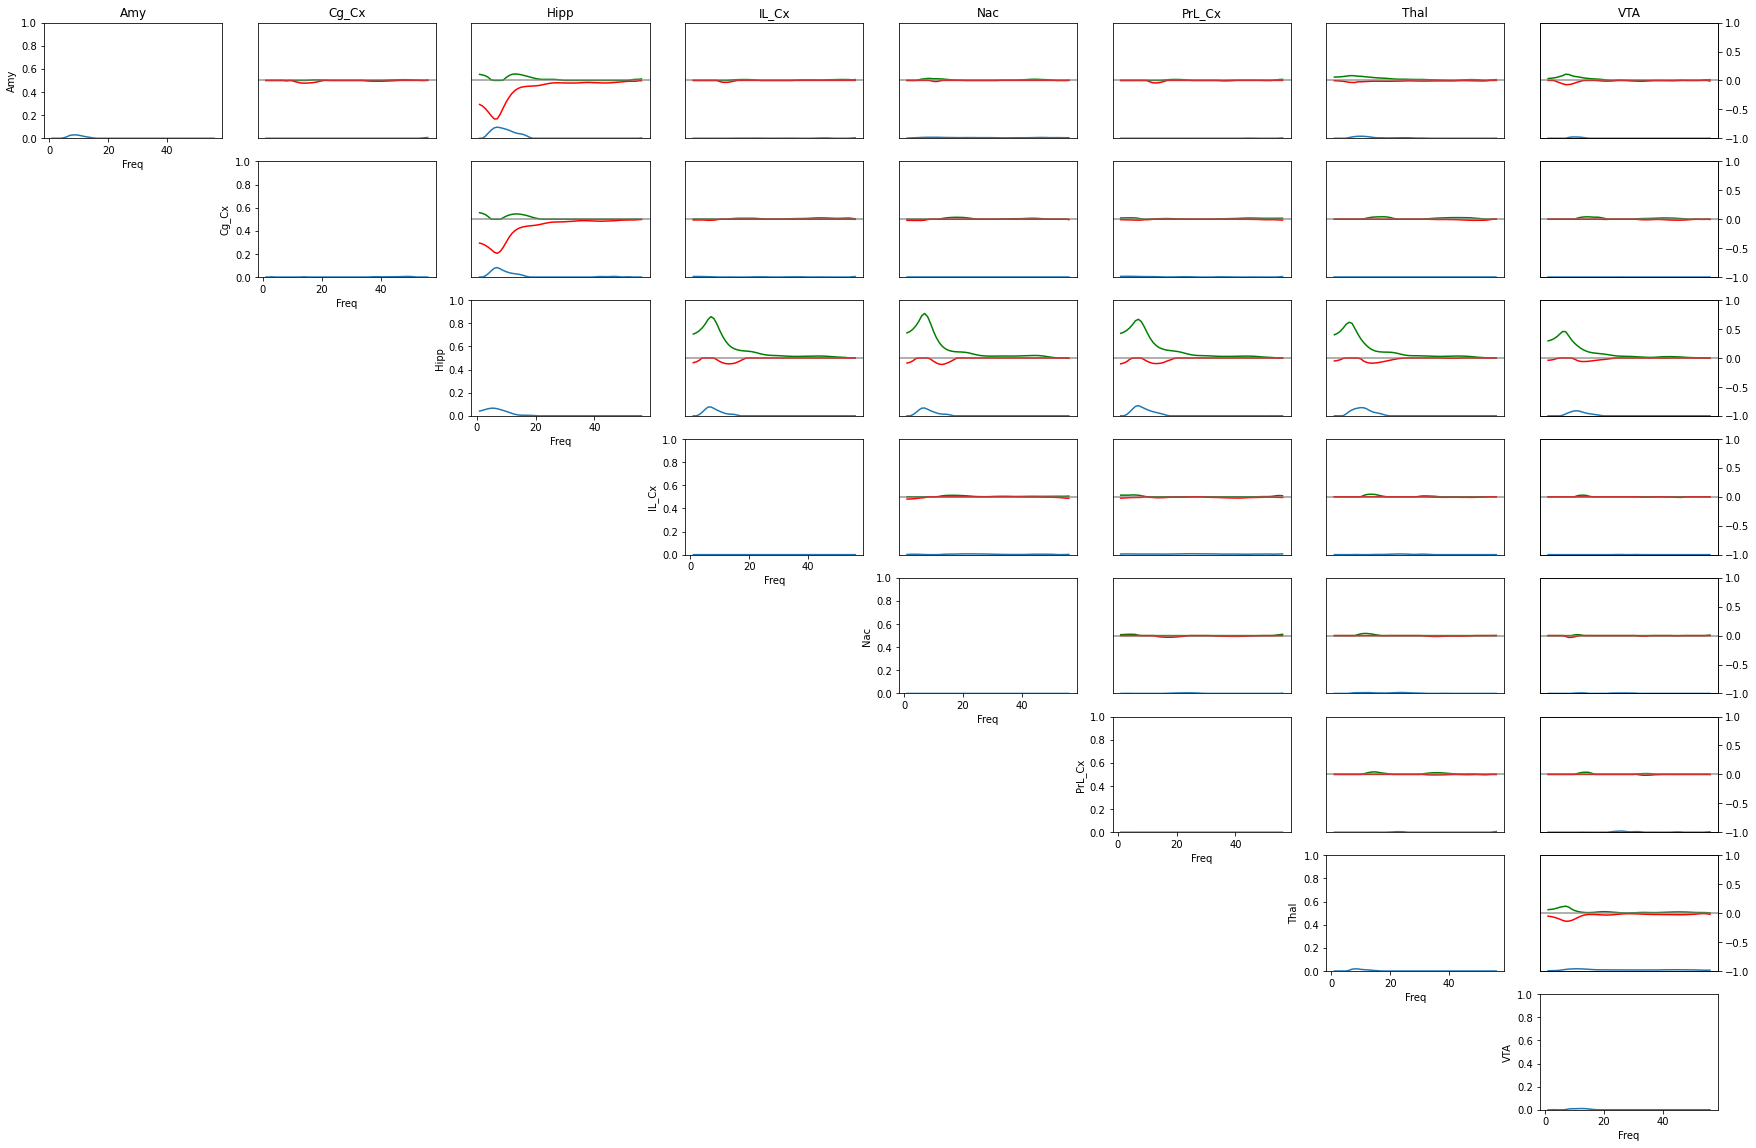

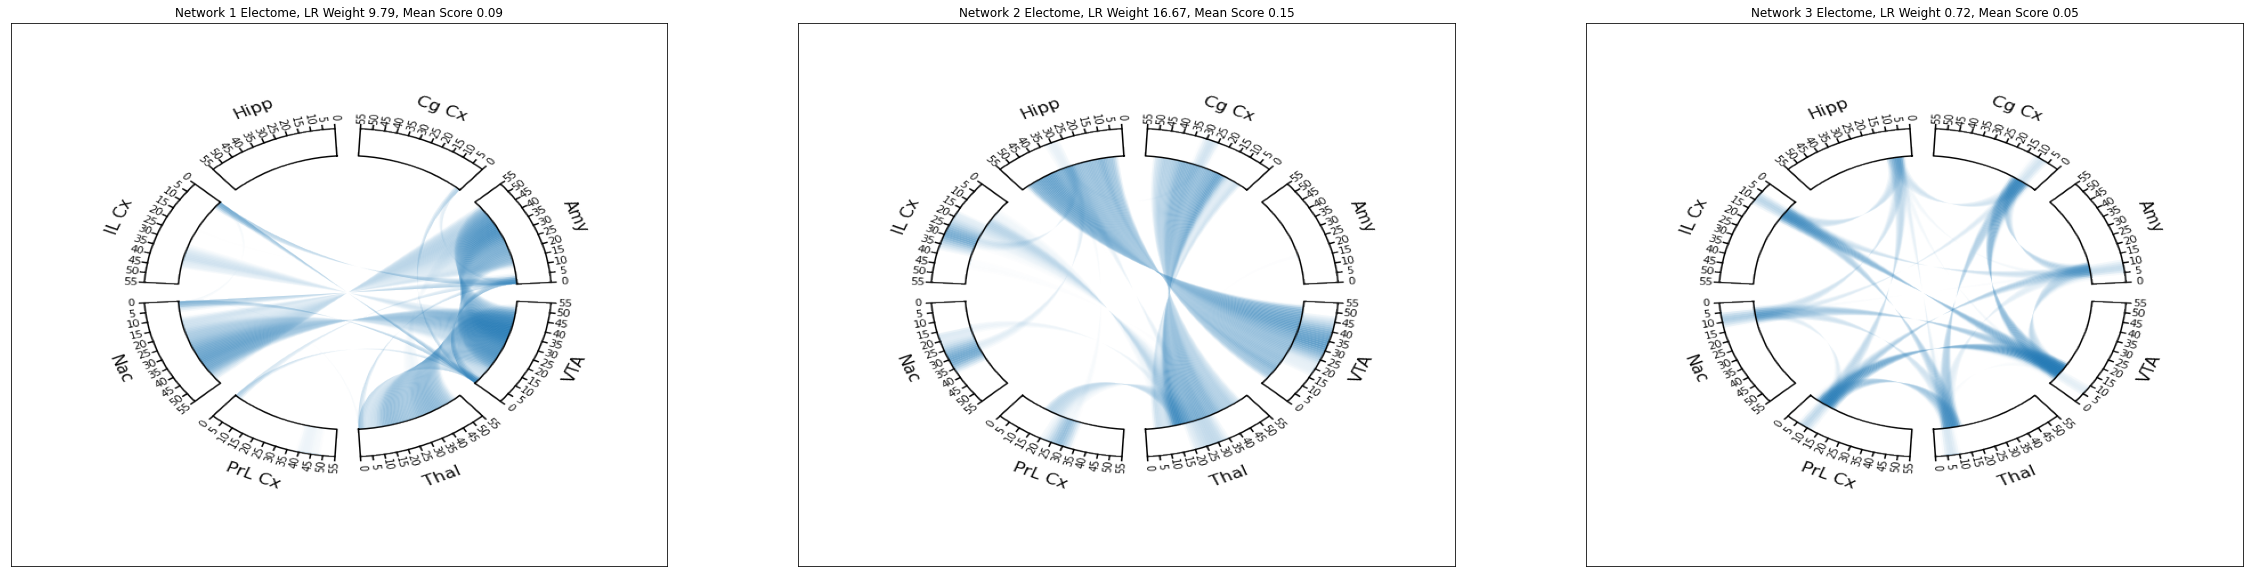

In [14]:
def reshapeData(X_psd,X_coh,n_rois,n_freqs,pow_features,coh_features,areas):
    X_3d = np.zeros((n_rois,n_rois,n_freqs))
    
    for i in range(n_rois):
        X_3d[i,i,:] = X_psd[i*n_freqs:(i+1)*n_freqs]
        
    
    split_coh_features = np.array([feature.split(' ')[0] for feature in coh_features])
    #print(split_coh_features)
    unique_coh_features = np.unique(split_coh_features)
    for i in range(n_rois):
        for j in range(n_rois):
            if i != j:
                area_1 = areas[i]
                area_2 = areas[j]
                temp_feature = area_1 + "-" + area_2
                temp_feature_2 = area_2 + "-" + area_1
                if temp_feature in unique_coh_features:
                    feature_mask = np.where(split_coh_features==temp_feature,True,False)
                    X_3d[i,j,:] = X_coh[feature_mask==1]
                    X_3d[j,i,:] = X_coh[feature_mask==1]

                elif temp_feature_2 in unique_coh_features:
                    feature_mask = np.where(split_coh_features==temp_feature_2,1,0)
                    X_3d[i,j,:] = X_coh[feature_mask==1]
                    X_3d[j,i,:] = X_coh[feature_mask==1]

                else:
                    print("temp_feature: {} not found".format(temp_feature))

    return X_3d

with open("/work/mk423/Anxiety/Anx_Info_Dict.pkl","rb") as f:
    anxInfo = pickle.load(f)


for i in range(30):
    s = model.project(mt_X_train)
    X_sup_recon = model.get_comp_recon(torch.Tensor(s).to("cpu"),i)
    X_recon = model.reconstruct(mt_X_train)

    recon_contribution = np.mean(X_sup_recon/X_recon,axis=0)
    rec_psd = recon_contribution[:len(anxInfo["powerFeatures"])]
    rec_coh = recon_contribution[len(anxInfo["powerFeatures"]):(len(anxInfo["powerFeatures"]) + len(anxInfo["cohFeatures"]))]
    rec_3d = reshapeData(rec_psd,rec_coh,8,56,anxInfo["powerFeatures"],anxInfo["cohFeatures"],anxInfo["area"])

    circle_plot(rec_3d,anxInfo["area"],freqs=np.arange(56),freq_ticks=np.arange(0,56,5),min_max_quantiles=(0.85,0.9999),fn=plots_path + "final_3_net_notebook_electome_{}_500.svg".format(i))
    umc_dt.makeUpperTriangularPlot_pow_coh_gc(recon_contribution.reshape(1,-1),anxInfo["area"],anxInfo["powerFeatures"],
                                              anxInfo["cohFeatures"],anxInfo["gcFeatures"],
                                              title=None,#"Electome {} Expanded".format(i),
                                              saveFile=plots_path + "final_3_net_notebook_uptri_{}_500.svg".format(i))
plt.figure(figsize=(40,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    im = image.imread(plots_path + "final_3_net_notebook_electome_{}_500.png".format(i))
    plt.imshow(im,aspect="auto")
    plt.title("Network {} Electome, LR Weight {:.2f}, Mean Score {:.2f}".format(i+1, model.classifier[0].weight[0][i].detach().cpu().numpy(),np.mean(s[:,i])))
    plt.xticks([])
    plt.yticks([])
plt.show()

### FLX Performance

In [18]:
flx_test_auc = model.score(flx_X_test[flx_y_hab_test==1],
                          flx_y_test[flx_y_hab_test==1].reshape(-1,1),
                            flx_y_mouse_test[flx_y_hab_test==1],
                            return_dict=True)
                                     
flx_mean_test_auc = np.mean([flx_test_auc[key] for key in flx_test_auc.keys()])
flx_stderr_test_auc = np.std([flx_test_auc[key] for key in flx_test_auc.keys()]) / np.sqrt(len(flx_test_auc.keys()))

print("FLX test auc: {:.3f} +/- {:.3f}".format(flx_mean_test_auc,flx_stderr_test_auc))
print(flx_test_auc)
print("FLX test mse: {:.3f}".format(np.mean((flx_X_test[flx_y_hab_test==1]-model.reconstruct(flx_X_test[flx_y_hab_test==1]))**2)))

FLX test auc: 0.586 +/- 0.035
{'Mouse69061': [0.4102502200646685], 'Mouse78732': [0.6067541168223762], 'Mouse78743': [0.6708565853658537], 'Mouse78745': [0.6314347244280166], 'Mouse78751': [0.5610492452363276], 'Mouse78764': [0.6340186801104197]}
FLX test mse: 0.036


### FLX Projection

In [11]:
s_flx_test = model.project(flx_X_test)
auc_flx_test = [flx_test_auc[mouse][0] for mouse in flx_y_mouse_test]

proj_dict = {
    "net 1 scores":s_flx_test[:,0],
    "net 2 scores":s_flx_test[:,1],
    "net 3 scores":s_flx_test[:,2],
    "flx":flx_y_test,
    "mouse":flx_y_mouse_test,
    "time":flx_y_time_test,
    "expDate":flx_y_expDate_test,
    "auc (last-30-minutes)":auc_flx_test
}

df = pd.DataFrame.from_dict(proj_dict)
#df.to_csv(projection_save_path + "FLX_Holdout_Projections.csv")
df.head()

net 1 scores  net 2 scores  net 3 scores  flx       mouse  time expDate  \
0      0.095238      0.137678      0.052358  1.0  Mouse78732     1  040623   
1      0.111536      0.174981      0.088253  1.0  Mouse78732     2  040623   
2      0.104888      0.164768      0.016867  1.0  Mouse78732     3  040623   
3      0.103743      0.182411      0.012262  1.0  Mouse78732     4  040623   
4      0.103712      0.220500      0.024219  1.0  Mouse78732     6  040623   

   auc (last-30-minutes)  
0               0.606754  
1               0.606754  
2               0.606754  
3               0.606754  
4               0.606754

### EPM Performance

In [16]:
epm_test_auc = model.score(X_test,
                          y_in_task_mask_test.reshape(-1,1),
                          y_mouse_test,
                          return_dict=True)

epm_mean_test_auc = np.mean([epm_test_auc[key] for key in epm_test_auc.keys()])
epm_stderr_test_auc = np.std([epm_test_auc[key] for key in epm_test_auc.keys()]) / np.sqrt(len(epm_test_auc.keys()))

print("EPM test auc: {:.3f} +/- {:.3f}".format(epm_mean_test_auc,epm_stderr_test_auc))
print(epm_test_auc)
print("EPM test mse: {:.3f}".format(np.mean((X_test-model.reconstruct(X_test))**2)))

EPM test auc: 0.756 +/- 0.027
{'Mouse0641': [0.7422324510932107], 'Mouse39115': [0.891685935457927], 'Mouse39121': [0.906627367939106], 'Mouse39122': [0.7198150541108062], 'Mouse39132': [0.6635451110061408], 'Mouse39135': [0.871639430680021], 'Mouse6674': [0.6546029776674938], 'Mouse69061': [0.7085181384141715], 'Mouse69071': [0.7389144033573523], 'Mouse69075': [0.7610080628315996], 'Mouse8893': [0.6597929274098717]}
EPM test mse: 0.040


### EPM Projection

In [13]:
s_epm_test = model.project(X_test)
auc_epm_test = [epm_test_auc[mouse][0] for mouse in y_mouse_test]

proj_dict = {
    "net 1 scores":s_epm_test[:,0],
    "net 2 scores":s_epm_test[:,1],
    "net 3 scores":s_epm_test[:,2],
    "in-task":y_in_task_mask_test,
    "mouse":y_mouse_test,
    "time":y_time_test,
    "expDate":epm_y_expDate_test,
    "auc (Homecage vs. Task)":auc_epm_test,
    "roi":epm_test_dict["y_ROI"],
    "velocity":epm_test_dict["y_vel"],
    
}

df = pd.DataFrame.from_dict(proj_dict)
#df.to_csv(projection_save_path + "EPM_Holdout_Projections.csv")
df.head()

net 1 scores  net 2 scores  net 3 scores  in-task      mouse  time expDate  \
0      0.081440      0.092658      0.096652    False  Mouse0641     1  110717   
1      0.062944      0.062938      0.081924    False  Mouse0641     2  110717   
2      0.083994      0.098514      0.112678    False  Mouse0641     4  110717   
3      0.129436      0.163424      0.065320    False  Mouse0641    12  110717   
4      0.072507      0.120995      0.040223    False  Mouse0641    13  110717   

   auc (Homecage vs. Task)  roi    velocity  
0                 0.742232    1 -2147483648  
1                 0.742232    1 -2147483648  
2                 0.742232    3 -2147483648  
3                 0.742232    3 -2147483648  
4                 0.742232    3 -2147483648

### OFT Performance

In [17]:
oft_test_auc = model.score(oft_X_test,
                            oft_y_task_test.reshape(-1,1),
                            oft_y_mouse_test,
                            return_dict=True)

oft_mean_test_auc = np.mean([oft_test_auc[key] for key in oft_test_auc.keys()])
oft_stderr_test_auc = np.std([oft_test_auc[key] for key in oft_test_auc.keys()]) / np.sqrt(len(oft_test_auc.keys()))
print("OFT test auc: {:.3f} +/- {:.3f}".format(oft_mean_test_auc,oft_stderr_test_auc))
print(oft_test_auc)
print("EPM test mse: {:.3f}".format(np.mean((oft_X_test-model.reconstruct(oft_X_test))**2)))

OFT test auc: 0.844 +/- 0.025
{'Mouse04203': [0.9039771437220919], 'Mouse39115': [0.8642398389570553], 'Mouse39121': [0.9121263527347176], 'Mouse39122': [0.7343512031678343], 'Mouse39132': [0.9265035101827903], 'Mouse39135': [0.8670534203529128], 'Mouse69061': [0.6935489654677808], 'Mouse69071': [0.8263132216620588], 'Mouse69075': [0.8662951995012468]}
EPM test mse: 0.041


### OFT Projections

In [15]:
s_oft_test = model.project(oft_X_test)
auc_oft_test = [oft_test_auc[mouse][0] for mouse in oft_y_mouse_test]

proj_dict = {
    "net 1 scores":s_oft_test[:,0],
    "net 2 scores":s_oft_test[:,1],
    "net 3 scores":s_oft_test[:,2],
    "in-task":oft_y_task_test,
    "mouse":oft_y_mouse_test,
    "time":oft_y_time_test,
    "expDate":oft_y_expDate_test,
    "auc (Homecage vs. Task)":auc_oft_test,
    "roi":oft_y_ROI_test,
    "velocity":oft_y_vel_test,
    
}

df = pd.DataFrame.from_dict(proj_dict)
#df.to_csv(projection_save_path + "OFT_Holdout_Projections.csv")
df.head()

net 1 scores  net 2 scores  net 3 scores  in-task       mouse  time  \
0      0.026420      0.012433      0.007595    False  Mouse04203     1   
1      0.085713      0.082628      0.027619    False  Mouse04203     3   
2      0.066529      0.133424      0.023311    False  Mouse04203     4   
3      0.005939      0.009126      0.056668    False  Mouse04203     5   
4      0.042559      0.145444      0.015247    False  Mouse04203     6   

  expDate  auc (Homecage vs. Task)  roi      velocity  
0  090421                 0.903977  NaN -2.147484e+09  
1  090421                 0.903977  NaN -2.147484e+09  
2  090421                 0.903977  NaN -2.147484e+09  
3  090421                 0.903977  NaN -2.147484e+09  
4  090421                 0.903977  NaN -2.147484e+09

### Visualizing Performance

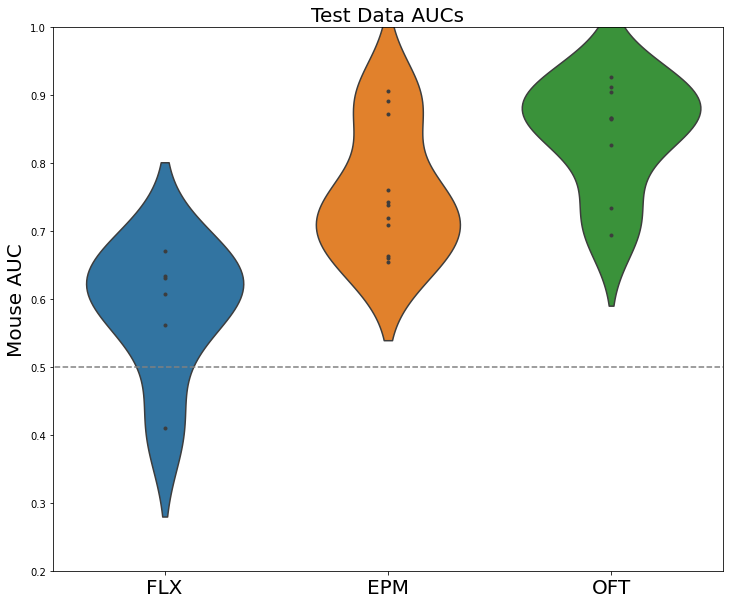

In [16]:
flx_auc_list = [flx_test_auc[key][0] for key in flx_test_auc.keys()]
epm_auc_list = [epm_test_auc[key][0] for key in epm_test_auc.keys()]
oft_auc_list = [oft_test_auc[key][0] for key in oft_test_auc.keys()]

flx_key_list = [key for key in flx_test_auc.keys()]
epm_key_list = [key for key in epm_test_auc.keys()]
oft_key_list = [key for key in oft_test_auc.keys()]

flx_exp_list = ["FLX" for key in flx_test_auc.keys()]
epm_exp_list = ["EPM" for key in epm_test_auc.keys()]
oft_exp_list = ["OFT" for key in oft_test_auc.keys()]

all_aucs = np.hstack([flx_auc_list,epm_auc_list,oft_auc_list])
all_keys = np.hstack([flx_key_list,epm_key_list,oft_key_list])
all_exps = np.hstack([flx_exp_list,epm_exp_list,oft_exp_list])

auc_dict = {
    "aucs":all_aucs,
    "mice":all_keys,
    "exps":all_exps,
}

df = pd.DataFrame.from_dict(auc_dict)

plt.figure(figsize=(12,10))
sns.violinplot(data=df,x="exps",y="aucs",inner="point",alpha=0.5,fontsize=20)
plt.axhline(0.5,-1,6,linestyle="dashed",color="grey")
plt.xlabel(None,fontsize=20)
plt.ylabel("Mouse AUC",fontsize=20)
plt.title("Test Data AUCs",fontsize=20)
plt.xticks(range(3),["FLX","EPM","OFT"],fontsize=20)
plt.ylim([.2,1])
plt.savefig(plots_path + "Final Model Violin Plot.svg")
plt.show()

### Individual Network AUCs

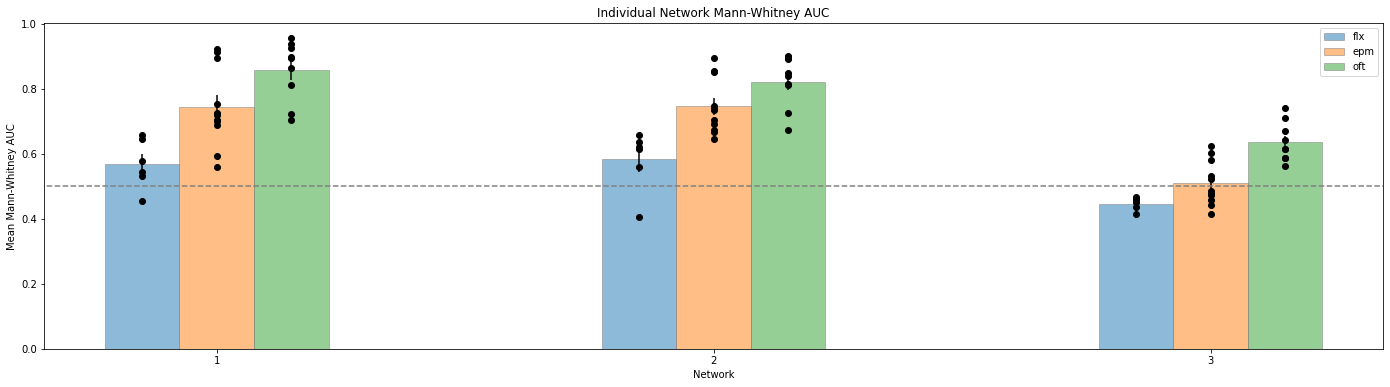

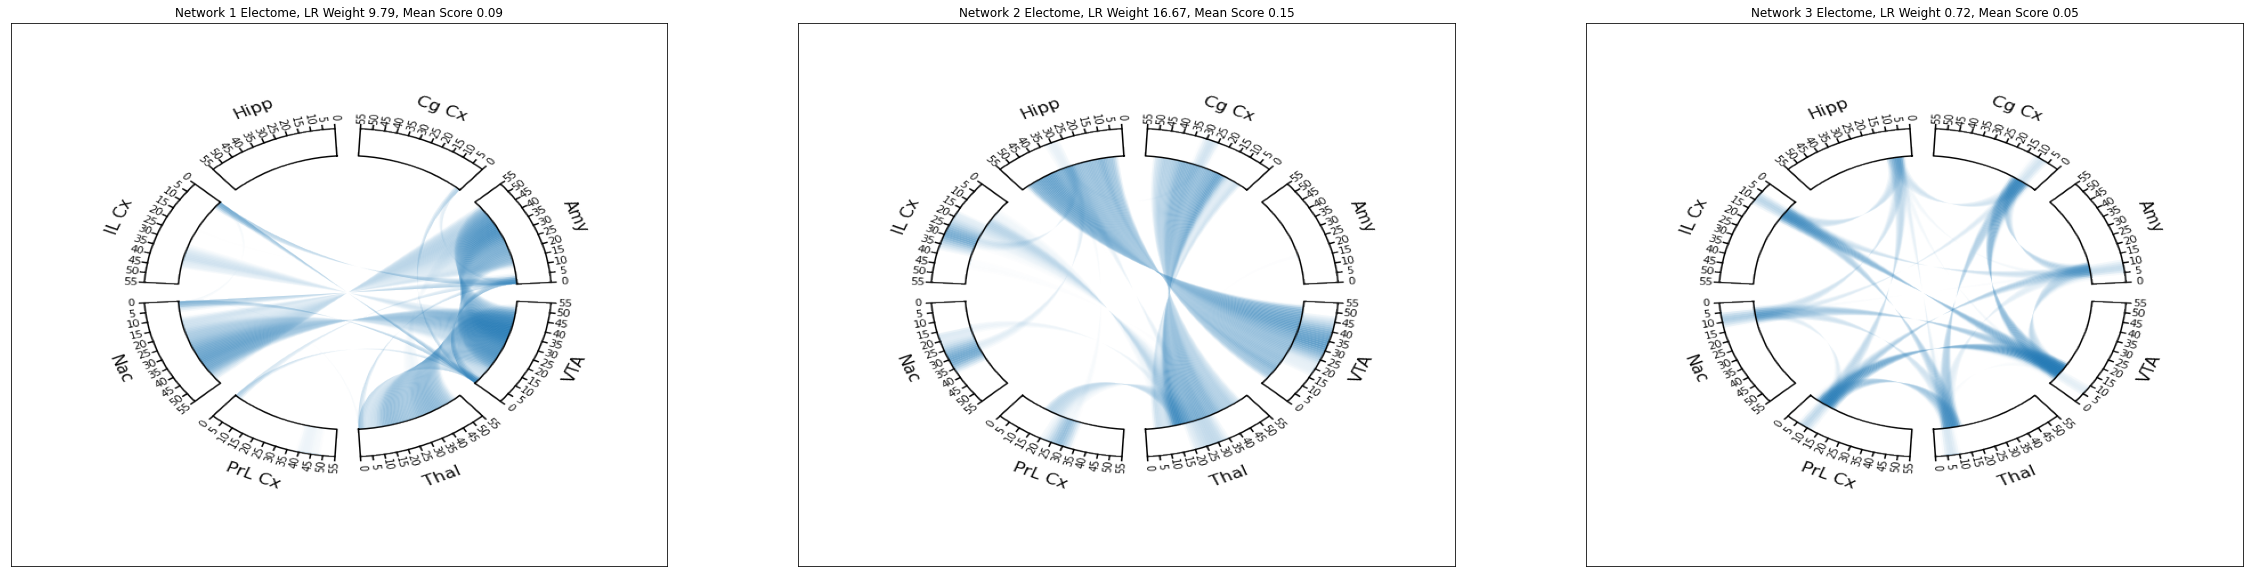

In [18]:
flx_s_test = model.project(flx_X_test[flx_y_hab_test==1])
epm_s_test = model.project(X_test)
oft_s_test = model.project(oft_X_test)

y_pred_flx = model.predict_proba(flx_X_test[flx_y_hab_test==1])
y_pred_epm = model.predict_proba(X_test)
y_pred_oft = model.predict_proba(oft_X_test)

flx_mean_list = []
flx_sterr_list = []
flx_points_list = []

epm_mean_list = []
epm_sterr_list = []
epm_points_list = []

oft_mean_list = []
oft_sterr_list = []
oft_points_list = []

for i in range(3):
    flx_mean, flx_sterr=umc_dt.get_mean_std_err_auc(y_pred_flx.squeeze(),
                                                   flx_y_test[flx_y_hab_test==1],
                                                   flx_y_mouse_test[flx_y_hab_test==1],
                                                   z=flx_s_test[:,i].reshape(-1,1),
                                                   mannWhitneyU=True)
    flx_auc = umc_dt.lpne_auc(y_pred_flx,
                               flx_y_test[flx_y_hab_test==1],
                               flx_y_mouse_test[flx_y_hab_test==1],
                               z=flx_s_test[:,i].reshape(-1,1),
                               mannWhitneyU=True)
    
    flx_points_list.append([flx_auc[key][0] for key in list(flx_auc.keys()) if key is not "auc_method"])
    flx_mean_list.append(flx_mean)
    flx_sterr_list.append(flx_sterr)
    
    epm_mean, epm_sterr=umc_dt.get_mean_std_err_auc(y_pred_epm,
                                                   y_in_task_mask_test,
                                                   y_mouse_test,
                                                   z=epm_s_test[:,i].reshape(-1,1),
                                                   mannWhitneyU=True)
    
    epm_auc =umc_dt.lpne_auc(y_pred_epm,
                           y_in_task_mask_test,
                           y_mouse_test,
                           z=epm_s_test[:,i].reshape(-1,1),
                           mannWhitneyU=True)
    
    epm_points_list.append([epm_auc[key][0] for key in list(epm_auc.keys()) if key is not "auc_method"])
    epm_mean_list.append(epm_mean)
    epm_sterr_list.append(epm_sterr)
    
    oft_mean, oft_sterr=umc_dt.get_mean_std_err_auc(y_pred_oft,
                                                   oft_y_task_test,
                                                   oft_y_mouse_test,
                                                   z=oft_s_test[:,i].reshape(-1,1),
                                                   mannWhitneyU=True)
    
    oft_auc=umc_dt.lpne_auc(y_pred_oft,
                           oft_y_task_test,
                           oft_y_mouse_test,
                           z=oft_s_test[:,i].reshape(-1,1),
                           mannWhitneyU=True)
    
    oft_points_list.append([oft_auc[key][0] for key in list(oft_auc.keys()) if key is not "auc_method"])
    oft_mean_list.append(oft_mean)
    oft_sterr_list.append(oft_sterr)

barWidth = 0.15
fig = plt.subplots(figsize=(24,6))

br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, flx_mean_list,yerr=flx_sterr_list, width = barWidth,
        edgecolor ='grey', label ='flx',alpha=0.5)
plt.bar(br2, epm_mean_list,yerr=epm_sterr_list, width = barWidth,
        edgecolor ='grey', label ='epm',alpha=0.5)
plt.bar(br3, oft_mean_list,yerr=oft_sterr_list, width = barWidth,
        edgecolor ='grey', label ='oft',alpha=0.5)

for i in range(3):
    plt.scatter(np.ones(len(flx_points_list[i]))*br1[i],flx_points_list[i],color="black")
    plt.scatter(np.ones(len(epm_points_list[i]))*br2[i],epm_points_list[i],color="black")
    plt.scatter(np.ones(len(oft_points_list[i]))*br3[i],oft_points_list[i],color="black")

plt.xticks([r + barWidth for r in range(len(flx_mean_list))],
        [1,2,3])
plt.axhline(0.5,-1,6,linestyle="dashed",color="grey")
plt.xlabel('Network', fontsize = 10)
plt.ylabel('Mean Mann-Whitney AUC', fontsize = 10)
plt.legend()
plt.title("Individual Network Mann-Whitney AUC")
plt.savefig(plots_path + "individualNetworkAUCs.svg")
plt.show()

plt.figure(figsize=(40,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    im = image.imread(plots_path + "final_3_net_notebook_electome_{}_500.png".format(i))
    plt.imshow(im,aspect="auto")
    plt.title("Network {} Electome, LR Weight {:.2f}, Mean Score {:.2f}".format(i+1, model.classifier[0].weight[0][i].detach().cpu().numpy(),np.mean(s[:,i])))
    plt.xticks([])
    plt.yticks([])
plt.show()